# Files needed

* `Plenum/style.mplstyle`
* `Plenum/resources/point-source_discovery_time-evolution.csv`
* `Plenum/resources/ngc_paper_68_contour.txt`
* `Plenum/resources/ngc_contour_spl.csv`
* `Plenum/resources/local_background_ngc.txt`
* `Plenum/resources/background_events_baseline.txt`
* `Plenum/resources/background_events_improved.txt`
* `Plenum/resources/PL_events_baseline.txt`
* `Plenum/resources/PL_events_improved.txt`
* `Plenum/resources/PLC_events_baseline.txt`
* `Plenum/resources/PLC_events_improved.txt`


In [2]:
%run ../../core/event_numbers.py

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!
Calculate detection efficiencies
Calculate instantaneous detection efficiencies


3it [00:10,  3.50s/it]


# Import & settings

In [3]:
import sys

sys.path.insert(0, "../../core/")

from os.path import join
from collections import namedtuple
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pickle import load
from scipy.stats import chi2

# PLEnuM tools
import settings as st
from tools import get_mids
from fluxes import ngc_flux, ngc_cut_flux, PL_flux, PLcut_flux, power_law, cut_off

# from fluxes import ngc_flux,PL_flux, PLcut_flux, power_law, cut_off#, ngc_cut_flux,
from aeff_calculations import get_aeff_and_binnings

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.colors import LogNorm, ListedColormap
import pickle
from matplotlib.gridspec import GridSpec
from fluxes import kheirandish_src_flux, inoue_src_flux

from tools import *
from settings import *


# plt.style.use("../../style.mplstyle")

plot_path = "plots/ngc_paper"
# plot_path = "plots/paper"

IC_North_det = "KM3NeT"
font_color = "0.25"

In [4]:
f"{1/sigma5:1.2e}"

'6.98e+06'

In [5]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    "../../resources/ngc_science_contour_68.txt", comments="#", 
)
phi_c_68 /= 1e11

In [6]:
# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 14 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "IC_North_det": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC 14~yr + IC-North 10~yr",
        "plainlabel": "IC_North_det",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT 10~yr",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC 14~yr + PLE$\nu$M-1 10~yr",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-2 10~yr",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },    
    "Plenum-3": {
        "color": "indigo",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-3 10~yr",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "o",
    },
}

In [7]:
###### See plenum_skymap_illustrations_for_paper.ipynb for Skymaps #####

# Source evolution

In [8]:
df = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/resources/source_population.csv")
_se_cmap = sns.color_palette(
    np.concatenate(
        [
            sns.color_palette("magma", n_colors=2),
            sns.color_palette("crest", n_colors=2),
        ]
    )
)
flux_ngc = (
    lambda energy: ngc_flux.norm * (energy / ngc_flux.E0) ** -ngc_flux.gamma
)  # / GeV cm^2 s
flux_diffuse_soft = lambda energy: 3e-8 / (1e4**2) * (energy / 1e4) ** -3.2

### v1 (vertical)

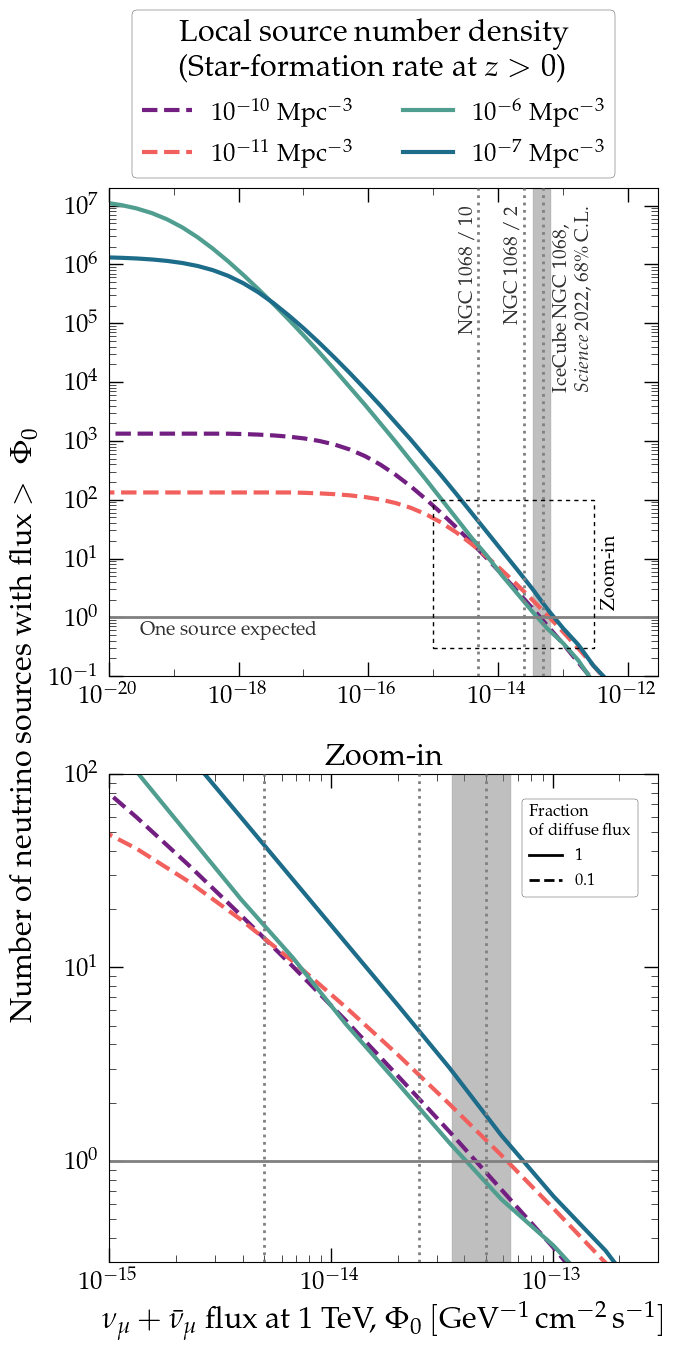

In [9]:
## flux at 1 TeV, horizontal
f, axes = plt.subplots(nrows=2, figsize=(7, 13), gridspec_kw=dict(hspace=0.2))
for ii, ax in enumerate(axes):

    for jj, (indx, series) in enumerate(
        df.groupby(["Source number density", "Fraction of total flux"])
    ):
        ax.plot(
            series.flux,
            series.cumulative_Nsrc,
            lw=3,
            label=indx[0] if ii == 0 else None,
            color=_se_cmap[jj],
            ls="-" if indx[1] == 1 else "--",
        )
    ax.set_xscale("log")
    ax.axhline(1, color="Gray")

    ax.axvspan(
        flux_ngc(ngc_flux.E0) / (5 / 3.5),  # 5 +- 1.5
        flux_ngc(ngc_flux.E0) / (5 / 6.5),  # 5 +- 1.5
        alpha=0.5,
        color="gray",
    )
    for jj in [1, 2, 10]:
        ax.axvline(
            flux_ngc(ngc_flux.E0) / jj,
            ls=":",
            color="gray",
            zorder=100,
        )
    ax.set_yscale("log")
    ax.grid(False)

ax.set_xlabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=22,
)
# Common y-axis label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.ylabel(r"Number of neutrino sources with flux $>~\Phi_0$", fontsize=22, labelpad=20)
plt.grid(alpha=0)

font_color = "0.2"
# zoom in
_xlim = (1e-15, 3e-13)
_ylim = (3e-1, 100)

ax = axes[1]
lg = f.legend(
    frameon=True,
    loc="upper center",
    ncols=2,
    # columnspacing=0.8,
    edgecolor="k",
    title="Local source number density" + "\n" + "(Star-formation rate at $z>0$)",
    # + r", {\it Madau \& Dickinson} 2014",
    title_fontsize=22,
    bbox_to_anchor=(0.55, 0.61, 0, 0.5),
)
custom_lines = [
    matplotlib.lines.Line2D([0], [0], color="k", lw=2, ls="-"),
    matplotlib.lines.Line2D([0], [0], color="k", lw=2, ls="--"),
]

lg = f.legend(
    custom_lines,
    [1, 0.1],
    frameon=True,
    loc="upper left",
    ncols=1,
    edgecolor="k",
    title="Fraction \n of diffuse flux",
    title_fontsize=12,
    alignment="left",
    fontsize=12,
    bbox_to_anchor=(0.75, 0.0, 0, 0.5),  # top right
    # bbox_to_anchor=(0.185, -0.285, 0, 0.5), # bottom left
)

ax.set_xlim(*_xlim)
ax.set_ylim(*_ylim)
ax.set_title("Zoom-in", fontsize=22)

# full view
ax = axes[0]

_rect = Rectangle(
    (_xlim[0], _ylim[0]),
    _xlim[1] - _xlim[0],
    _ylim[1] - _ylim[0],
    linewidth=1,
    ls=(0, (3, 3)),
    edgecolor="k",
    facecolor="none",
    zorder=100,
)
ax.add_patch(_rect)
ax.text(
    _xlim[1] * 1.3, (_ylim[1] * _ylim[0]) ** 0.5, "Zoom-in", rotation=90, va="center"
)
ax.set_xlim(1e-20, 3e-12)
ax.set_ylim(1e-1, 2e7)
# ax.set_title("Cumulative source distribution", fontsize=22)

ax.text(3e-20, 0.9, "One source expected", color=font_color, va="top")
# ax.text(
#     3e-20,
#     90,
#     "Evolution:"
#     + "\n"
#     + "Star-formation rate"
#     + "\n"
#     + r"{\it Madau \& Dickinson} 2014",
#     color=font_color,
#     va="top",
# )

_toptext = 1e7
ax.text(
    flux_ngc(ngc_flux.E0) / 10,
    _toptext,
    "NGC 1068 / 10",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)
ax.text(
    flux_ngc(ngc_flux.E0) / 2,
    _toptext,
    "NGC 1068 / 2",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)

ax.text(
    flux_ngc(ngc_flux.E0) / (5 / 6.5) * 1.1,
    _toptext,
    r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
    color=font_color,
    rotation=90,
    ha="left",
    va="top",
)

# more ticks on 1st x-axis
ax = axes[0]
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=5)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(1,), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

f.savefig(
    join(st.BASEPATH, plot_path, "ngc_source_evolution_vertical.pdf"),
    bbox_inches="tight",
)

### v0 (horizontal)

In [10]:
# ## flux at 1 TeV, horizontal
# f, axes = plt.subplots(ncols=2, figsize=(15, 6), gridspec_kw=dict(wspace=0.2))
# for ii, ax in enumerate(axes):

#     for jj, (indx, series) in enumerate(
#         df.groupby(["Source number density", "Fraction of total flux"])
#     ):
#         ax.plot(
#             series.flux,
#             series.cumulative_Nsrc,
#             lw=3,
#             label=indx[0] if ii == 0 else None,
#             color=_se_cmap[jj],
#             ls="-" if indx[1] == 1 else "--",
#         )
#     ax.set_xscale("log")
#     ax.axhline(1, color="Gray")

#     ax.axvspan(
#         flux_ngc(ngc_flux.E0) / (5 / 3.5),  # 5 +- 1.5
#         flux_ngc(ngc_flux.E0) / (5 / 6.5),  # 5 +- 1.5
#         alpha=0.5,
#         color="gray",
#     )

#     ax.axvline(
#         flux_ngc(ngc_flux.E0),
#         ls=":",
#         color="gray",
#         zorder=100,
#     )
#     ax.axvline(
#         flux_ngc(ngc_flux.E0) / 2,
#         ls=":",
#         color="gray",
#         zorder=100,
#     )
#     ax.axvline(
#         flux_ngc(ngc_flux.E0) / 10,
#         ls=":",
#         color="gray",
#         zorder=100,
#     )
#     ax.set_xlabel(
#         r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$"
#     )
#     ax.set_ylabel(r"Number of neutrino sources with flux $>~\Phi_0$")
#     ax.set_yscale("log")
#     ax.grid(False)

# font_color = "0.2"
# # zoom in
# _xlim = (1e-15, 3e-13)
# _ylim = (3e-1, 100)

# ax = axes[1]
# lg = f.legend(
#     frameon=True,
#     loc="upper center",
#     ncols=4,
#     # columnspacing=0.8,
#     edgecolor="k",
#     title="Source number density",
#     title_fontsize=22,
#     bbox_to_anchor=(0.55, 0.7, 0, 0.5),
# )
# custom_lines = [
#     matplotlib.lines.Line2D([0], [0], color="k", lw=2, ls="-"),
#     matplotlib.lines.Line2D([0], [0], color="k", lw=2, ls="--"),
# ]
# f.legend(
#     custom_lines,
#     [1, 0.1],
#     frameon=True,
#     loc="upper left",
#     ncols=2,
#     edgecolor="k",
#     title="Fraction of diffuse flux",
#     title_fontsize=18,
#     fontsize=15,
#     bbox_to_anchor=(0.61, -0.19, 0, 0.5),
# )

# ax.set_xlim(*_xlim)
# ax.set_ylim(*_ylim)
# ax.set_title("Zoom-in", fontsize=22)

# # full view
# ax = axes[0]

# _rect = Rectangle(
#     (_xlim[0], _ylim[0]),
#     _xlim[1] - _xlim[0],
#     _ylim[1] - _ylim[0],
#     linewidth=1,
#     edgecolor="k",
#     facecolor="none",
#     zorder=100,
# )
# ax.add_patch(_rect)
# ax.set_xlim(1e-20, 3e-12)
# ax.set_ylim(1e-1, 2e7)
# ax.set_title("Cumulative source distribution", fontsize=22)

# ax.text(3e-20, 0.9, "One source expected", color=font_color, va="top")
# ax.text(
#     3e-20,
#     90,
#     "Evolution:"
#     + "\n"
#     + "Star-formation rate"
#     + "\n"
#     + r"{\it Madau \& Dickinson} 2014",
#     color=font_color,
#     va="top",
# )

# _toptext = 1e7
# ax.text(
#     flux_ngc(ngc_flux.E0) / 10,
#     _toptext,
#     "NGC 1068 / 10",
#     color=font_color,
#     rotation=90,
#     ha="right",
#     va="top",
# )
# ax.text(
#     flux_ngc(ngc_flux.E0) / 2,
#     _toptext,
#     "NGC 1068 / 2",
#     color=font_color,
#     rotation=90,
#     ha="right",
#     va="top",
# )

# ax.text(
#     flux_ngc(ngc_flux.E0) / (5 / 6.5) * 1.1,
#     _toptext,
#     r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
#     color=font_color,
#     rotation=90,
#     ha="left",
#     va="top",
# )

# # ax.text(
# #     np.log10(flux_diffuse_soft(ngc_flux.E0) * 4 * np.pi) + 0.08,
# #     _toptext,
# #     r"Total diffuse flux at 10 TeV" + "\n" + r"{\it ICRC} 2023",
# #     linespacing=1.8,
# #     color=font_color,
# #     rotation=90,
# #     ha="center",
# #     va="top",
# # )
# ax = axes[0]
# locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
# ax.xaxis.set_major_locator(locmaj)
# f.savefig(join(st.BASEPATH, plot_path, "ngc_source_evolution.pdf"), bbox_inches="tight")

# global map

In [11]:
import cartopy.crs as ccrs
import cartopy

In [12]:
det_colors = sns.cubehelix_palette(
    start=1.3, rot=-1.5, hue=1, reverse=True, n_colors=4, light=0.5, dark=0.15
)
# det_colors = sns.color_palette("magma", n_colors=5)
icn_color = det_colors[0]  # "#5f0f40"
plenum1_color = det_colors[1]  # "#e85d04"
plenum2_color = det_colors[2]  # plenum2_color
plenum3_color = det_colors[3]  # "#ae2012"
det_colors

[[0.25611795623931294, 0.0887349850281024, 0.1802792171239112],
 [0.2886956294314256, 0.2202854778076937, 0.45536081601163825],
 [0.20824345870123911, 0.44676765112756667, 0.5295243516796405],
 [0.30796121572206153, 0.6200784330988306, 0.3975079153649356]]

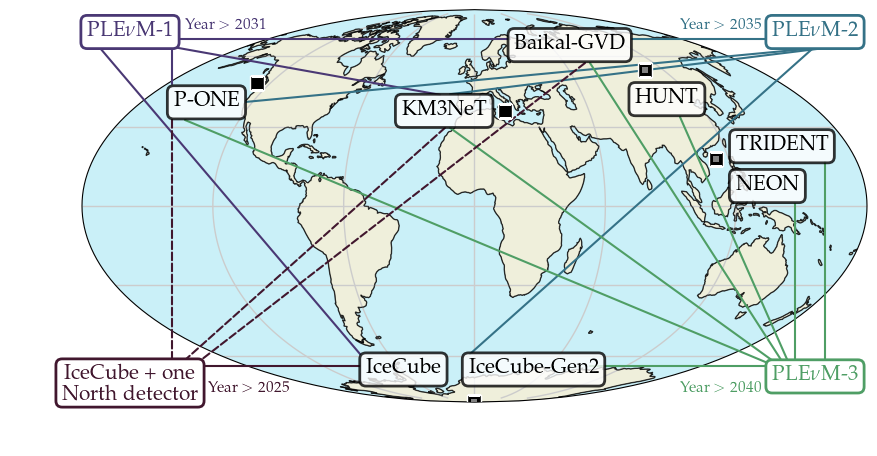

In [13]:
plenum_detectors = [
    "IceCube",
    "P-ONE",
    "KM3NeT",
    "Baikal-GVD",
    "Gen-2",
    "NEON",
    "TRIDENT",
    "HUNT",
]
for ii, clon in enumerate([0]):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.coastlines(color="k", alpha=0.7, lw=1)
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)
    ax.add_feature(cartopy.feature.OCEAN, facecolor=("#caf0f8"))
    ax.add_feature(cartopy.feature.LAND, edgecolor="black")

    for k in plenum_detectors:
        ax.scatter(
            poles[k]["lon"].value,
            poles[k]["lat"].value,
            # color=poles[k]["color"],
            color=(
                "0.5" if (k == "IceCube" or k == "NEON" or k == "Baikal-GVD") else "k"
            ),
            ec="w",
            lw=0 if (k == "IceCube" or k == "NEON" or k == "Baikal-GVD") else 1,
            marker="s",
            s=20 if (k == "IceCube" or k == "NEON" or k == "Baikal-GVD") else 100,
            transform=ccrs.PlateCarree(),
            label=k,
            zorder=11 if (k == "IceCube" or k == "NEON" or k == "Baikal-GVD") else 10,
        )
        # label
        x = poles[k]["lon"].value
        y = poles[k]["lat"].value + 8
        if k == "IceCube":
            x = poles[k]["lon"].value - 60
            y = poles[k]["lat"].value + 23
        elif k == "Gen-2":
            x = poles[k]["lon"].value + 48
            y = poles[k]["lat"].value + 23
        elif k == "HUNT":
            x = poles[k]["lon"].value - 3
            y = poles[k]["lat"].value - 12.5
        elif k == "TRIDENT":
            x = poles[k]["lon"].value + 34
            y = poles[k]["lat"].value + 5
        elif k == "NEON":
            x = poles[k]["lon"].value + 21
            y = poles[k]["lat"].value - 10
        elif k == "P-ONE":
            x = poles[k]["lon"].value - 17
            y = poles[k]["lat"].value - 8
        elif k == "KM3NeT":
            x = poles[k]["lon"].value - 32
            y = poles[k]["lat"].value + 0
        elif k == "Baikal-GVD":
            x = poles[k]["lon"].value - 32
            y = poles[k]["lat"].value + 12
        ax.text(
            x=x,
            y=y,
            s="IceCube-Gen2" if k == "Gen-2" else k,
            transform=ccrs.PlateCarree(),
            fontsize=15,
            fontweight="bold",
            ha="center",
            va="center",
            zorder=100,
            bbox=dict(boxstyle="round", fc=(1, 1, 1), linewidth=2, ec="k", alpha=0.8),
        )
    # ==== Labels for detector scenarios
    # === PLEnuM-1
    fig.text(
        x=0.22,
        y=0.84,
        s=r"PLE$\nu$M-1",
        color=plenum1_color,
        fontsize=15,
        fontweight="bold",
        ha="center",
        va="center",
        zorder=100,
        clip_on=False,
        bbox=dict(boxstyle="round", fc=(1, 1, 1), linewidth=2, ec=plenum1_color),
    )
    # == Comment
    fig.text(
        x=0.315,
        y=0.85,
        s=r"Year~$> 2031$",
        color=plenum1_color,
        fontsize=11,
        ha="center",
        va="center",
    )
    # == Line to IceCube
    ax.annotate(
        "",
        xy=(0.10, 0.68),
        xytext=(0.36, 0.17),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum1_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to P-ONE
    ax.annotate(
        "",
        xy=(0.172, 0.68),
        xytext=(0.172, 0.62),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum1_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to KM3NeT
    ax.annotate(
        "",
        xy=(0.145, 0.69),
        xytext=(0.44, 0.602),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum1_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to Baikal-GVD
    ax.annotate(
        "",
        xy=(0.15, 0.695),
        xytext=(0.51, 0.695),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum1_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )

    # === PLEnuM-2
    fig.text(
        x=0.905,
        y=0.84,
        s=r"PLE$\nu$M-2",
        color=plenum2_color,
        fontsize=15,
        fontweight="bold",
        ha="center",
        va="center",
        zorder=100,
        clip_on=False,
        bbox=dict(boxstyle="round", fc=(1, 1, 1), linewidth=2, ec=plenum2_color),
    )
    # == Comment
    fig.text(
        x=0.81,
        y=0.85,
        s=r"Year~$> 2035$",
        color=plenum2_color,
        fontsize=11,
        ha="center",
        va="center",
    )
    # == Line to Baikal-GVD
    ax.annotate(
        "",
        xy=(0.78, 0.695),
        xytext=(0.632, 0.695),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum2_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to P-ONE
    ax.annotate(
        "",
        xy=(0.81, 0.679),
        xytext=(0.245, 0.59),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum2_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to KM3NeT
    ax.annotate(
        "",
        xy=(0.82, 0.679),
        xytext=(0.45, 0.603),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum2_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to IceCube-Gen2
    ax.annotate(
        "",
        xy=(0.82, 0.69),
        xytext=(0.47, 0.17),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum2_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )

    # === PLEnuM-3
    fig.text(
        x=0.905,
        y=0.266,
        s=r"PLE$\nu$M-3",
        color=plenum3_color,
        fontsize=15,
        fontweight="bold",
        ha="center",
        va="center",
        zorder=100,
        clip_on=False,
        bbox=dict(boxstyle="round", fc=(1, 1, 1), linewidth=2, ec=plenum3_color),
    )
    # == Comment
    fig.text(
        x=0.81,
        y=0.245,
        s=r"Year~$> 2040$",
        color=plenum3_color,
        fontsize=11,
        ha="center",
        va="center",
    )
    # == Line to TRIDENT
    ax.annotate(
        "",
        xy=(0.825, 0.15),
        xytext=(0.825, 0.49),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to NEON
    ax.annotate(
        "",
        xy=(0.795, 0.15),
        xytext=(0.795, 0.42),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to HUNT
    ax.annotate(
        "",
        xy=(0.79, 0.15),
        xytext=(0.68, 0.565),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to Baikal-GVD
    ax.annotate(
        "",
        xy=(0.785, 0.15),
        xytext=(0.59, 0.655),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to KM3NeT
    ax.annotate(
        "",
        xy=(0.78, 0.15),
        xytext=(0.45, 0.547),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to P-ONE
    ax.annotate(
        "",
        xy=(0.775, 0.15),
        xytext=(0.185, 0.56),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to IceCube-Gen2
    ax.annotate(
        "",
        xy=(0.77, 0.15),
        xytext=(0.59, 0.15),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=plenum3_color,
            lw=1.5,
            linestyle="-",
            shrinkA=0,
            shrinkB=0,
        ),
    )

    # === IceCube + IC-North
    fig.text(
        x=0.22,
        y=0.255,
        s=r"\hspace*{-0.9em}IceCube + one\\[0.2em]North detector",
        color=icn_color,
        fontsize=15,
        fontweight="bold",
        ha="center",
        va="center",
        zorder=100,
        clip_on=False,
        bbox=dict(boxstyle="round", fc=(1, 1, 1), linewidth=2, ec=icn_color),
    )
    # == Comment
    fig.text(
        x=0.338,
        y=0.245,
        s=r"Year~$> 2025$",
        color=icn_color,
        fontsize=11,
        ha="center",
        va="center",
    )
    # == Line to IceCube
    ax.annotate(
        "",
        xy=(0.19, 0.15),
        xytext=(0.36, 0.15),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-", color=icn_color, lw=1.5, linestyle="-", shrinkA=0, shrinkB=0
        ),
    )
    # == Line to P-ONE
    ax.annotate(
        "",
        xy=(0.172, 0.16),
        xytext=(0.172, 0.56),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=icn_color,
            lw=1.5,
            linestyle="--",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to Baikal-GVD
    ax.annotate(
        "",
        xy=(0.201, 0.16),
        xytext=(0.585, 0.655),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=icn_color,
            lw=1.5,
            linestyle="--",
            shrinkA=0,
            shrinkB=0,
        ),
    )
    # == Line to KM3NeT
    ax.annotate(
        "",
        xy=(0.185, 0.16),
        xytext=(0.445, 0.547),
        xycoords="figure fraction",
        arrowprops=dict(
            arrowstyle="-",
            color=icn_color,
            lw=1.5,
            linestyle="--",
            shrinkA=0,
            shrinkB=0,
        ),
    )

    base_file = join(
        BASEPATH, f"plots/ngc_paper/detector_locations_map_greens"
    )  # _with_TRIDENT")
    fig.savefig(base_file + ".pdf", bbox_inches="tight")
    fig.savefig(base_file + ".png", bbox_inches="tight")

# flux models overview


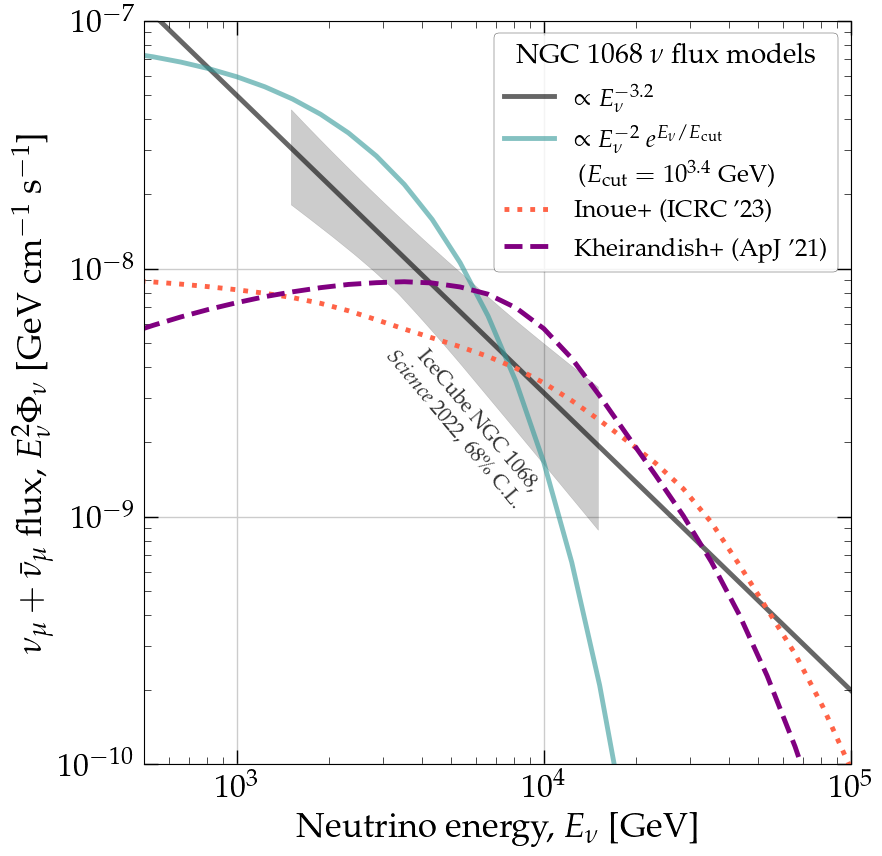

In [14]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

# pl = power_law(x_evals, ngc_pl0_flux.E0, ngc_pl0_flux.gamma, ngc_pl0_flux.norm)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, ax = plt.subplots(figsize=(9, 9))
fontsize = 25
# ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"$\propto E_\nu^{{-{st.GAMMA_NGC}}}$",
    color="k",
    alpha=0.6,
    lw=3.5,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    # label=rf"PL $\gamma=${st.Gamma_cut}"
    # + rf"$\times$ cut-off "
    # + "\n"
    # + rf"($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    label=r"\hspace*{-1.5em}$\propto E_\nu^{-2}~e^{E_\nu/E_{\rm cut}}$"
    + r"\\[0.2em]"
    + rf"\hspace*{{-0.5em}}($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut}}}$ GeV)",
    color="#339999",
    alpha=0.6,
    lw=3.5,
)

ax.set_yscale("log")
# ax.set_ylabel(
#     r"$E^2 {\rm d}\Phi_{\nu_\mu + \bar{\nu}_\mu} / {\rm d}E$ [GeV / cm² s]", fontsize=fontsize
# )
ax.set_ylabel(
    r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$E_\nu^2 \Phi_\nu$ " + r"[GeV~cm$^{-1}$~s$^{-1}$]",
    fontsize=fontsize,
)

ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-7)
ax.set_xlim(5e2, 1e5)


ax.plot(
    x_evals,
    10 ** (inoue_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="tomato",
    ls=":",
    label="Inoue+ (ICRC '23)",
    lw=3.5,
)

ax.plot(
    x_evals,
    10 ** (kheirandish_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="purple",
    ls="--",
    label="Kheirandish+ (ApJ '21)",
    lw=3.5,
)

l = ax.legend(
    frameon=True,
    loc="upper right",
    ncols=1,
    # bbox_to_anchor=(-0.15, 1.4),
    columnspacing=0.8,
    edgecolor="k",
    title=r"NGC 1068 $\nu$ flux models",
)
plt.setp(l.get_title(), fontsize="x-large")

ax.annotate(
    r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
    xy=(0.565, 0.46),
    xycoords="axes fraction",
    ha="right",
    va="center",
    zorder=10,
    color=font_color,
    fontsize=15, 
    rotation=-50
)

ax.tick_params(axis='both', which='major', labelsize=23)

f.savefig(join(st.BASEPATH, plot_path, "model_source_fluxes.pdf"), bbox_inches="tight")

# Atmospheric background flux

In [15]:
with open(join(st.BASEPATH, "resources/MCEq_daemonflux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)

In [16]:
zen[20:]


array([ 90.    ,  92.866 ,  95.7392,  98.6269, 101.537 , 104.4775,
       107.4576, 110.4873, 113.5782, 116.7437, 120.    , 123.367 ,
       126.8699, 130.5416, 134.427 , 138.5904, 143.1301, 148.2117,
       154.1581, 161.8051, 180.    ])

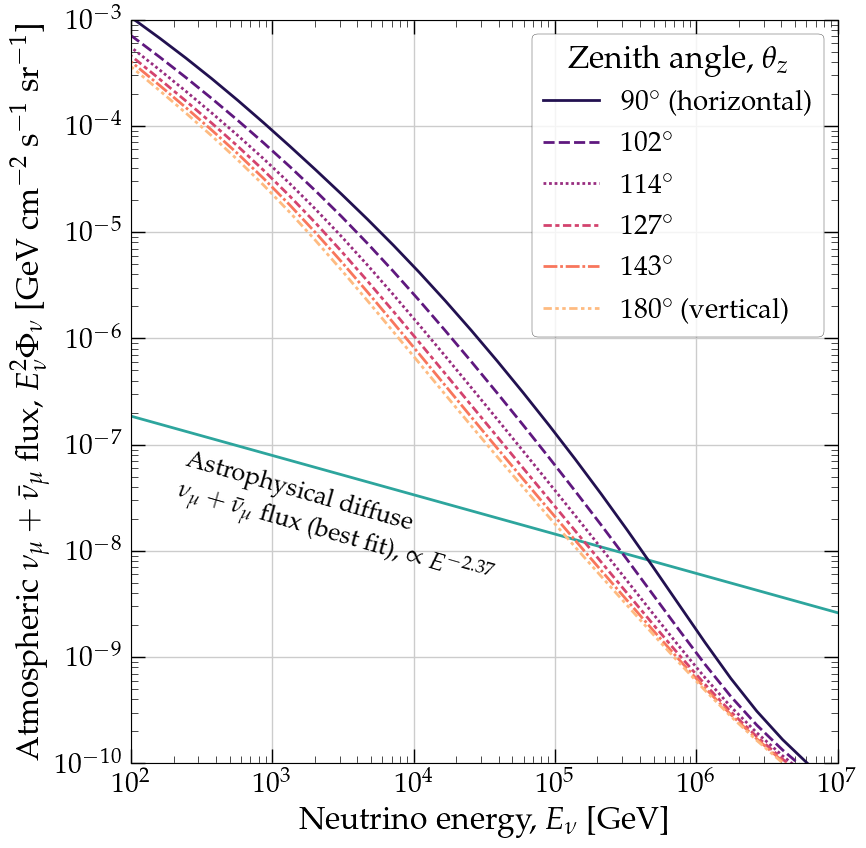

In [17]:
column_names = []
slicer = 4
zen_cut = 20  # 24
for z in zen[zen_cut::slicer]:
    if (z == 0.0) or (z == 180.0):
        label = rf"${z:1.0f}^\circ$ (vertical)"
    elif z == 90.0:
        label = rf"${z:1.0f}^\circ$ (horizontal)"
    else:
        label = rf"${z:1.0f}^\circ$"
    column_names.append(label)
    # column_names.append(rf"${z:1.0f}^\circ$")

energy_scaler = 2
scaled_bckg_flux = bckg_flux.T * (e_grid**energy_scaler)
df = pd.DataFrame(scaled_bckg_flux.T[:, zen_cut::slicer], columns=column_names)
df["E"] = e_grid
df.set_index("E", inplace=True)


f, ax = plt.subplots(figsize=(9, 9))
ax = sns.lineplot(data=df, palette="magma")
plt.loglog()
ax.set_xlim(1e2, 1e7)
if energy_scaler == 3:
    ax.set_ylim(1e-4, 0.2)
else:
    ax.set_ylim(1e-10, 1e-3)
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]", fontsize=23)
# ax.set_ylabel(
#     r"Atmospheric $\nu_\mu+\bar{\nu}_\mu$ flux, "
#     + "\n"
#     + rf"$E_\nu^{{{energy_scaler}}}"
#     + r" \Phi_\nu$ "
#     + r"[GeV~cm$^{-1}$~s$^{-1}$]"
# )
ax.set_ylabel(
    r"Atmospheric $\nu_\mu+\bar{\nu}_\mu$ flux, "
    + rf"$E_\nu^{{{energy_scaler}}}"
    + r"\Phi_\nu$ [GeV~cm$^{-2}$~s$^{-1}$~sr$^{-1}$]",
    fontsize=23,
)
ax.plot(
    e_grid,
    st.PHI_ASTRO * ((e_grid / 1e5) ** -st.GAMMA_ASTRO) * e_grid**energy_scaler,
    color=st.colors[1],
    zorder=1,
)  # spectrum from  R. Abbasi et al 2022 ApJ 928 50
ax.text(
    s="Astrophysical diffuse"
    + "\n"
    + r" $\nu_\mu+\bar{\nu}_\mu$ flux  (best fit), "
    + rf"$\propto E^{{{-st.GAMMA_ASTRO}}}$",
    x=2e2,
    y=1.9e-8,
    rotation=-16,
    va="center",
    fontsize=18,
)
ax.tick_params(axis="both", which="major", labelsize=20)

# ax.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, 1.4),
#     ncol=2,
#     frameon=False,
#     title="Zenith angle"
# )
ax.legend(
    loc="upper right",
    # bbox_to_anchor=(0.5, 1.4),
    ncol=1,
    frameon=True,
    title=r"Zenith angle, $\theta_z$",
    title_fontsize=23,
    edgecolor="k",
    fontsize=20,
)
f.savefig(
    join(st.BASEPATH, plot_path, "atmospheric_neutrino_spectrum.pdf"),
    bbox_inches="tight",
)

#  effective area & event rate
see Plenum/notebooks/demo/demo_plenum_effective_area.ipynb

## Preliminaries

In [18]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

In [19]:
with open(join(st.LOCALPATH, "inst_rel_events_ra_dec.pckl"), "rb") as f:
    rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)
# aeff_2d, _log_ebins, _ebins, _sindec_bins = get_aeff_and_binnings("upgoing")
# aeff_2d_full, log_ebins, ebins, sindec_bins = get_aeff_and_binnings("full")

rel_events_ra_dec[2].keys()
rel_events_ra_dec[2]["Plenum-1"] = (
    rel_events_ra_dec[2]["IceCube"]
    + rel_events_ra_dec[2]["P-ONE"]
    + rel_events_ra_dec[2]["KM3NeT"]
    + rel_events_ra_dec[2]["Baikal-GVD"]
)

rel_events_ra_dec[2]["Plenum-2"] = (
    rel_events_ra_dec[2]["IceCube"] * st.GEN2_FACTOR
    + rel_events_ra_dec[2]["P-ONE"]
    + rel_events_ra_dec[2]["KM3NeT"]
    + rel_events_ra_dec[2]["Baikal-GVD"]
)

rel_events_ra_dec[2]["Plenum-3"] = (
    rel_events_ra_dec[2]["IceCube"] * st.GEN2_FACTOR
    + rel_events_ra_dec[2]["P-ONE"]
    + rel_events_ra_dec[2]["KM3NeT"]
    + rel_events_ra_dec[2]["Baikal-GVD"]
    + rel_events_ra_dec[2]["NEON"] * st.NEON_FACTOR
    + rel_events_ra_dec[2]["HUNT"] * st.HUNT_FACTOR
    + rel_events_ra_dec[2]["TRIDENT"] * st.TRIDENT_FACTOR
)

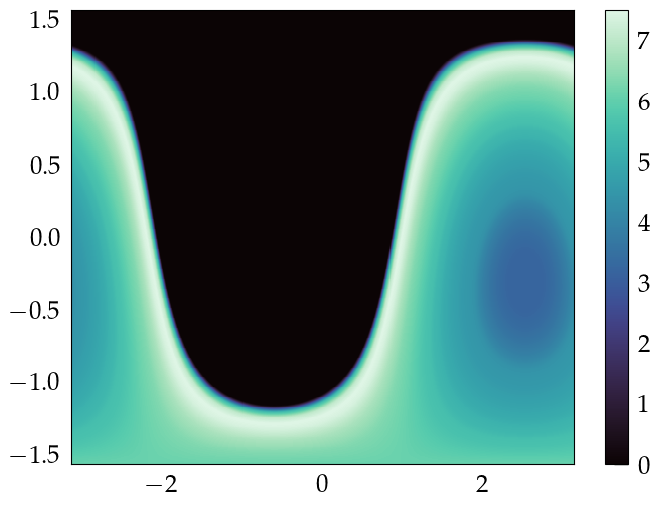

In [20]:
## CAUTION!! all event rates always normalized to 1 
# apply factor, if needed
plt.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["TRIDENT"] * st.TRIDENT_FACTOR,
    vmin=0,
    linewidth=0,
    rasterized=True,
)
plt.colorbar()

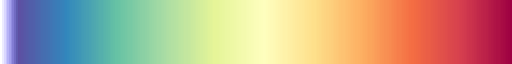

In [21]:
color_array_k = sns.cubehelix_palette(
    start=0, rot=0, light=1, dark=0.4, hue=1.2, n_colors=10
)

color_array_b = sns.color_palette("Spectral_r", n_colors=290)
_cmap = ListedColormap(np.concatenate([color_array_k, color_array_b]))
_cmap

## v3: Final plot of skymaps of event rates, selected detectors, including Fermi 4FGL source

In [18]:
import matplotlib.patheffects as pe
from astropy.io import fits

with fits.open(LOCALPATH+"/gll_psc_v35.fit") as fgl4:
    data_4FGL = fgl4[1].data

# skycoords_4FGL = SkyCoord(ra=data_4FGL['RAJ2000'], dec=data_4FGL['DEJ2000'], unit="deg", frame="fk5", obstime="J2000")
data_4FGL_ra = np.pi/180.*data_4FGL['RAJ2000']
data_4FGL_dec = np.pi/180.*data_4FGL['DEJ2000']

In [19]:
ngc_1068_ra = ngc1068.ra.rad
ngc_1068_dec = ngc1068.dec.rad
txs_0506_056_ra = txs0506.ra.rad
txs_0506_056_dec = txs0506.dec.rad
pks_1424_240_ra = np.pi/180. * 216.74746974
pks_1424_240_dec = np.pi/180. * 23.79436281 
gal_center_ra = sgr_a.icrs.ra.rad
gal_center_dec = sgr_a.icrs.dec.rad

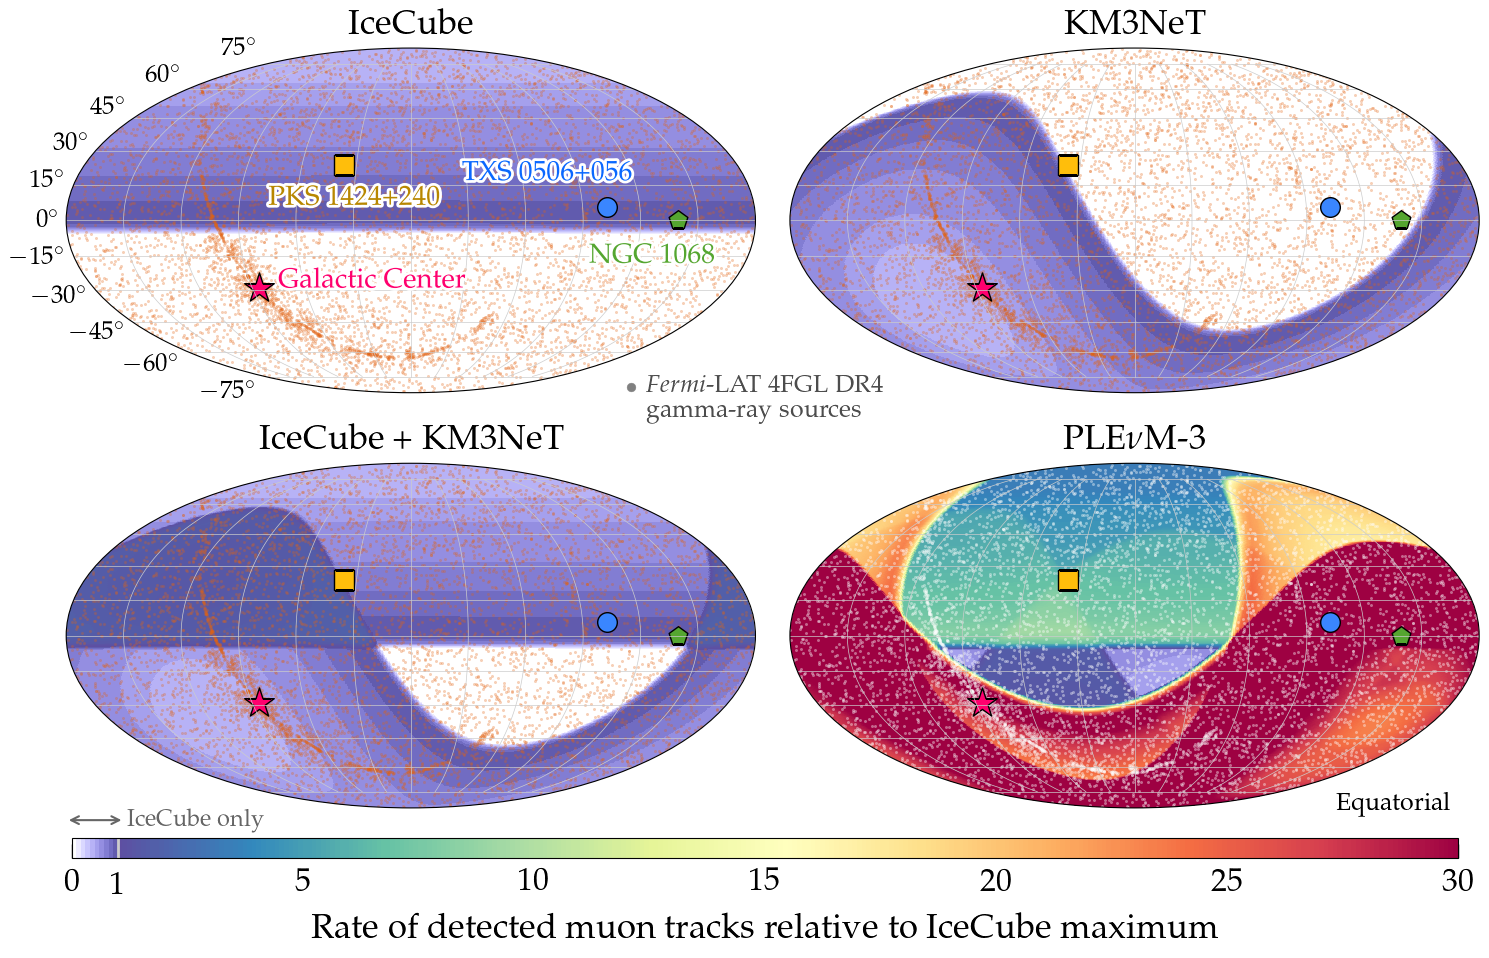

In [20]:
vmin, vmax = 0, 30
_grid_lw = 0.5
heights = [1.0, 1.0]
widths = [1.0, 1.0,]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(18, 10),
    # constrained_layout=True, 
    gridspec_kw=gs_kw,
    subplot_kw={'projection': 'mollweide'}
)
fig.subplots_adjust(hspace=0.01, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title(r"IceCube", fontsize=25, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
ax.scatter(np.pi-data_4FGL_ra, data_4FGL_dec, s=3, zorder=0.2, alpha=0.3, c='#e36414')
ax.scatter(np.pi-ngc_1068_ra, ngc_1068_dec, marker='p', s=200, zorder=0.3, alpha=1, c='#55a630' ,edgecolors='k', lw=1)
ax.scatter(np.pi-txs_0506_056_ra, txs_0506_056_dec, marker='o', s=200, zorder=0.3, alpha=1, c='#3a86ff' ,edgecolors='k', lw=1)
ax.scatter(np.pi-pks_1424_240_ra, pks_1424_240_dec, marker='s', s=200, zorder=0.3, alpha=1, c='#ffbe0b' ,edgecolors='k', lw=1)
ax.scatter(np.pi-gal_center_ra, gal_center_dec, marker='*', s=500, zorder=0.3, alpha=1, c='#ff006e' ,edgecolors='k', lw=1)
ax.grid(True, linewidth=_grid_lw)
# ax.set_xticks([])
ax.set_xticklabels([])
tick_labels_y = np.array([r'$-75^\circ$', r'$-60^\circ$', r'$-45^\circ$', r'$-30^\circ$', r'$-15^\circ$',
                          r'$0^\circ$', r'$15^\circ$', r'$30^\circ$', r'$45^\circ$', r'$60^\circ$', r'$75^\circ$'])
ax.set_yticklabels(tick_labels_y, zorder = 15, fontsize=18)

# KM3NeT
ax = axes[0][1]
ax.set_title("KM3NeT", fontsize=25, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
ax.scatter(np.pi-data_4FGL_ra, data_4FGL_dec, s=3, zorder=0.2, alpha=0.3, c='#e36414')
ax.scatter(np.pi-ngc_1068_ra, ngc_1068_dec, marker='p', s=200, zorder=0.3, alpha=1, c='#55a630' ,edgecolors='k', lw=1)
ax.scatter(np.pi-txs_0506_056_ra, txs_0506_056_dec, marker='o', s=200, zorder=0.3, alpha=1, c='#3a86ff' ,edgecolors='k', lw=1)
ax.scatter(np.pi-pks_1424_240_ra, pks_1424_240_dec, marker='s', s=200, zorder=0.3, alpha=1, c='#ffbe0b' ,edgecolors='k', lw=1)
ax.scatter(np.pi-gal_center_ra, gal_center_dec, marker='*', s=500, zorder=0.3, alpha=1, c='#ff006e' ,edgecolors='k', lw=1)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# IceCube + KM3NeT
ax = axes[1][0]
ax.set_title("IceCube + KM3NeT", fontsize=25, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"]
    + rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
ax.scatter(np.pi-data_4FGL_ra, data_4FGL_dec, s=3, zorder=0.2, alpha=0.3, c='#e36414')
ax.scatter(np.pi-ngc_1068_ra, ngc_1068_dec, marker='p', s=200, zorder=0.3, alpha=1, c='#55a630' ,edgecolors='k', lw=1)
ax.scatter(np.pi-txs_0506_056_ra, txs_0506_056_dec, marker='o', s=200, zorder=0.3, alpha=1, c='#3a86ff' ,edgecolors='k', lw=1)
ax.scatter(np.pi-pks_1424_240_ra, pks_1424_240_dec, marker='s', s=200, zorder=0.3, alpha=1, c='#ffbe0b' ,edgecolors='k', lw=1)
ax.scatter(np.pi-gal_center_ra, gal_center_dec, marker='*', s=500, zorder=0.3, alpha=1, c='#ff006e' ,edgecolors='k', lw=1)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-3
ax = axes[1][1]
ax.set_title(r"PLE$\nu$M-3", fontsize=25, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-3"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
ax.scatter(np.pi-data_4FGL_ra, data_4FGL_dec, s=3, zorder=0.2, alpha=0.4, c='w')
ax.scatter(np.pi-ngc_1068_ra, ngc_1068_dec, marker='p', s=200, zorder=0.3, alpha=1, c='#55a630' ,edgecolors='k', lw=1)
ax.scatter(np.pi-txs_0506_056_ra, txs_0506_056_dec, marker='o', s=200, zorder=0.3, alpha=1, c='#3a86ff' ,edgecolors='k', lw=1)
ax.scatter(np.pi-pks_1424_240_ra, pks_1424_240_dec, marker='s', s=200, zorder=0.3, alpha=1, c='#ffbe0b' ,edgecolors='k', lw=1)
ax.scatter(np.pi-gal_center_ra, gal_center_dec, marker='*', s=500, zorder=0.3, alpha=1, c='#ff006e' ,edgecolors='k', lw=1)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# Common x-axis, y-axis labels
axes = np.append(axes, fig.add_subplot(111, projection="rectilinear", visible=True))
axes[-1].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes[-1].grid(False)
axes[-1].set_xlim(0, 1)
axes[-1].set_ylim(0, 1)
axes[-1].patch.set_alpha(0)
axes[-1].set_axis_off()
axes[-1].annotate('Equatorial', xy = (0.98, 0.045), xycoords='axes fraction', ha='right', va='center',
                  c='k', fontsize=18, zorder=100, clip_on=False)
axes[-1].scatter(0.4, 0.55, s=40, c='0.5')
axes[-1].annotate(r'{\it Fermi}-LAT 4FGL DR4', xy = (0.41, 0.55), xycoords='axes fraction', ha='left', va='center',
                  c='0.3', fontsize=18, zorder=100, clip_on=False)
axes[-1].annotate(r'gamma-ray sources', xy = (0.41, 0.52), xycoords='axes fraction', ha='left', va='center',
                  c='0.3', fontsize=18, zorder=100, clip_on=False)
axes[-1].text(0.15, 0.67, r'Galactic Center', c='#ff006e', fontsize=20,
              path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])
axes[-1].text(0.37, 0.70, r'NGC 1068', c='#55a630', fontsize=20,
              path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])
axes[-1].text(0.28, 0.80, r'TXS 0506+056', c='#0A68FF', fontsize=20,
              path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])
axes[-1].text(0.143, 0.77, r'PKS 1424+240', c='#B88700', fontsize=20,
              path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])

# Common colorbar
cbax = fig.add_axes([0.175, 0.12, 0.77, 0.02])
cb = fig.colorbar(p, cax=cbax, orientation='horizontal')
cb.set_label(r"Rate of detected muon tracks relative to IceCube maximum", fontsize=25, labelpad=10)
cbax.tick_params(axis='both', which='major', labelsize=23)
cb.ax.axvline(1, color="0.8")
cb.ax.annotate(
    "", xy=(-0.004, 1.9), xytext=(0.038, 1.9), xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
cb.ax.text(0.04, 1.6, "IceCube only", c='0.4', fontsize=17, transform=cb.ax.transAxes)
cb.ax.text(0.028, -1.8, "1", c='k', fontsize=23, transform=cb.ax.transAxes)

fig.savefig(
    join(st.BASEPATH, plot_path, "event_rate_skymap_selected_4fgl_sources.pdf"), bbox_inches='tight', dpi=300
)
fig.savefig(
    join(st.BASEPATH, plot_path, "event_rate_skymap_selected_4fgl_sources.png"), bbox_inches='tight', dpi=300
)

## v3: Final plot of skymaps of event rates, including Fermi 4FGL source

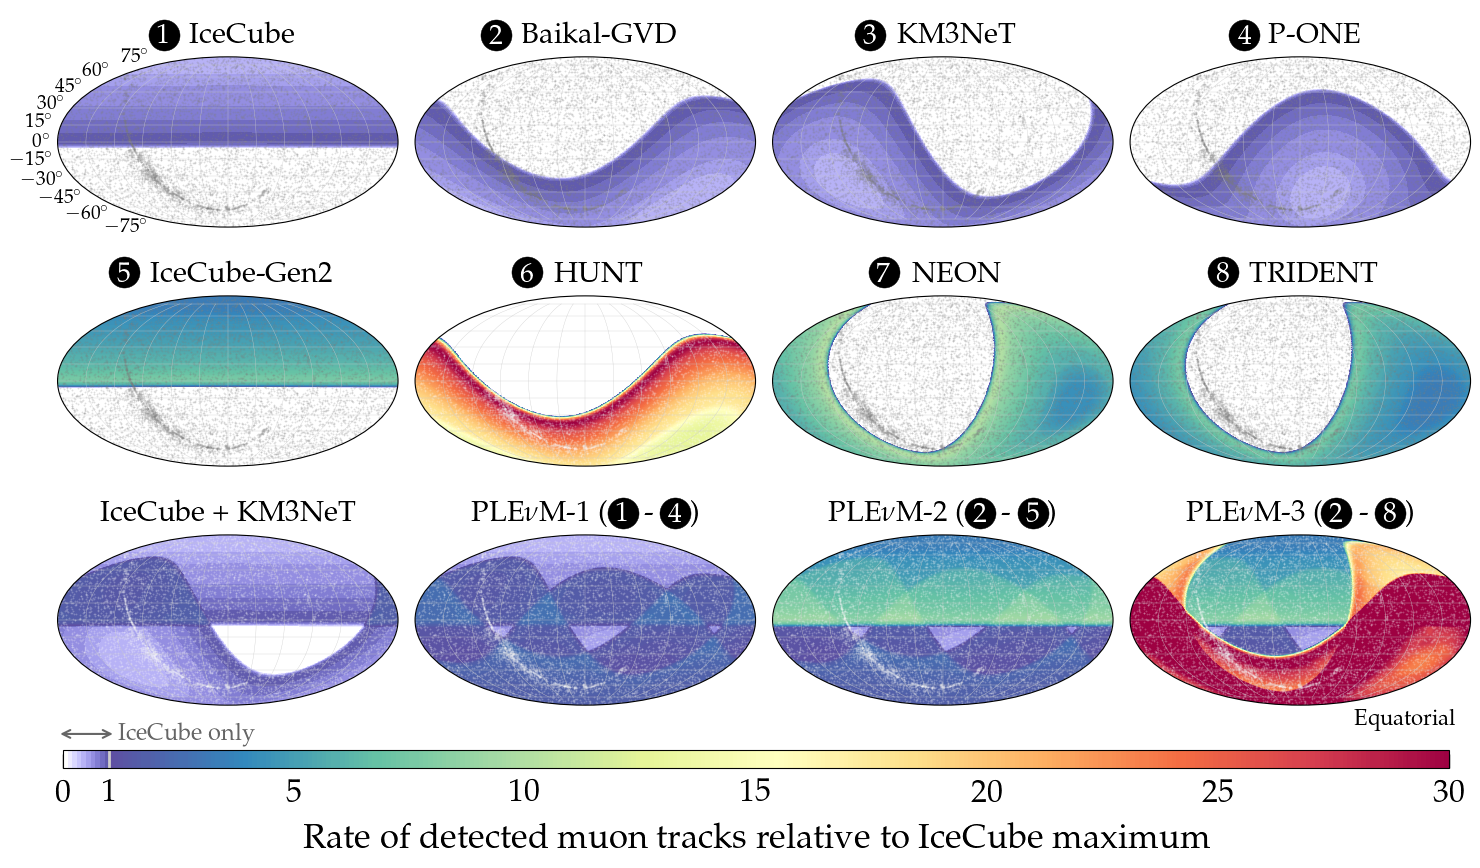

In [21]:

# matplotlib.rcParams["mathtext.fallback"]='stix'
_grid_lw = 0.25
vmin, vmax = 0, 30

heights = [1.0, 1.0, 1.0]
widths = [1.0, 1.0, 1.0, 1.0]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(18, 9),
    # constrained_layout=True,
    gridspec_kw=gs_kw,
    subplot_kw={"projection": "mollweide"},
)
fig.subplots_adjust(hspace=-0.1, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title(r"1~~IceCube", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
# ax.set_xticks([])
ax.set_xticklabels([])
tick_labels_y = np.array(
    [
        r"$-75^\circ$",
        r"$-60^\circ$",
        r"$-45^\circ$",
        r"$-30^\circ$",
        r"$-15^\circ$",
        r"$0^\circ$",
        r"$15^\circ$",
        r"$30^\circ$",
        r"$45^\circ$",
        r"$60^\circ$",
        r"$75^\circ$",
    ]
)
ax.set_yticklabels(tick_labels_y, zorder=15, fontsize=14)

# Baikal-GVD
ax = axes[0][1]
ax.set_title("1~~Baikal-GVD", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Baikal-GVD"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# KM3NeT
ax = axes[0][2]
ax.set_title("1~~KM3NeT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# P-ONE
ax = axes[0][3]
ax.set_title("1~~P-ONE", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["P-ONE"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# IceCube-Gen2
ax = axes[1][0]
ax.set_title("1~~IceCube-Gen2", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    # rel_events_ra_dec[2]["Gen-2"],
    rel_events_ra_dec[2]["IceCube"] * st.GEN2_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# HUNT
ax = axes[1][1]
ax.set_title("1~~HUNT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["HUNT"] * st.HUNT_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="w")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# NEON
ax = axes[1][2]
ax.set_title("1~~NEON", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["NEON"] * st.NEON_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# TRIDENT
ax = axes[1][3]
ax.set_title("1~~TRIDENT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["TRIDENT"] * st.TRIDENT_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="0.5")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# IceCube + KM3NeT
ax = axes[2][0]
ax.set_title("IceCube + KM3NeT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"] + rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="w")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-1
ax = axes[2][1]
ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-1"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="w")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-2
ax = axes[2][2]
ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-2"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="w")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-3
ax = axes[2][3]
ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-3"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.scatter(np.pi - data_4FGL_ra, data_4FGL_dec, s=1, zorder=0.2, alpha=0.2, c="w")
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# Common x-axis, y-axis labels
axes = np.append(axes, fig.add_subplot(111, projection="rectilinear", visible=True))
axes[-1].tick_params(
    labelcolor="none", top=False, bottom=False, left=False, right=False
)
axes[-1].grid(False)
axes[-1].set_xlim(0, 1)
axes[-1].set_ylim(0, 1)
axes[-1].patch.set_alpha(0)
axes[-1].set_axis_off()
axes[-1].scatter(0.075, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "1",
    xy=(0.075, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.31, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.31, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.575, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "3",
    xy=(0.575, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.84, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "4",
    xy=(0.84, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.047, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "5",
    xy=(0.047, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.332, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "6",
    xy=(0.332, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.585, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "7",
    xy=(0.585, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.825, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "8",
    xy=(0.825, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.40, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].scatter(0.437, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "1",
    xy=(0.40, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].annotate(
    "4",
    xy=(0.437, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.653, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.653, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.69, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "5",
    xy=(0.69, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.905, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.905, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.943, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "8",
    xy=(0.943, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].annotate(
    "Equatorial",
    xy=(0.99, 0.045),
    xycoords="axes fraction",
    ha="right",
    va="center",
    c="k",
    fontsize=16,
    zorder=100,
    clip_on=False,
)

# Common colorbar
cbax = fig.add_axes([0.175, 0.12, 0.77, 0.02])
cb = fig.colorbar(p, cax=cbax, orientation="horizontal")
cb.set_label(
    r"Rate of detected muon tracks relative to IceCube maximum",
    fontsize=25,
    labelpad=10,
)
cbax.tick_params(axis="both", which="major", labelsize=23)
cb.ax.axvline(1, color="0.8")
cb.ax.annotate(
    "",
    xy=(-0.004, 1.9),
    xytext=(0.038, 1.9),
    xycoords="axes fraction",
    annotation_clip=None,
    arrowprops=dict(arrowstyle="<->", color="0.4", linewidth=1.5),
)
cb.ax.text(0.04, 1.6, "IceCube only", c="0.4", fontsize=17, transform=cb.ax.transAxes)
cb.ax.text(0.028, -1.8, "1", c="k", fontsize=23, transform=cb.ax.transAxes)

fig.savefig(
    join(st.BASEPATH, plot_path, "event_rate_skymap_all_4fgl_sources.pdf"),
    bbox_inches="tight",
    dpi=300,
)

## v2: Final plot of skymaps of event rates

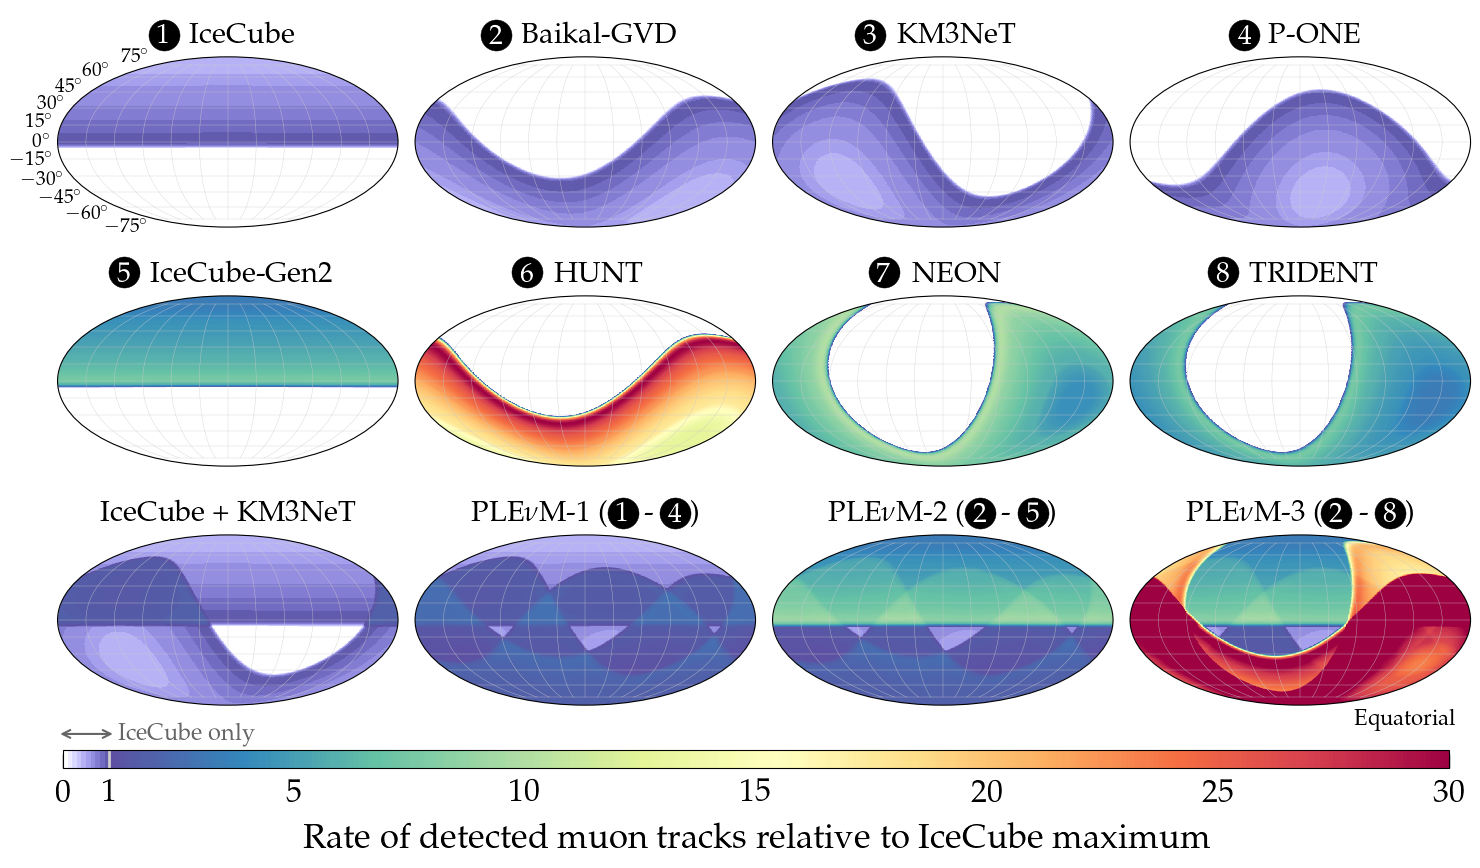

In [22]:
# from tools import add_plane
# import cartopy.crs as ccrs

# matplotlib.rcParams["mathtext.fallback"]='stix'

vmin, vmax = 0, 30

heights = [1.0, 1.0, 1.0]
widths = [1.0, 1.0, 1.0, 1.0]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(18, 9),
    # constrained_layout=True,
    gridspec_kw=gs_kw,
    subplot_kw={"projection": "mollweide"},
)
fig.subplots_adjust(hspace=-0.1, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title(r"1~~IceCube", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
# ax.set_xticks([])
ax.set_xticklabels([])
tick_labels_y = np.array(
    [
        r"$-75^\circ$",
        r"$-60^\circ$",
        r"$-45^\circ$",
        r"$-30^\circ$",
        r"$-15^\circ$",
        r"$0^\circ$",
        r"$15^\circ$",
        r"$30^\circ$",
        r"$45^\circ$",
        r"$60^\circ$",
        r"$75^\circ$",
    ]
)
ax.set_yticklabels(tick_labels_y, zorder=15, fontsize=14)

# Baikal-GVD
ax = axes[0][1]
ax.set_title("1~~Baikal-GVD", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Baikal-GVD"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# KM3NeT
ax = axes[0][2]
ax.set_title("1~~KM3NeT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# P-ONE
ax = axes[0][3]
ax.set_title("1~~P-ONE", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["P-ONE"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# IceCube-Gen2
ax = axes[1][0]
ax.set_title("1~~IceCube-Gen2", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    # rel_events_ra_dec[2]["Gen-2"],
    rel_events_ra_dec[2]["IceCube"] * st.GEN2_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# HUNT
ax = axes[1][1]
ax.set_title("1~~HUNT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["HUNT"] * st.HUNT_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# NEON
ax = axes[1][2]
ax.set_title("1~~NEON", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["NEON"] * st.NEON_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# TRIDENT
ax = axes[1][3]
ax.set_title("1~~TRIDENT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["TRIDENT"] * st.TRIDENT_FACTOR,
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# IceCube + KM3NeT
ax = axes[2][0]
ax.set_title("IceCube + KM3NeT", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["IceCube"] + rel_events_ra_dec[2]["KM3NeT"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-1
ax = axes[2][1]
ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-1"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-2
ax = axes[2][2]
ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-2"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# PLEnuM-3
ax = axes[2][3]
ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=21, pad=10)
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events_ra_dec[2]["Plenum-3"],
    vmin=vmin,
    vmax=vmax,
    cmap=_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.2,
)
ax.grid(True, linewidth=_grid_lw)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# Common x-axis, y-axis labels
axes = np.append(axes, fig.add_subplot(111, projection="rectilinear", visible=True))
axes[-1].tick_params(
    labelcolor="none", top=False, bottom=False, left=False, right=False
)
axes[-1].grid(False)
axes[-1].set_xlim(0, 1)
axes[-1].set_ylim(0, 1)
axes[-1].patch.set_alpha(0)
axes[-1].set_axis_off()
axes[-1].scatter(0.075, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "1",
    xy=(0.075, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.31, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.31, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.575, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "3",
    xy=(0.575, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.84, 0.965, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "4",
    xy=(0.84, 0.962),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.047, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "5",
    xy=(0.047, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.332, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "6",
    xy=(0.332, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.585, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "7",
    xy=(0.585, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.825, 0.646, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "8",
    xy=(0.825, 0.643),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.40, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].scatter(0.437, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "1",
    xy=(0.40, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].annotate(
    "4",
    xy=(0.437, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.653, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.653, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.69, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "5",
    xy=(0.69, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.905, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "2",
    xy=(0.905, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].scatter(0.943, 0.322, s=500, marker="o", c="k", clip_on=False, zorder=0)
axes[-1].annotate(
    "8",
    xy=(0.943, 0.320),
    xycoords="axes fraction",
    ha="center",
    va="center",
    c="w",
    fontsize=20,
    zorder=100,
    clip_on=False,
)
axes[-1].annotate(
    "Equatorial",
    xy=(0.99, 0.045),
    xycoords="axes fraction",
    ha="right",
    va="center",
    c="k",
    fontsize=16,
    zorder=100,
    clip_on=False,
)

# Common colorbar
cbax = fig.add_axes([0.175, 0.12, 0.77, 0.02])
cb = fig.colorbar(p, cax=cbax, orientation="horizontal")
cb.set_label(
    r"Rate of detected muon tracks relative to IceCube maximum",
    fontsize=25,
    labelpad=10,
)
cbax.tick_params(axis="both", which="major", labelsize=23)
cb.ax.axvline(1, color="0.8")
cb.ax.annotate(
    "",
    xy=(-0.004, 1.9),
    xytext=(0.038, 1.9),
    xycoords="axes fraction",
    annotation_clip=None,
    arrowprops=dict(arrowstyle="<->", color="0.4", linewidth=1.5),
)
cb.ax.text(0.04, 1.6, "IceCube only", c="0.4", fontsize=17, transform=cb.ax.transAxes)
cb.ax.text(0.028, -1.8, "1", c="k", fontsize=23, transform=cb.ax.transAxes)

fig.savefig(
    join(st.BASEPATH, plot_path, "event_rate_skymap_all.pdf"),
    bbox_inches="tight",
    dpi=300,
)

## v2: Final plot of effective area

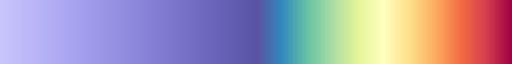

In [32]:
color_array_k = sns.cubehelix_palette(
    start=0, rot=0, light=0.8, dark=0.37, hue=1.2, n_colors=200
)

color_array_b = sns.color_palette("Spectral_r", n_colors=200)
_cmap2 = ListedColormap(np.concatenate([color_array_k, color_array_b]))
_cmap2

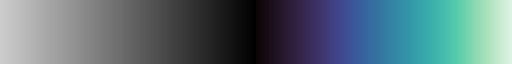

In [45]:
color_array_k = sns.cubehelix_palette(
    start=0, rot=0, light=0.8, dark=0, hue=0, n_colors=200
)

color_array_b = sns.color_palette("mako", n_colors=200)
_cmap2 = ListedColormap(np.concatenate([color_array_k, color_array_b]))
_cmap2

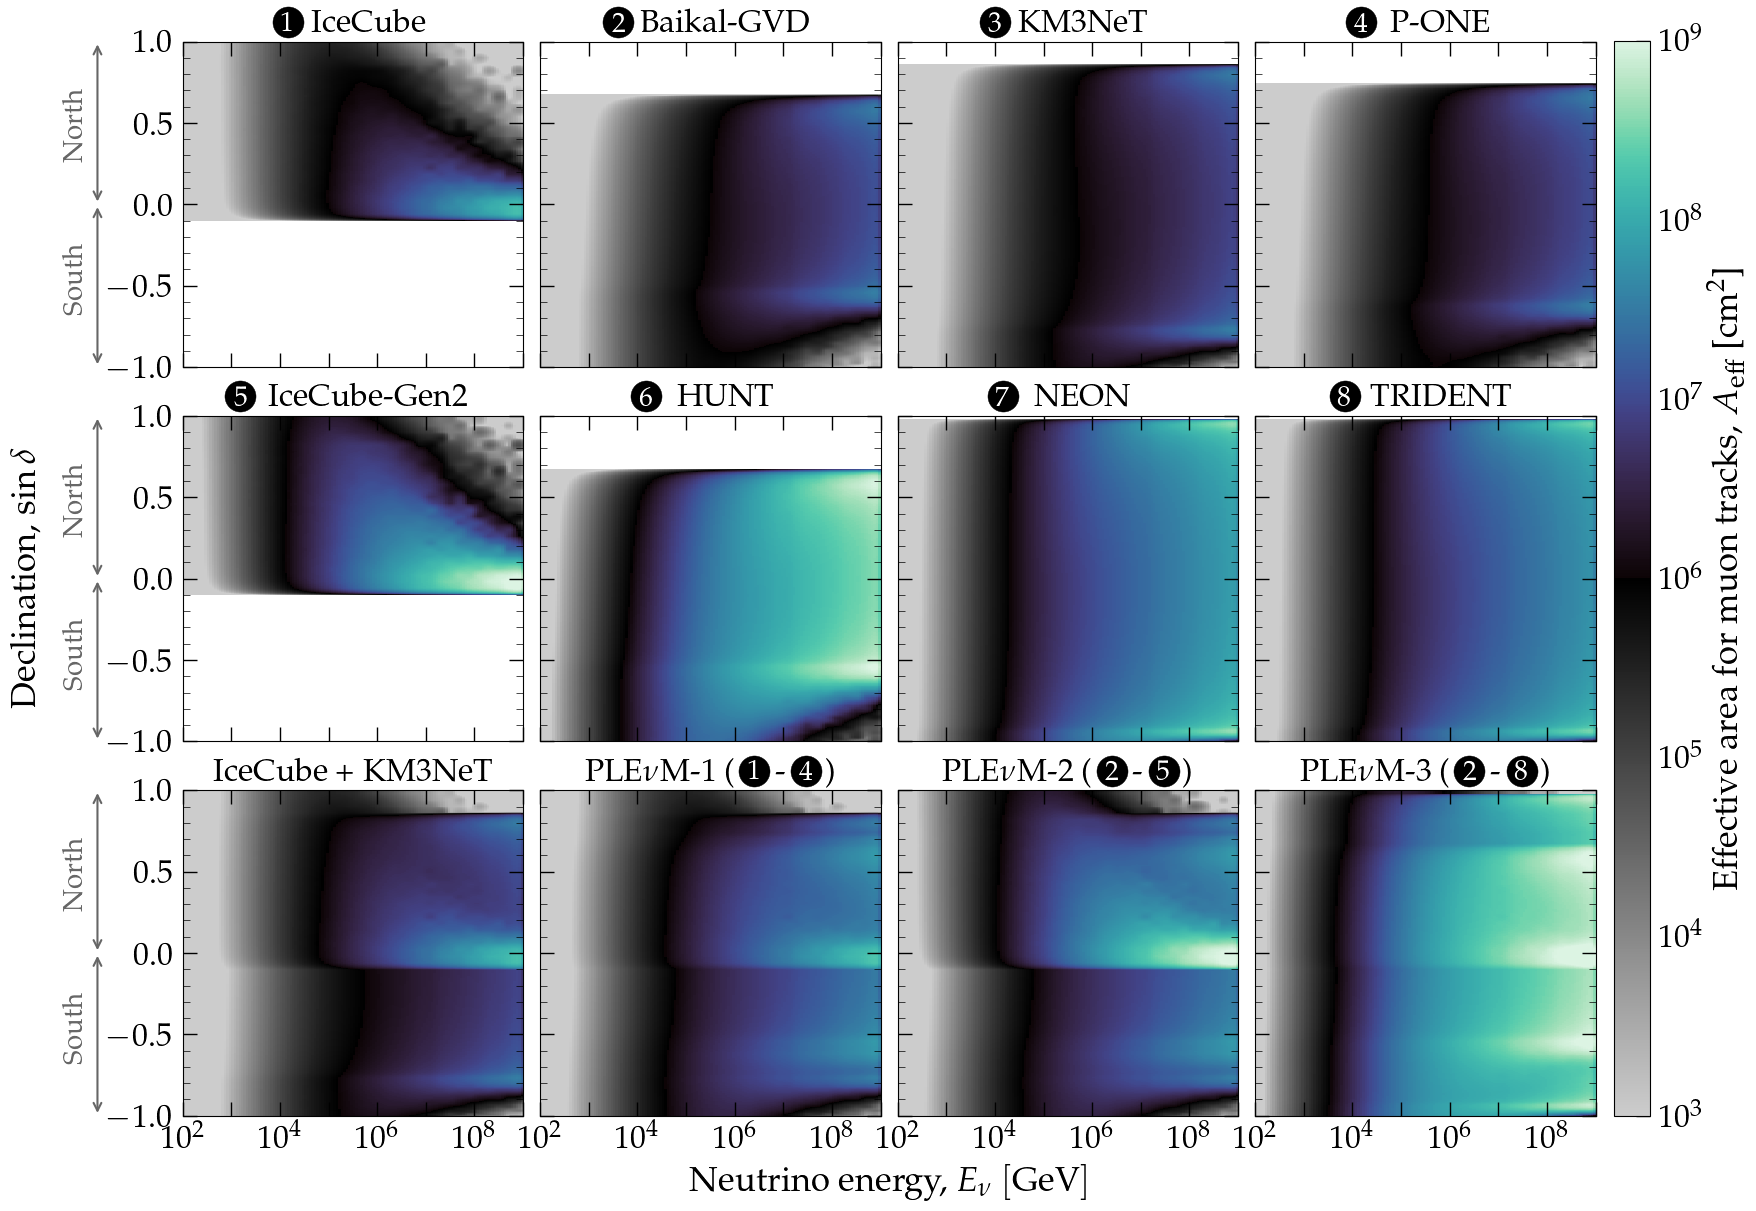

In [46]:
# vertical plot -  effective area only
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=14))
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=100))
ecap_listed_cmap = _cmap2 #st.ListedColormap(sns.color_palette("mako", n_colors=1000))

log_col = LogNorm(
    vmin=1e3,
    vmax=1e9,
)

heights = [1.0, 1.0, 1.0]
widths = [1.0, 1.0, 1.0, 1.0]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(18, 13),
    # constrained_layout=True, 
    gridspec_kw=gs_kw
)
fig.subplots_adjust(hspace=0.15, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title("1~~IceCube", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["IceCube"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# Baikal-GVD
ax = axes[0][1]
ax.set_title("1~~Baikal-GVD", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Baikal-GVD"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    0.4e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.232, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# KM3NeT
ax = axes[0][2]
ax.set_title("1~~KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["KM3NeT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '3',
    xy = (0.285, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# P-ONE
ax = axes[0][3]
ax.set_title("1~~P-ONE", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["P-ONE"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '4',
    xy = (0.312, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube-Gen2
ax = axes[1][0]
ax.set_title("1~~IceCube-Gen2", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Gen-2"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '5',
    xy = (0.17, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# HUNT
ax = axes[1][1]
ax.set_title("1~~HUNT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["HUNT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '6',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# NEON
ax = axes[1][2]
ax.set_title("1~~NEON", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["NEON"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '7',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# TRIDENT
ax = axes[1][3]
ax.set_title("1~~TRIDENT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["TRIDENT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    7e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '8',
    xy = (0.26, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube + KM3NeT
ax = axes[2][0]
ax.set_title("IceCube + KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# PLEnuM-1
ax = axes[2][1]
ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '4',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-2
ax = axes[2][2]
ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '5',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-3
ax = axes[2][3]
ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
        + aeff_2d["NEON"]
        + aeff_2d["HUNT"]
        + aeff_2d["TRIDENT"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '8',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# Formatting
for i in range(3):
    for j in range(4):
        axes[i][j].grid(False)
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim(1.e2, 1.e9)
        axes[i][j].set_ylim(-1.0, 1.0)
        axes[i][j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        axes[i][j].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
        axes[i][j].xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
        axes[i][j].tick_params(axis='both', which='major', labelsize=23)
        if (i != 2):
            axes[i][j].xaxis.set_ticklabels([])
        else:
            # axes[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[1.e2, 1.e4, 1.e6, 1.e8]))
            axes[i][j].xaxis.set_ticklabels(['', r'$10^2$', '', r'$10^4$', '', r'$10^6$', '', r'$10^8$', ''])
        if (j != 0):
            axes[i][j].yaxis.set_ticklabels([])

# Common x-axis, y-axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Neutrino energy, $E_\nu~[{\rm GeV}]$', labelpad=10, fontsize=25)
plt.ylabel(r'Declination, $\sin \delta$', labelpad=70, fontsize=25)
plt.grid(False)

# Common colorbar
cbax = fig.add_axes([0.967, 0.137, 0.02, 0.827])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"Effective area for muon tracks, $A_{\rm eff}$~[cm$^2$]", fontsize=25)
cbax.tick_params(axis='both', which='major', labelsize=23)

# for ax in axes:
#     ax.set_ylabel(r"Declination $\sin(\delta)$")
#     ax.tick_params(direction="out", top=False, right=False)

# fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# fig.subplots_adjust(right=0.88)
fig.savefig(
    join(st.BASEPATH, plot_path, "aeff_upgoing_all.pdf"), bbox_inches='tight', dpi=300
)

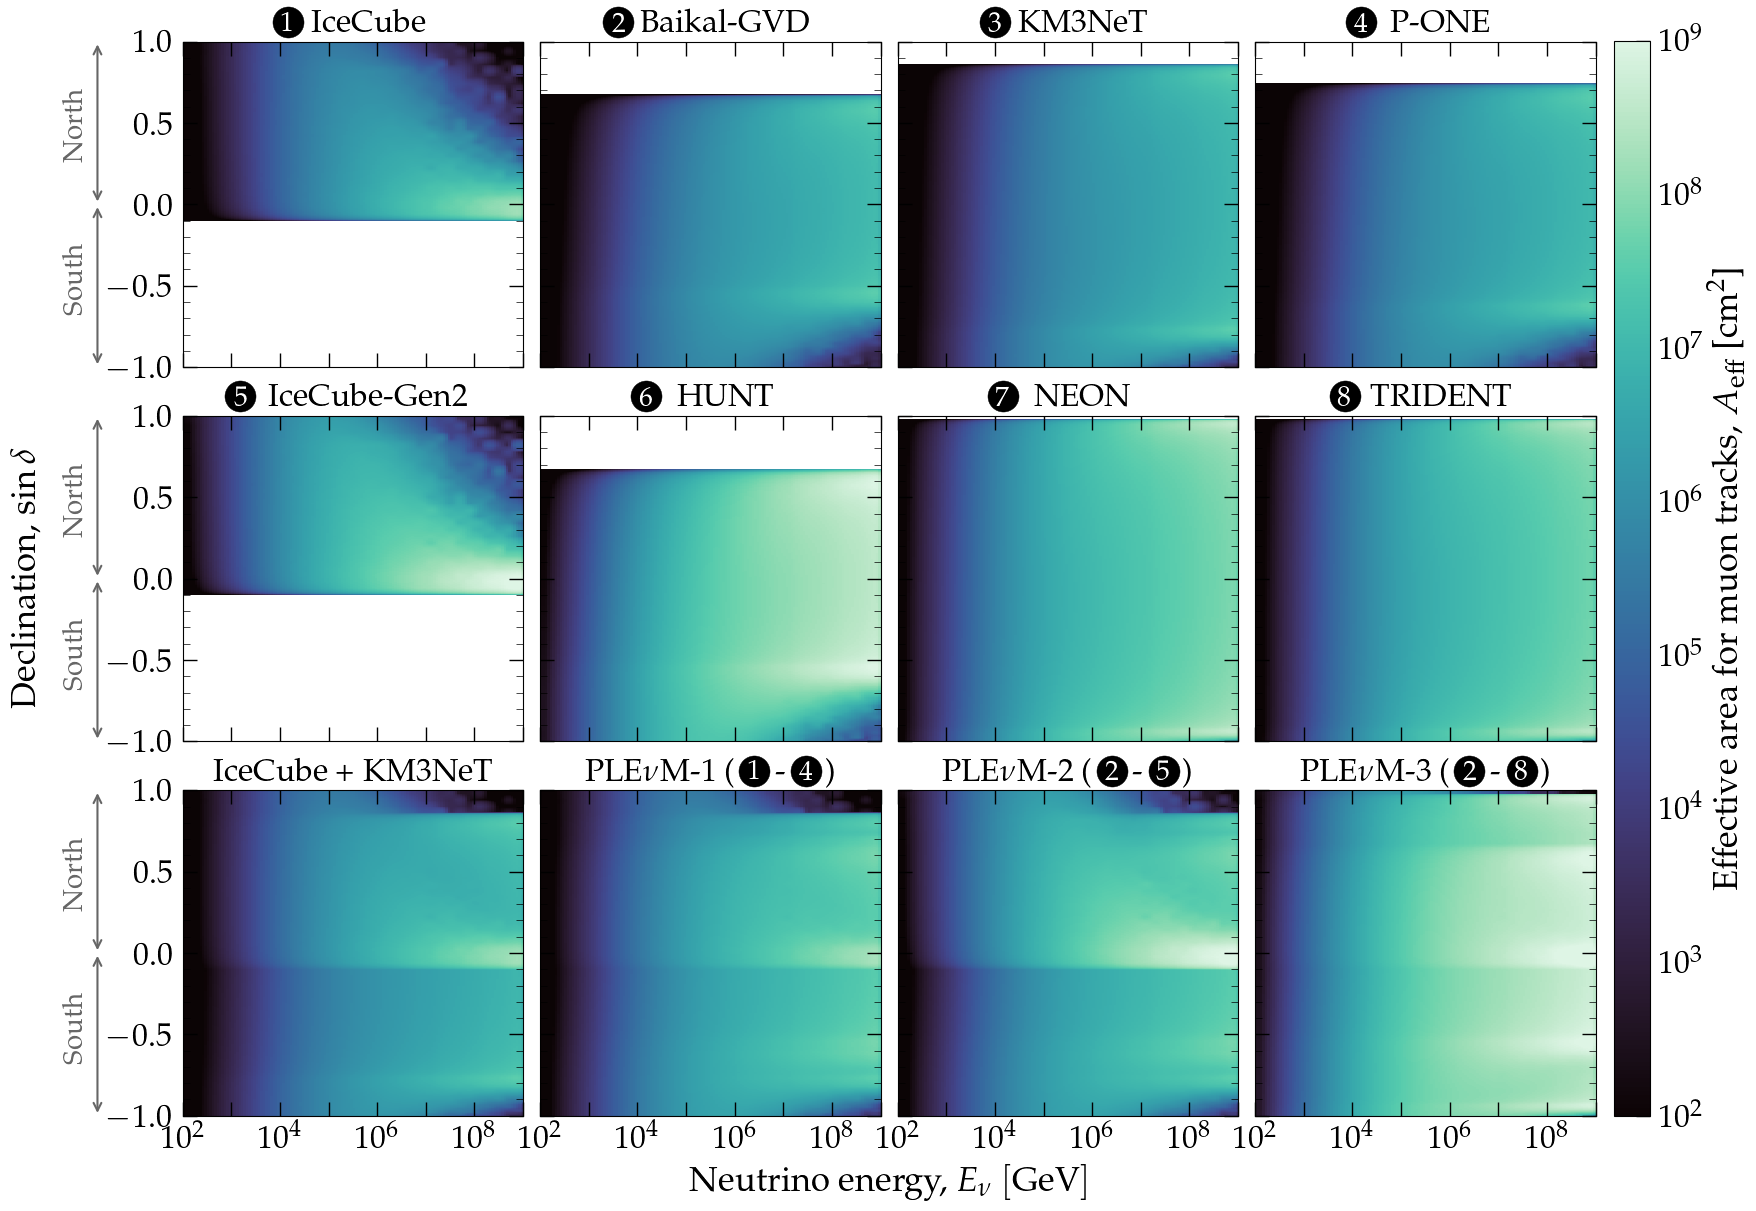

In [ ]:
# vertical plot -  effective area only
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=14))
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=100))
ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=1000))

log_col = LogNorm(
    vmin=1e2,
    vmax=1e9,
)

heights = [1.0, 1.0, 1.0]
widths = [1.0, 1.0, 1.0, 1.0]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(18, 13),
    # constrained_layout=True, 
    gridspec_kw=gs_kw
)
fig.subplots_adjust(hspace=0.15, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title("1~~IceCube", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["IceCube"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# Baikal-GVD
ax = axes[0][1]
ax.set_title("1~~Baikal-GVD", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Baikal-GVD"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    0.4e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.232, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# KM3NeT
ax = axes[0][2]
ax.set_title("1~~KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["KM3NeT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '3',
    xy = (0.285, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# P-ONE
ax = axes[0][3]
ax.set_title("1~~P-ONE", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["P-ONE"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '4',
    xy = (0.312, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube-Gen2
ax = axes[1][0]
ax.set_title("1~~IceCube-Gen2", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Gen-2"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '5',
    xy = (0.17, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# HUNT
ax = axes[1][1]
ax.set_title("1~~HUNT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["HUNT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '6',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# NEON
ax = axes[1][2]
ax.set_title("1~~NEON", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["NEON"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '7',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# TRIDENT
ax = axes[1][3]
ax.set_title("1~~TRIDENT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["TRIDENT"],
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    7e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '8',
    xy = (0.26, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube + KM3NeT
ax = axes[2][0]
ax.set_title("IceCube + KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# PLEnuM-1
ax = axes[2][1]
ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '4',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-2
ax = axes[2][2]
ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '5',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-3
ax = axes[2][3]
ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
        + aeff_2d["NEON"]
        + aeff_2d["HUNT"]
        + aeff_2d["TRIDENT"]
    ),
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '8',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# Formatting
for i in range(3):
    for j in range(4):
        axes[i][j].grid(False)
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim(1.e2, 1.e9)
        axes[i][j].set_ylim(-1.0, 1.0)
        axes[i][j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        axes[i][j].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
        axes[i][j].xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
        axes[i][j].tick_params(axis='both', which='major', labelsize=23)
        if (i != 2):
            axes[i][j].xaxis.set_ticklabels([])
        else:
            # axes[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[1.e2, 1.e4, 1.e6, 1.e8]))
            axes[i][j].xaxis.set_ticklabels(['', r'$10^2$', '', r'$10^4$', '', r'$10^6$', '', r'$10^8$', ''])
        if (j != 0):
            axes[i][j].yaxis.set_ticklabels([])

# Common x-axis, y-axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Neutrino energy, $E_\nu~[{\rm GeV}]$', labelpad=10, fontsize=25)
plt.ylabel(r'Declination, $\sin \delta$', labelpad=70, fontsize=25)
plt.grid(False)

# Common colorbar
cbax = fig.add_axes([0.967, 0.137, 0.02, 0.827])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"Effective area for muon tracks, $A_{\rm eff}$~[cm$^2$]", fontsize=25)
cbax.tick_params(axis='both', which='major', labelsize=23)

# for ax in axes:
#     ax.set_ylabel(r"Declination $\sin(\delta)$")
#     ax.tick_params(direction="out", top=False, right=False)

# fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# fig.subplots_adjust(right=0.88)
fig.savefig(
    join(st.BASEPATH, plot_path, "aeff_upgoing_all.pdf"), bbox_inches='tight', dpi=300
)

## v2.1 with grayed-out down-going effective area

In [34]:
# # vertical plot -  effective area only
# # ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=14))
# # ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=100))
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=1000))

# log_col = LogNorm(
#     vmin=1e2,
#     vmax=1e9,
# )

# heights = [1.0, 1.0, 1.0]
# widths = [1.0, 1.0, 1.0, 1.0]
# gs_kw = dict(height_ratios=heights, width_ratios=widths)
# fig, axes = plt.subplots(
#     nrows=3, ncols=4, figsize=(18, 13),
#     # constrained_layout=True, 
#     gridspec_kw=gs_kw
# )
# fig.subplots_adjust(hspace=0.15, wspace=0.05)

# # IceCube
# ax = axes[0][0]
# ax.set_title("1~~IceCube", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d_full["IceCube"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# # gray-out down-going region
# _rect = Rectangle(
#     (1E2, -1),
#     1E9,
#     0.9,
#     linewidth=0,
#     edgecolor="w",
#     facecolor=(1,1,1,0.5),
#     zorder=0.2,
# )
# ax.add_patch(_rect)
# ax.scatter(
#     1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '1',
#     xy = (0.31, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,1), xytext=(-0.25,0.5), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,0.5), xytext=(-0.25,0.0), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     'North', 
#     xy=(-0.35,0.65),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )
# ax.annotate(
#     'South', 
#     xy=(-0.35,0.18),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )

# # Baikal-GVD
# ax = axes[0][1]
# ax.set_title("1~~Baikal-GVD", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["Baikal-GVD"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     0.4e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '2',
#     xy = (0.232, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # KM3NeT
# ax = axes[0][2]
# ax.set_title("1~~KM3NeT", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["KM3NeT"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     1.e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '3',
#     xy = (0.285, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # P-ONE
# ax = axes[0][3]
# ax.set_title("1~~P-ONE", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["P-ONE"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '4',
#     xy = (0.312, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # IceCube-Gen2
# ax = axes[1][0]
# ax.set_title("1~~IceCube-Gen2", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["Gen-2"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     1.5e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '5',
#     xy = (0.17, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,1), xytext=(-0.25,0.5), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,0.5), xytext=(-0.25,0.0), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     'North', 
#     xy=(-0.35,0.65),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )
# ax.annotate(
#     'South', 
#     xy=(-0.35,0.18),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )

# # HUNT
# ax = axes[1][1]
# ax.set_title("1~~HUNT", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["HUNT"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '6',
#     xy = (0.31, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # NEON
# ax = axes[1][2]
# ax.set_title("1~~NEON", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["NEON"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '7',
#     xy = (0.31, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # TRIDENT
# ax = axes[1][3]
# ax.set_title("1~~TRIDENT", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["TRIDENT"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     7e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '8',
#     xy = (0.26, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # IceCube + KM3NeT
# ax = axes[2][0]
# ax.set_title("IceCube + KM3NeT", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"]
#         + aeff_2d["KM3NeT"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,1), xytext=(-0.25,0.5), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     '', 
#     xy=(-0.25,0.5), xytext=(-0.25,0.0), 
#     xycoords='axes fraction',
#     annotation_clip=None, 
#     arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
# )
# ax.annotate(
#     'North', 
#     xy=(-0.35,0.65),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )
# ax.annotate(
#     'South', 
#     xy=(-0.35,0.18),
#     fontsize=20,
#     rotation=90,  
#     c='0.4',
#     xycoords='axes fraction',
#     annotation_clip=None, 
# )

# # PLEnuM-1
# ax = axes[2][1]
# ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"]
#         + aeff_2d["KM3NeT"]
#         + aeff_2d["Baikal-GVD"]
#         + aeff_2d["P-ONE"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.scatter(
#     3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '1',
#     xy = (0.63, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )
# ax.annotate(
#     '4',
#     xy = (0.78, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # PLEnuM-2
# ax = axes[2][2]
# ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"] * st.GEN2_FACTOR
#         + aeff_2d["KM3NeT"]
#         + aeff_2d["Baikal-GVD"]
#         + aeff_2d["P-ONE"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.scatter(
#     3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '2',
#     xy = (0.63, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )
# ax.annotate(
#     '5',
#     xy = (0.78, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # PLEnuM-3
# ax = axes[2][3]
# ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=23)
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"] * st.GEN2_FACTOR
#         + aeff_2d["KM3NeT"]
#         + aeff_2d["Baikal-GVD"]
#         + aeff_2d["P-ONE"]
#         + aeff_2d["NEON"]
#         + aeff_2d["HUNT"]
#         + aeff_2d["TRIDENT"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
#     zorder=0.1
# )
# ax.scatter(
#     2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.scatter(
#     3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
# )
# ax.annotate(
#     '2',
#     xy = (0.63, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )
# ax.annotate(
#     '8',
#     xy = (0.78, 1.05), 
#     xycoords='axes fraction', 
#     ha='center', 
#     va='center',
#     c='w',
#     fontsize=20,
#     zorder=100,
#     clip_on=False
# )

# # Formatting
# for i in range(3):
#     for j in range(4):
#         axes[i][j].grid(False)
#         axes[i][j].set_xscale('log')
#         axes[i][j].set_xlim(1.e2, 1.e9)
#         axes[i][j].set_ylim(-1.0, 1.0)
#         axes[i][j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
#         axes[i][j].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
#         axes[i][j].xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
#         axes[i][j].tick_params(axis='both', which='major', labelsize=23)
#         if (i != 2):
#             axes[i][j].xaxis.set_ticklabels([])
#         else:
#             # axes[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[1.e2, 1.e4, 1.e6, 1.e8]))
#             axes[i][j].xaxis.set_ticklabels(['', r'$10^2$', '', r'$10^4$', '', r'$10^6$', '', r'$10^8$', ''])
#         if (j != 0):
#             axes[i][j].yaxis.set_ticklabels([])

# # Common x-axis, y-axis labels
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.xlabel(r'Neutrino energy, $E_\nu~[{\rm GeV}]$', labelpad=10, fontsize=25)
# plt.ylabel(r'Declination, $\sin \delta$', labelpad=70, fontsize=25)
# plt.grid(False)

# # Common colorbar
# cbax = fig.add_axes([0.967, 0.137, 0.02, 0.827])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"Effective area for muon tracks, $A_{\rm eff}$~[cm$^2$]", fontsize=25)
# cbax.tick_params(axis='both', which='major', labelsize=23)

# # for ax in axes:
# #     ax.set_ylabel(r"Declination $\sin(\delta)$")
# #     ax.tick_params(direction="out", top=False, right=False)

# # fig.tight_layout()
# # # (left, bottom, width, height)
# # cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# # cb = fig.colorbar(p, cax=cbax)
# # cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# # fig.subplots_adjust(right=0.88)
# fig.savefig(
#     join(st.BASEPATH, plot_path, "aeff_upgoing_all_ICfull.pdf"), bbox_inches='tight', dpi=300
# )

## v1: Joint plots of effective area and event rate

In [35]:
# # vertical plot - let's get completely crazy here, because why not
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=14))
# ecap_listed_cmap.set_bad("w")
# log_col = LogNorm(
#     vmin=1e2,
#     vmax=1e9,
# )
# # fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
# fig = plt.figure(figsize=(15, 18))
# gs = GridSpec(1, 2, width_ratios=[1.2, 2], wspace=0.4, hspace=0.4)
# gs0 = gs[0].subgridspec(5, 1, hspace=0.4)
# gs1 = gs[1].subgridspec(4, 1)
# for ii, det in enumerate(["IceCube", "KM3NeT", "P-ONE", "Baikal-GVD", "Gen-2"]):
#     ax = fig.add_subplot(gs0[ii])
#     ax.set_title(st.poles[det]["label"])
#     p = ax.pcolormesh(
#         st.ebins,
#         st.sindec_bins,
#         aeff_2d[det].T,
#         norm=log_col,
#         cmap=ecap_listed_cmap,
#         linewidth=0,
#         rasterized=True,
#     )
#     cb = plt.colorbar(p, ax=ax)
#     cb.set_label(r"Effective Area, $A_{\rm eff} [\rm cm^2]$")
#     cb.ax.tick_params(direction="out")
#     ax.set_xscale("log")
#     ax.set_xlim(1e2, 1e8)
#     ax.set_ylabel(r"Declination, $\sin(\delta)$")
#     ax.tick_params(direction="out", top=False, right=False)
#     if False:  # det=="IceCube":
#         ax.axhline(np.sin(np.deg2rad(-5)), color="gray", ls="--")
#         ax.axhline(np.sin(np.deg2rad(30)), color="gray", ls="--")
# ax.set_xlabel(r"Neutrino energy, $E_\nu$ [GeV]")

# axes = []
# plots = []
# axes.append(fig.add_subplot(gs1[0], projection="mollweide"))
# axes[-1].set_title(r"IceCube")
# vmax = 9  # 1
# plots.append(
#     axes[-1].pcolormesh(
#         ra_vals - np.pi, #np.pi - ra_vals
#         dec_vals,
#         rel_events_ra_dec[2]["IceCube"],
#         vmin=0,
#         vmax=vmax,
#         cmap=_cmap,
#         linewidth=0,
#         rasterized=True,
#     )
# )

# axes.append(fig.add_subplot(gs1[1], projection="mollweide"))
# axes[-1].set_title("IceCube + KM3NeT")
# vmax = 9  # 2
# plots.append(
#     axes[-1].pcolormesh(
#         ra_vals - np.pi, #np.pi - ra_vals
#         dec_vals,
#         rel_events_ra_dec[2]["IceCube"] + rel_events_ra_dec[2]["KM3NeT"],
#         vmin=0,
#         vmax=vmax,
#         cmap=_cmap,
#         linewidth=0,
#         rasterized=True,
#     )
# )

# for i in [1, 2]:
#     axes.append(fig.add_subplot(gs1[1 + i], projection="mollweide"))
#     axes[-1].set_title(rf"PLE$\nu$M-{i}")
#     vmax = 9  # np.ceil(np.max(rel_events_ra_dec[2][f"Plenum-{i}"]))
#     plots.append(
#         axes[-1].pcolormesh(
#             ra_vals - np.pi, #np.pi - ra_vals
#             dec_vals,
#             rel_events_ra_dec[2][f"Plenum-{i}"],
#             vmin=0,
#             vmax=vmax,
#             cmap=_cmap,
#             linewidth=0,
#             rasterized=True,
#         )
#     )

# for a, p in zip(axes, plots):
#     cb = plt.colorbar(
#         p, ax=a, shrink=0.65, orientation="horizontal", fraction=0.1, anchor=(0.5, 3)
#     )
#     cb.ax.tick_params(direction="out")
#     cb.ax.set_xticks(np.arange(0, 10))
#     cb.ax.axvline(1, color="w")
#     cb.ax.text(0, 1.5, "IC-only", fontsize="small", transform=cb.ax.transAxes)
#     cb.ax.text(
#         1, 2.5, "Equatorial", ha="center", transform=cb.ax.transAxes, fontsize="small"
#     )

#     a.set_yticklabels([])
#     a.text(-0.01, 0.5, "24h", transform=a.transAxes, ha="right")
#     a.text(1.01, 0.5, "0h", transform=a.transAxes, ha="left")
#     a.text(0.15, 0.9, "60°N", transform=a.transAxes, ha="right", va="center")
#     a.text(0.02, 0.7, "30°N", transform=a.transAxes, ha="right", va="center")
#     a.text(0.02, 0.3, "30°S", transform=a.transAxes, ha="right", va="center")
#     a.text(0.15, 0.1, "60°S", transform=a.transAxes, ha="right", va="center")
# cb.set_label(
#     r"Normalized event rate for $\Phi \propto $"
#     + r"$E^{-2}$"
#     + r", $\nu_{\mu} + \bar{\nu}_{\mu}$ [a.u.]",
#     # fontsize="large",
# )

# # fig.text(0.5, 0.17, s=r"IceCube " + "\n" + r" $\times 7.5$", fontsize="x-large")
# fig.savefig(join(st.BASEPATH, plot_path, "aeff_upgoing_and_acceptance.png"))

## v0: Effective area

In [36]:
# # vertical plot -  effective area only
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=14))
# log_col = LogNorm(
#     vmin=1e2,
#     vmax=1e9,
# )
# fig, axes = plt.subplots(nrows=3, figsize=(6, 12))
# ax = axes[0]
# ax.set_title("IceCube")
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     aeff_2d["IceCube"].T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
# )
# cb = plt.colorbar(p, ax=ax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# cb.ax.tick_params(direction="out")
# ax.set_xscale("log")
# ax.set_xlim(1e2, 3e8)

# ax = axes[1]
# ax.set_title(r"PLE$\nu$M-1")
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"]
#         + aeff_2d["KM3NeT"]
#         + aeff_2d["Baikal-GVD"]
#         + aeff_2d["P-ONE"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
# )
# cb = plt.colorbar(p, ax=ax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# cb.ax.tick_params(direction="out")
# ax.set_xscale("log")
# ax.set_xlim(1e2, 3e8)

# ax = axes[2]
# ax.set_title(r"PLE$\nu$M-2")
# p = ax.pcolormesh(
#     st.ebins,
#     st.sindec_bins,
#     (
#         aeff_2d["IceCube"] * st.GEN2_FACTOR
#         + aeff_2d["KM3NeT"]
#         + aeff_2d["Baikal-GVD"]
#         + aeff_2d["P-ONE"]
#     ).T,
#     norm=log_col,
#     cmap=ecap_listed_cmap,
#     linewidth=0,
#     rasterized=True,
# )
# cb = plt.colorbar(p, ax=ax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# cb.ax.tick_params(direction="out")
# ax.set_xscale("log")
# ax.set_xlim(1e2, 3e8)
# ax.set_xlabel(r"Neutrino energy $E_\nu$ [GeV]")

# for ax in axes:
#     ax.set_ylabel(r"Declination $\sin(\delta)$")
#     ax.tick_params(direction="out", top=False, right=False)

# fig.tight_layout()
# # # (left, bottom, width, height)
# # cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# # cb = fig.colorbar(p, cax=cbax)
# # cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# fig.subplots_adjust(right=0.88)
# fig.savefig(
#     join(st.BASEPATH, plot_path, "aeff_upgoing_comparison_IC_PLENUM-1-2_vertical.pdf")
# )

# Energy resolution


In [37]:
# save for plotting script
with open(join(st.BASEPATH, "resources/baseline_energy_res_upgoing.pckl"), "rb") as f:
    baseline_eres_histo, baseline_eres_bins = load(f)

with open(join(st.BASEPATH, "resources/improved_energy_res_upgoing.pckl"), "rb") as f:
    improved_eres_histo, improved_eres_bins = load(f)

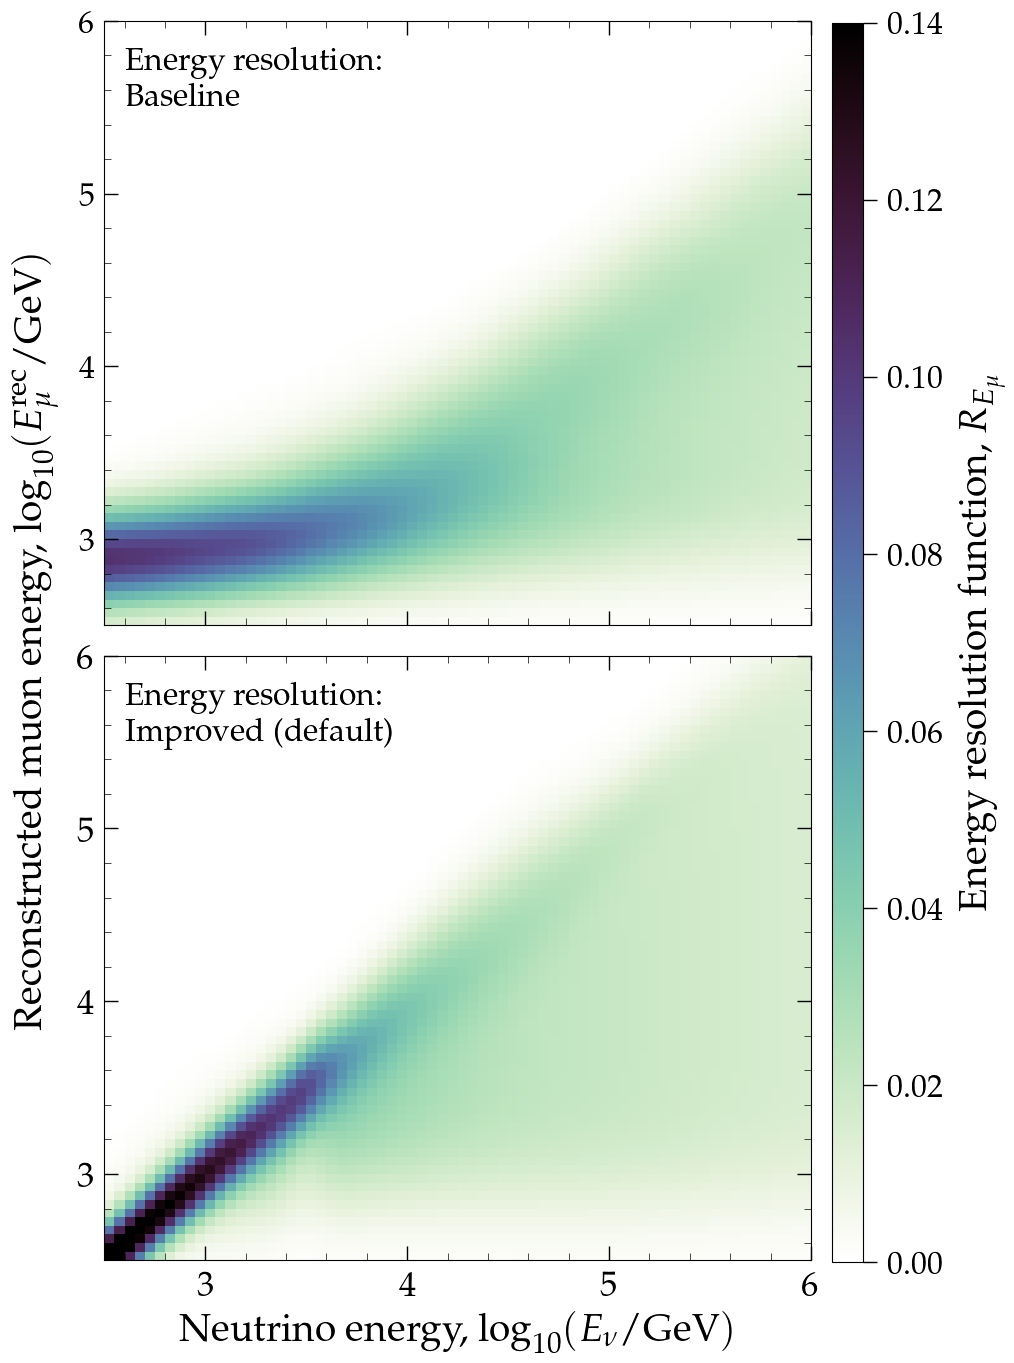

In [38]:
# nice plot
ebounds = (2.5, 6)
ticks = np.arange(3, 7)

_kw_mesh = dict(
    vmin=0.0,
    vmax=0.14,
    linewidth=0,
    rasterized=True,
    cmap=st.cmap_light,
    zorder=0.1
)
f, axes = plt.subplots(nrows=2, figsize=(9, 15), sharex=True)
plt.subplots_adjust(hspace=0.05)

locator_major = ticker.MultipleLocator(1)
locator_minor = ticker.MultipleLocator(0.2)

# Baseline
ax = axes[0]
_kw_annotation = dict(
    xy=(ebounds[0] + 0.1, ebounds[1] - 0.15),
    color="k",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontweight="bold",
    fontsize=23,
)
im = ax.pcolormesh(*baseline_eres_bins, baseline_eres_histo.T, **_kw_mesh)
# ax.set_yticks(ticks)
# ax.tick_params(direction="in", top=True, right=True, left=True, bottom=True)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.annotate("Energy resolution:\n Baseline", **_kw_annotation)
ax.xaxis.set_major_locator(locator_major)
ax.yaxis.set_major_locator(locator_major)
ax.xaxis.set_minor_locator(locator_minor)
ax.yaxis.set_minor_locator(locator_minor)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.grid(False)

# Improved
ax = axes[1]
_kw_annotation = dict(
    xy=(ebounds[0] + 0.1, ebounds[1] - 0.15),
    color="k",
    transform=ax.transAxes,
    ha="left",
    va="top",
    # fontweight="bold",
    fontsize=23,
)
im = ax.pcolormesh(*improved_eres_bins, improved_eres_histo.T, **_kw_mesh)
ax.annotate("Energy resolution:\n Improved (default)", **_kw_annotation)
# ax.set_yticks(ticks)
# ax.tick_params(direction="in", top=True, right=True, left=True, bottom=True, size=20)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_xlabel(r"Neutrino energy, $\log_{10}(E_{\nu}/{\rm GeV})$", fontsize=28)
ax.xaxis.set_major_locator(locator_major)
ax.yaxis.set_major_locator(locator_major)
ax.xaxis.set_minor_locator(locator_minor)
ax.yaxis.set_minor_locator(locator_minor)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.grid(False)

# Common y-axis label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.ylabel(r"Reconstructed muon energy, $\log_{10}(E_{\mu}^{\rm rec}/{\rm GeV})$", fontsize=28)
plt.grid(alpha=0)

# Common c-axis label
cax = f.add_axes([0.98, 0.136, 0.035, 0.826])
cb = f.colorbar(im, cax=cax)
cb.ax.tick_params(direction="out", labelsize=23)
cb.set_label(r"Energy resolution function, $R_{E_\mu}$", labelpad=12, fontsize=28)
# cb.set_label(r"$P(E_{\mu}^{\rm reco}|E_{\nu})$")
# cb.set_ticks(np.arange(0, 0.16, step=0.03))

# f.tight_layout()
f.savefig(
    join(st.BASEPATH, plot_path, "energy_resolution_comparison.pdf"),
    bbox_inches="tight",
)

# Angular resolution

In [39]:
with open(join(st.BASEPATH, "resources/energy_psi.pckl"), "rb") as f:
    e_psi2_grid, e_psi2_bins = pickle.load(f)

['$10^{2}$ GeV', '$10^{3}$ GeV', '$10^{4}$ GeV', '$10^{5}$ GeV', '$10^{6}$ GeV', '$10^{7}$ GeV', '$10^{8}$ GeV']


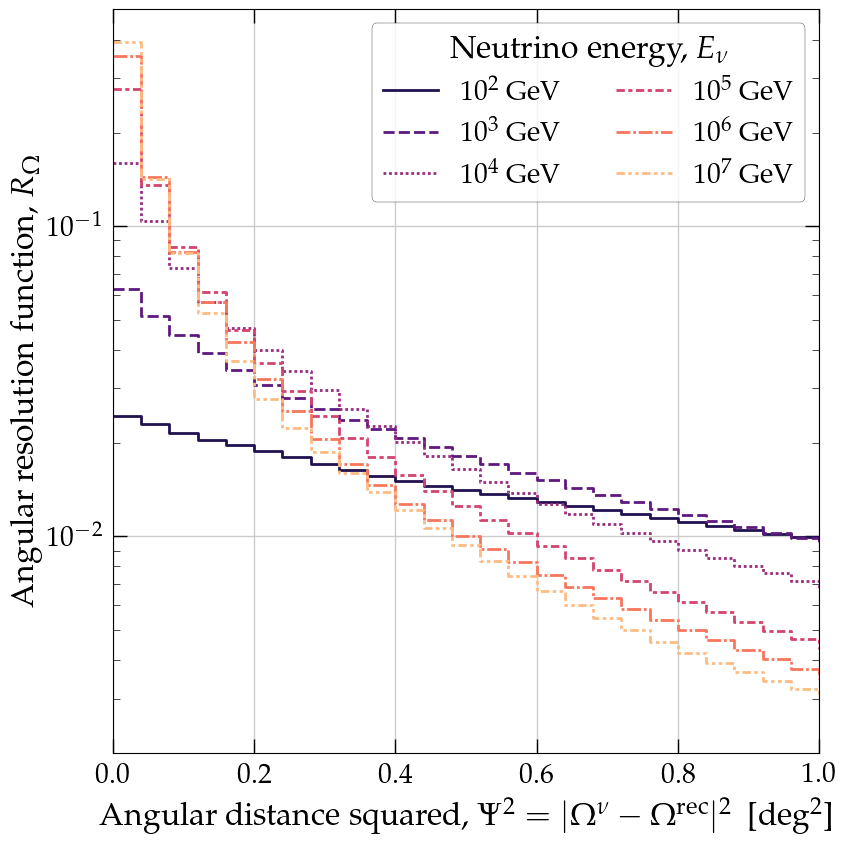

In [40]:
# OPTION 1)
if False:
    f, ax = plt.subplots(figsize=(9, 9))
    # ax.set_title("Angular resolution")
    ax.set_ylim(2.5, 5)
    ax.set_xlim(0, 1)
    ax.set_ylabel(r"Neutrino energy, $\log_{10}(E_{\nu}/{\rm GeV})$")
    ax.set_xlabel(
        r"Angular resolution - squared, "
        + "\n"
        + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$"
    )
    # ax.set_xlabel(
    #     r"Angular resolution - squared, "
    #     + "\n"
    #     + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$"
    # )
    ax.tick_params(direction="out", top=False, right=False)

    p = ax.pcolormesh(
        e_psi2_bins[0],
        e_psi2_bins[1],
        e_psi2_grid.T,
        # vmin=0,
        # vmax=0.15,
        norm=LogNorm(vmin=3e-3, vmax=2e-1),
        linewidth=0,
        rasterized=True,
    )
    cb = plt.colorbar(p)
    cb.set_label(
        r"Angular resolution, $R_{\Omega}(\Omega^\nu, \Omega^{\rm rec}, E_\nu)$"
    )
    cb.ax.tick_params(direction="out")

# OPTION 2
else:
    column_names = []
    slicer = 20
    for e in e_psi2_bins[1][:-1:slicer]:
        column_names.append(rf"$10^{{{e:1.0f}}}$ GeV")

    print(column_names)
    df = pd.DataFrame(e_psi2_grid[:, ::slicer], columns=column_names)
    df["psi2"] = e_psi2_bins[0][:-1]
    df.set_index("psi2", inplace=True)

    f, ax = plt.subplots(figsize=(9, 9))
    lp = sns.lineplot(data=df[df.columns[:-1]], ds="steps-post", palette="magma")
    plt.yscale("log")
    plt.xlim(0, 1)
    plt.ylim(2e-3, 5e-1)
    plt.xlabel(
        r"Angular distance squared, $\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$~ [deg$^2$]",
        fontsize=23
    )
    # plt.xlabel(
    #     "Angular distance - squared, "
    #     + "\n"
    #     + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$~ [deg$^2$]"
    # )
    plt.ylabel(
        r"Angular resolution function, $R_{\Omega}$" ,
        fontsize=23
    )
    ax.tick_params(axis='both', which='major', labelsize=20)
    lp.legend(
        loc="upper right", 
        # bbox_to_anchor=(0.5, 1.35), 
        ncol=2, 
        frameon=True,
        edgecolor='k',
        title=r'Neutrino energy, $E_\nu$',
        title_fontsize=23,
        fontsize=20
    )
    f.savefig(
        join(st.BASEPATH, plot_path, "energy_angular_resolution.pdf"),
        bbox_inches="tight",
    )

# DP source


In [41]:
# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 14 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "IC_North_det": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC 14~yr + IC-North 10~yr",
        "plainlabel": "IC_North_det",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT 10~yr",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC 14~yr + PLE$\nu$M-1 10~yr",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-2 10~yr",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },    
    "Plenum-3": {
        "color": "indigo",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-3 10~yr",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "o",
    },
}

## NGC 1068 - gamma=-3.2

In [42]:
ngc_flux_ps = pd.read_pickle(join(st.BASEPATH, "resources/flux_ngc_disc_pot.pickle"))

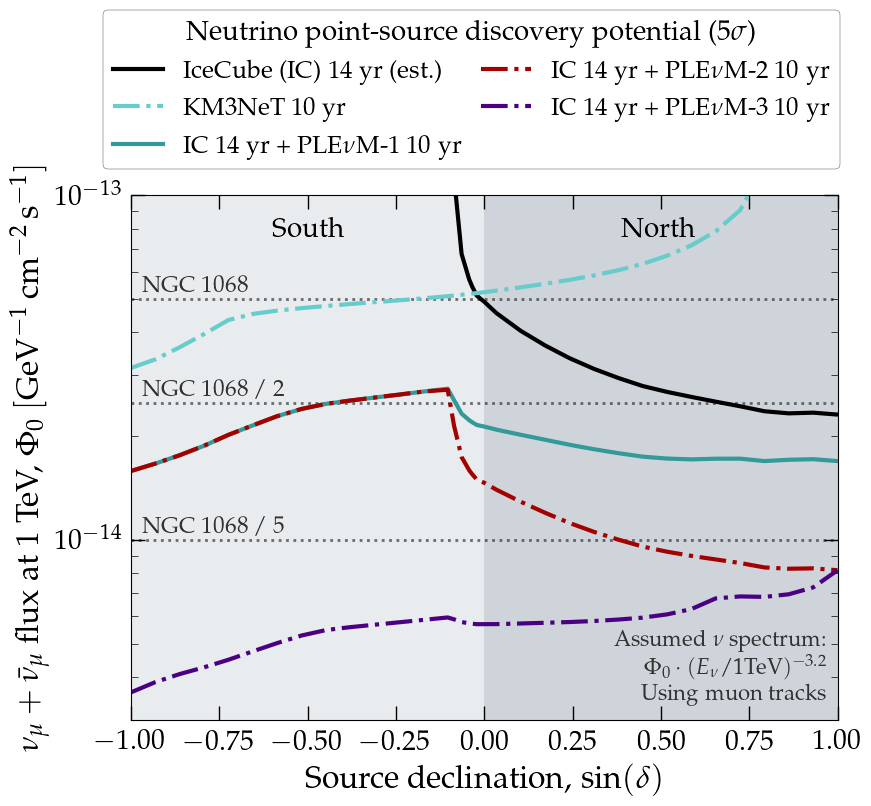

In [43]:
f, ax = plt.subplots(figsize=(9, 9))

ax.fill_between(
    x=[-1.0,0.0],
    y1=[1.e-13,1.e-13],
    y2=1.e-15,
    fc='#e9ecef',
    zorder=0.1
)
ax.fill_between(
    x=[0.0,1.0],
    y1=[1.e-13,1.e-13],
    y2=1.e-15,
    fc='#ced4da',
    zorder=0.1
)


for ident, series in ngc_flux_ps.groupby("ident"):
    if ident == "KM3NeT":
        continue
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.grid(False)
ax.set_yscale("log")
ax.set_xlabel(r"Source declination, $\sin(\delta)$", fontsize=23)
# ax.set_ylabel(
#     r"$\Phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
# )
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.55, 0.94),
    columnspacing=0.8,
    edgecolor='k',
    title=r'Neutrino point-source discovery potential (5$\sigma$)',
    title_fontsize=20,
    fontsize=18
)
ax.set_ylim(3e-15, 1e-13)
ax.set_xlim(-1, 1)
for ii in [1, 2, 5]:
    ax.axhline(ngc_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7)
    ax.text(
        x=-0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="left",
    )
ax.text(
    0.2, 0.92, "South", fontsize="x-large", color='k', transform=ax.transAxes
)
ax.text(
    0.8,
    0.92,
    "North",
    ha="right",
    fontsize="x-large",
    color='k',
    transform=ax.transAxes,
)
ax.tick_params(axis='both', which='major', labelsize=20)

f.subplots_adjust(top=0.72)
# ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
# ax.set_title(r"Neutrino point-source discovery ($5\sigma$)")
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E_\nu/{\rm 1 TeV})^{-3.2}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(0.97, 5.5e-15),
    ha="right",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)

f.savefig(join(st.BASEPATH, plot_path, "ngc_disc_pot.pdf"), bbox_inches="tight")

## TXS 0506+056 - gamma=-2

In [44]:
from fluxes import txs_flux

[]

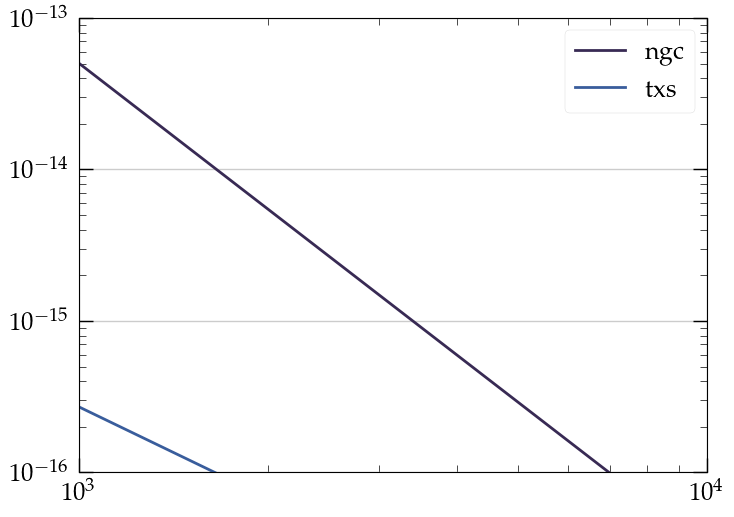

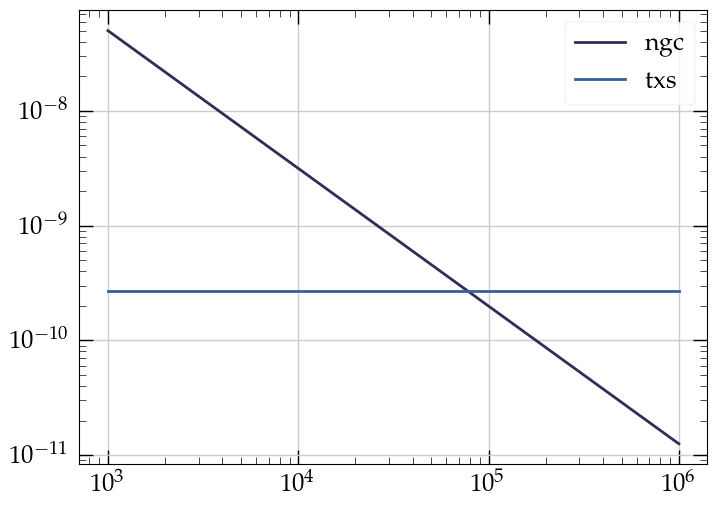

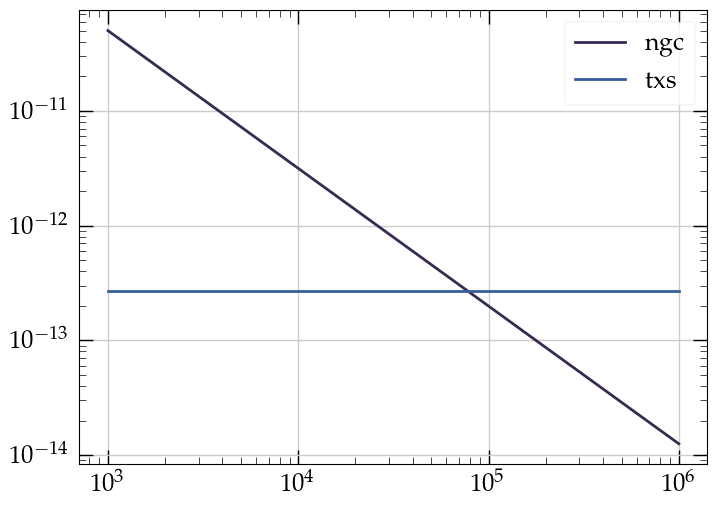

In [45]:
E = np.power(10, np.linspace(3, 6)) # GeV
plt.figure()
plt.plot(E, ngc_flux.norm * (E / ngc_flux.E0) ** (-ngc_flux.gamma), label="ngc")
plt.plot(E, txs_flux.norm * (E / txs_flux.E0) ** (-txs_flux.gamma), label="txs")
plt.legend()
plt.loglog()
plt.ylim(1E-16, 1E-13)
plt.xlim(1E3, 1E4)

plt.figure()
plt.plot(E, E**2 * ngc_flux.norm * (E / ngc_flux.E0) ** (-ngc_flux.gamma), label="ngc")
plt.plot(E, E**2 * txs_flux.norm * (E / txs_flux.E0) ** (-txs_flux.gamma), label="txs")
plt.legend()
plt.loglog()

plt.figure()
plt.plot(E, 1E-3 * E**2 * ngc_flux.norm * (E / ngc_flux.E0) ** (-ngc_flux.gamma), label="ngc")
plt.plot(E, 1E-3 * E**2 * txs_flux.norm * (E / txs_flux.E0) ** (-txs_flux.gamma), label="txs")
plt.legend()
plt.loglog()

In [46]:
txs_flux

PL_flux(norm=2.7e-20, gamma=2.0, E0=100000.0, shape='powerlaw')

In [47]:
txs_flux_ps = pd.read_pickle(join(st.BASEPATH, "resources/flux_txs_disc_pot.pickle"))

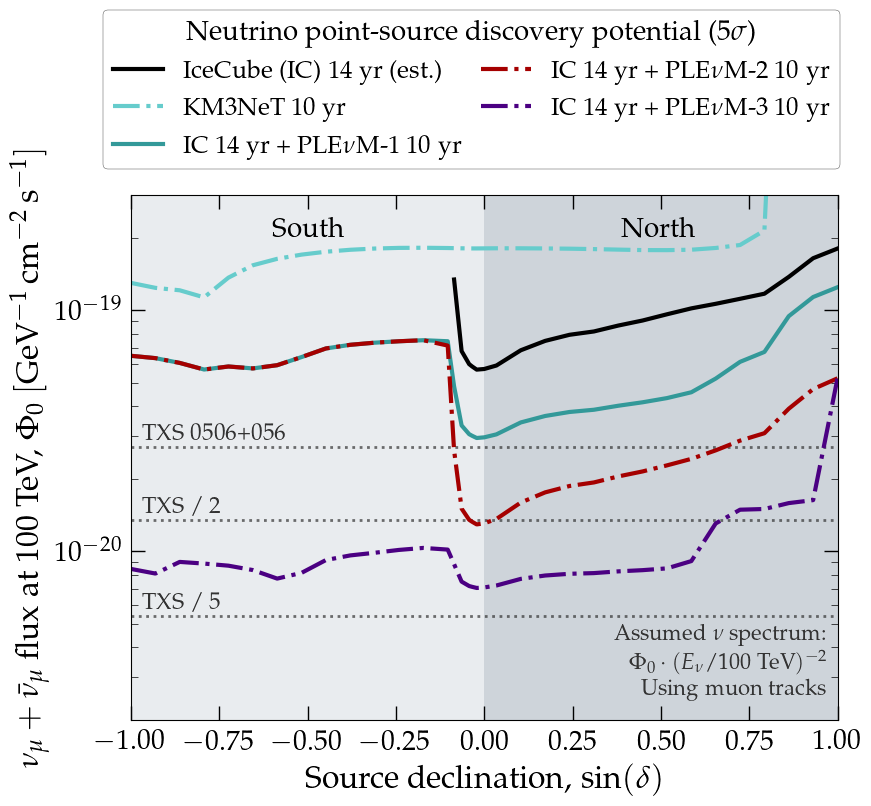

In [48]:
f, ax = plt.subplots(figsize=(9, 9))


ax.fill_between(
    x=[-1.0,0.0],
    y1=[1.e-17,1.e-17],
    y2=1.e-21,
    fc='#e9ecef',
    zorder=0.1
)
ax.fill_between(
    x=[0.0,1.0],
    y1=[1.e-17,1.e-17],
    y2=1.e-21,
    fc='#ced4da',
    zorder=0.1
)


for ident, series in txs_flux_ps.groupby("ident"):
    if ident == "KM3NeT":
        continue
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.grid(False)
ax.set_yscale("log")
ax.set_xlabel(r"Source declination, $\sin(\delta)$", fontsize=23)

ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 100~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.55, 0.94),
    columnspacing=0.8,
    edgecolor='k',
    title=r'Neutrino point-source discovery potential (5$\sigma$)',
    title_fontsize=20,
    fontsize=18
)

for ii in [1, 2, 5]:
    ax.axhline(txs_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7)
    ax.text(
        x=-0.97,
        y=txs_flux.norm / ii,
        va="bottom",
        s="TXS 0506+056" if ii == 1 else f"TXS / {ii}",
        color=font_color,
        fontsize="large",
        ha="left",
    )
ax.text(
    0.2, 0.92, "South", fontsize="x-large", color='k', transform=ax.transAxes
)
ax.text(
    0.8,
    0.92,
    "North",
    ha="right",
    fontsize="x-large",
    color='k',
    transform=ax.transAxes,
)
ax.tick_params(axis='both', which='major', labelsize=20)

f.subplots_adjust(top=0.72)

ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E_\nu/{\rm 100~TeV})^{-2}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(0.97, 5e-21),
    ha="right",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)
ax.set_ylim(2E-21, 3e-19)
ax.set_xlim(-1, 1)
f.savefig(join(st.BASEPATH, plot_path, "txs_disc_pot.pdf"), bbox_inches="tight")

## combined TXS + NGC plot

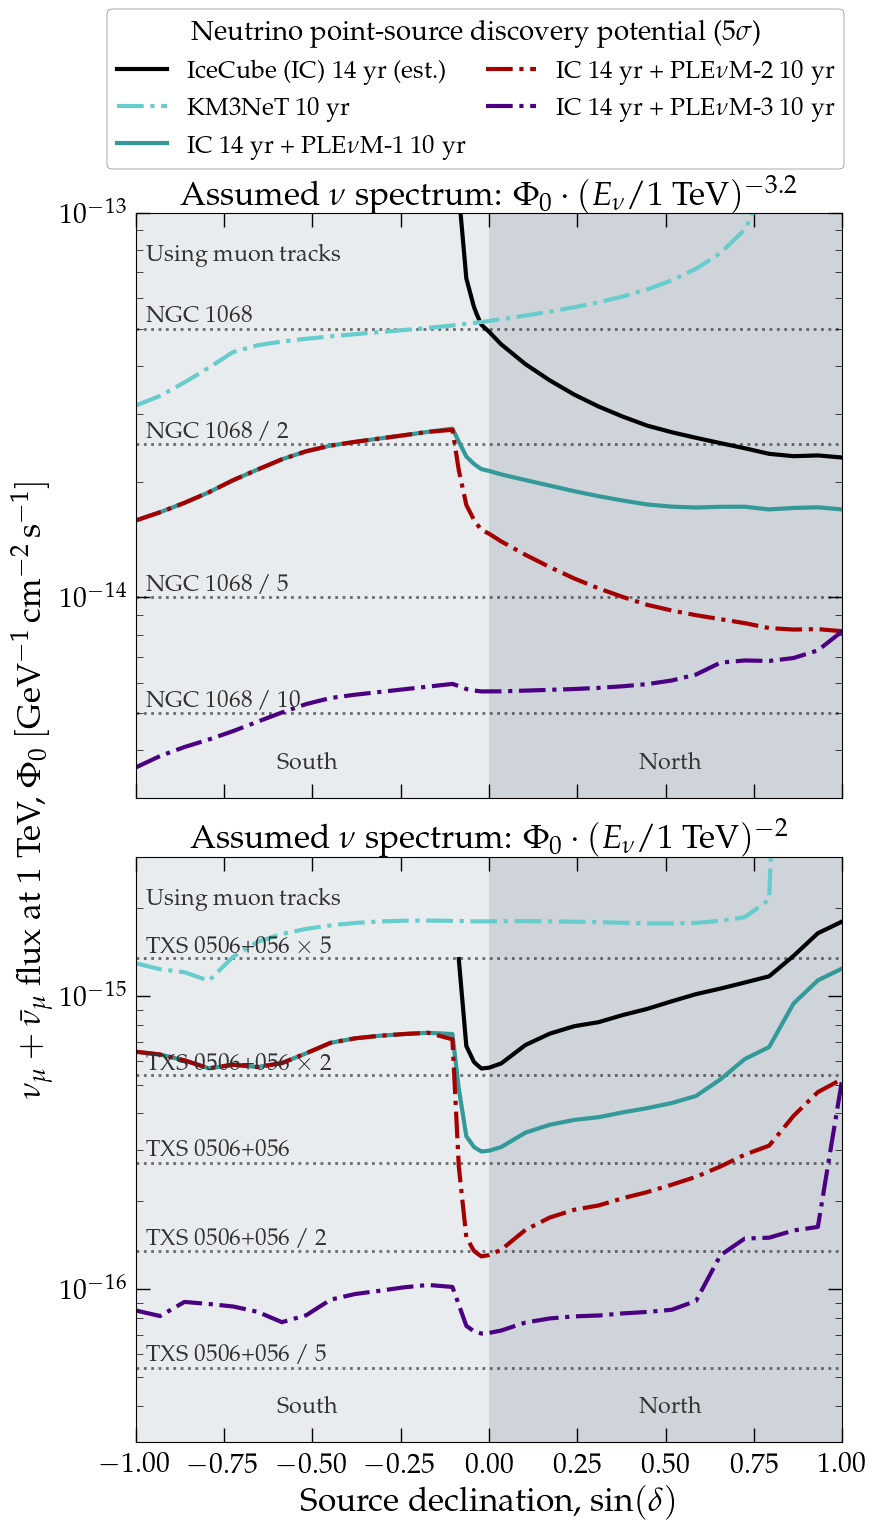

In [49]:
## todo: add txs*2 and maybe txs*5?
f, axes = plt.subplots(nrows=2, figsize=(9, 18), sharex=True)
plt.subplots_adjust(hspace=0.1)

ax = axes[0]

# NGC 1068 plot
ax.fill_between(
    x=[-1.0, 0.0], y1=[1.0e-13, 1.0e-13], y2=1.0e-15, fc="#e9ecef", zorder=0.1
)
ax.fill_between(
    x=[0.0, 1.0], y1=[1.0e-13, 1.0e-13], y2=1.0e-15, fc="#ced4da", zorder=0.1
)


for ident, series in ngc_flux_ps.groupby("ident"):
    if ident == "KM3NeT":
        continue
    ax.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )

f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.55, 0.94),
    columnspacing=0.8,
    edgecolor="k",
    title=r"Neutrino point-source discovery potential (5$\sigma$)",
    title_fontsize=20,
    fontsize=18,
)
ax.set_ylim(3e-15, 1e-13)

for ii in [1, 2, 5, 10]:
    ax.axhline(
        ngc_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7
    )
    ax.text(
        x=-0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="left",
    )

f.subplots_adjust(top=0.82)

# TXS flux
ax = axes[1]
## scaling factor to convert from 100 TeV to 1 TeV normalization
_scaling = 1e4

ax.fill_between(
    x=[-1.0, 0.0],
    y1=[1.0e-17 * _scaling, 1.0e-17 * _scaling],
    y2=1.0e-21 * _scaling,
    fc="#e9ecef",
    zorder=0.1,
)
ax.fill_between(
    x=[0.0, 1.0],
    y1=[1.0e-17 * _scaling, 1.0e-17 * _scaling],
    y2=1.0e-21 * _scaling,
    fc="#ced4da",
    zorder=0.1,
)

for ident, series in txs_flux_ps.groupby("ident"):
    if ident == "KM3NeT":
        continue
    ax.plot(
        np.sin(series.dec),
        series.disc5 * _scaling,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )

for ii in [0.2, 0.5, 1, 2, 5]:
    ax.axhline(
        txs_flux.norm / ii * _scaling,
        ls=":",
        lw=2,
        color=font_color,
        zorder=0.2,
        alpha=0.7,
    )
    if ii == 1:
        _label = "TXS 0506+056"
    elif ii < 1:
        _label = rf"TXS 0506+056 $\times$ {1/ii:1.0f}"
    else:
        _label = f"TXS 0506+056 / {ii}"
    ax.text(
        x=-0.97,
        y=txs_flux.norm / ii * _scaling,
        va="bottom",
        s=_label,
        color=font_color,
        fontsize="large",
        ha="left",
    )

ax.set_ylim(3e-21 * _scaling, 3e-19 * _scaling)

_text_kw = dict(y=0.05, fontsize="large", color=font_color)
for ax in axes:
    ax.set_xlim(-1, 1)
    ax.text(x=0.2, s="South", transform=ax.transAxes, **_text_kw)
    ax.text(x=0.8, s="North", ha="right", transform=ax.transAxes, **_text_kw)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.grid(False)
    ax.set_yscale("log")
    ax.text(
        0.015,
        0.92,
        "Using muon tracks",
        transform=ax.transAxes,
        zorder=10,
        color=font_color,
        fontsize="large",
    )
axes[0].set_title(
    r"Assumed $\nu$ spectrum: $\Phi_0 \cdot (E_\nu/{\rm 1~TeV})^{-3.2}$",
    fontsize="xx-large",
)
axes[1].set_title(
    r"Assumed $\nu$ spectrum: $\Phi_0 \cdot (E_\nu/{\rm 1~TeV})^{-2}$",
    fontsize="xx-large",
)
axes[1].set_xlabel(r"Source declination, $\sin(\delta)$", fontsize="xx-large")

# Common y-axis label
lax = f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize="xx-large",
)
plt.grid(alpha=0)
lax.set_position([0.13, 0.25, 0.1, 0.5])

f.savefig(join(st.BASEPATH, plot_path, "txs-ngc_disc_pot.pdf"), bbox_inches="tight")

# discrimination PL EC


In [50]:
flux_ec = pd.read_pickle(
    join(st.BASEPATH, "resources/flux_ngc_spectral_disc_pot.pickle")
)

## v1

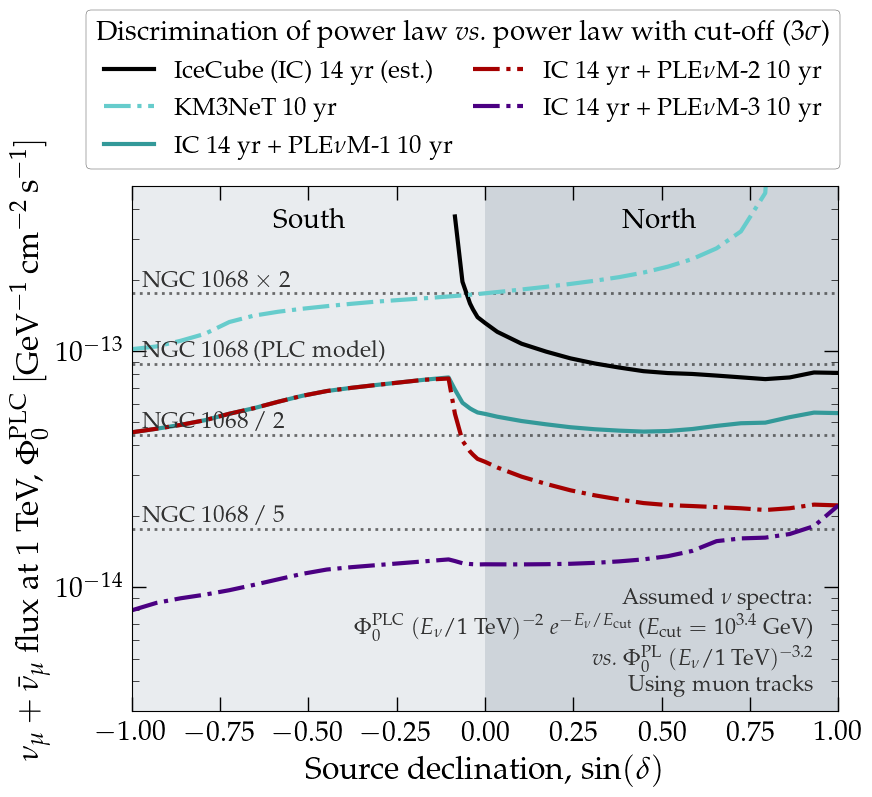

In [51]:
f, ax = plt.subplots(figsize=(9, 9))

ax.fill_between(
    x=[-1.0, 0.0], y1=[5.0e-13, 5.0e-13], y2=1.0e-15, fc="#e9ecef", zorder=0.1
)
ax.fill_between(
    x=[0.0, 1.0], y1=[5.0e-13, 5.0e-13], y2=1.0e-15, fc="#ced4da", zorder=0.1
)


for ident, series in flux_ec.groupby("ident"):
    if ident == "KM3NeT":
        continue
    plt.plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.grid(False)
ax.set_yscale("log")
ax.set_xlabel(r"Source declination, $\sin(\delta)$", fontsize=23)
# ax.set_ylabel(
#     r"$\Phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
# )
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0}^{\rm PLC} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.54, 0.93),
    columnspacing=0.8,
    edgecolor="k",
    title=r"Discrimination of power law~{\it vs.}~power law with cut-off (3$\sigma$)",
    title_fontsize=20,
    fontsize=18,
)
ax.set_ylim(3e-15, 5e-13)
ax.set_xlim(-1, 1)
for ii in [0.5, 1, 2, 5]:
    ax.axhline(
        ngc_cut_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7
    )
    if ii==1:
        _label = "NGC 1068 (PLC model)"
    elif ii<1:
        _label = fr"NGC 1068 $\times$ {1/ii:1.0f}"
    else:
        _label = f"NGC 1068 / {ii}"
    ax.text(
        x=-0.97,
        y=ngc_cut_flux.norm / ii,
        va="bottom",
        s= _label,
        color=font_color,
        fontsize="large",
        ha="left",
    )
ax.text(0.2, 0.92, "South", fontsize="x-large", color="k", transform=ax.transAxes)
ax.text(
    0.8,
    0.92,
    "North",
    ha="right",
    fontsize="x-large",
    color="k",
    transform=ax.transAxes,
)
ax.tick_params(axis="both", which="major", labelsize=20)

f.subplots_adjust(top=0.72)
# ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
# ax.set_title(r"Neutrino point-source discovery ($5\sigma$)")
ax.annotate(
    r"Assumed $\nu$ spectra: "
    + "\n"
    + r"$\Phi_0^{\rm PLC}~(E_\nu/{\rm 1~TeV})^{-2}~e^{-E_\nu/E_{\rm cut}}~$($E_{\rm cut} = 10^{3.4}~{\rm GeV}$)"
    + "\n"
    + r"~{\it vs.}~$\Phi_0^{\rm PL}~(E_\nu/{\rm 1~TeV})^{-3.2}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(0.93, 10e-15),
    ha="right",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)

f.savefig(
    join(st.BASEPATH, plot_path, "ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
)

# Time evolution

## source discovery

In [52]:
txs_flux_psd = pd.read_csv(
    "../../resources/txs_point-source_discovery_time-evolution.csv"
)
# 1E4 for 100 TeV to 1 TeV pivot energy
txs_flux_psd.scaled_flux = 1E15 * 1E4 * txs_flux_psd.dp_flux
txs_flux_psd.rename(columns={"dec_label": "Declination"}, inplace=True)
txs_flux_psd["Era"] = ""
txs_flux_psd.loc[txs_flux_psd.era=="IceCube", "Era"] = r"IceCube-only"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-1", "Era"] = r"PLE$\nu$M-1"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-2", "Era"] = r"PLE$\nu$M-2"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
txs_flux_psd_min = (
    txs_flux_psd.loc[txs_flux_psd.sigma == 5]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
txs_flux_psd.loc[
    (txs_flux_psd.era == "Plenum-2")
    & (txs_flux_psd.dec == -30)
    & (txs_flux_psd.sigma == 5),
    ["dp_flux", "scaled_flux"],
] = 0

In [53]:
ngc_flux_psd = pd.read_csv(
    "../../resources/ngc_point-source_discovery_time-evolution.csv"
)
ngc_flux_psd.scaled_flux = 1e13 * ngc_flux_psd.dp_flux
ngc_flux_psd.rename(columns={"dec_label": "Declination"}, inplace=True)
ngc_flux_psd["Era"] = ""
ngc_flux_psd.loc[ngc_flux_psd.era == "IceCube", "Era"] = r"IceCube-only"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-1", "Era"] = r"PLE$\nu$M-1"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-2", "Era"] = r"PLE$\nu$M-2"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
ngc_flux_psd_min = (
    ngc_flux_psd.loc[ngc_flux_psd.sigma == 5]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
ngc_flux_psd.loc[
    (ngc_flux_psd.era == "Plenum-2")
    & (ngc_flux_psd.dec == -30)
    & (ngc_flux_psd.sigma == 5),
    ["dp_flux", "scaled_flux"],
] = 0

In [54]:
## config
exposure_config = pd.read_pickle(join(st.LOCALPATH, f"timeline_configs.pickle"))
config_selection = pd.DataFrame(
    [
        {"Year": 2020, "era": "IceCube"},
        {"Year": 2025, "era": "IceCube"},
        # {"Year": 2028, "era": "Plenum-1"},
        {"Year": 2030, "era": "Plenum-1"},
        # {"Year": 2031, "era": "Plenum-1"},
        {"Year": 2035, "era": "Plenum-1"},
        {"Year": 2040, "era": "Plenum-2"},
        {"Year": 2045, "era": "Plenum-3"},
        {"Year": 2050, "era": "Plenum-3"},
    ]
)
config_selection["exposure"] = 0
for _, cs in config_selection.iterrows():
    selection = exposure_config.loc[
        (exposure_config.Year == cs["Year"]) & (exposure_config.era == cs["era"])
    ]
    _sum = 0
    for ii, _det in enumerate(selection.detectors.iloc[0]):
        if _det=="TRIDENT":
            _sum += selection.timefactors.iloc[0][ii] * st.TRIDENT_FACTOR
        elif _det=="HUNT":
            _sum += selection.timefactors.iloc[0][ii] * st.HUNT_FACTOR
        elif _det=="NEON":
            _sum += selection.timefactors.iloc[0][ii] * st.NEON_FACTOR
        else:
            _sum += selection.timefactors.iloc[0][ii]
    config_selection.loc[_, "exposure"] = _sum * 10

In [55]:
font_color = "0.3"
colors_detectors = {
    "IceCube": "#D8F3DC",
    "IceCube-Gen2": "#52B788",
    "KM3NeT": "#B7E4C7",
    "Baikal-FVD": "#95D5B2",
    "P-ONE": "#74C69D",
    "NEON": "#4BAA7F",
    "TRIDENT": "#4BAA7F",
    "HUNT": "#4BAA7F",
}
icecube_ref_time = (
    st.LIVETIME_DAYS / 365
)  # approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {
        "label": r"IceCube (IC)",
        "detector": "IceCube",
        "Year": 2020 - icecube_ref_time,
        "colors": colors_detectors["IceCube"],
        "end": 2035,
    },
    {
        "label": r"IceCube",
        "detector": "IceCube extrapolated",
        "Year": 2020 - icecube_ref_time,
        "colors": "0.8",
        "end": 2060,
    },  ## WIP
    {
        "label": r"+ KM3NeT (1 IC)",
        "detector": "KM3NeT",
        "Year": 2025,
        "colors": colors_detectors["KM3NeT"],
        "end": 2060,
    },
    {
        "label": r"+ Baikal-GVD (1 IC)",
        "detector": "Baikal-GVD",
        "Year": 2028,
        "colors": colors_detectors["Baikal-FVD"],
        "end": 2060,
    },
    {
        "label": r"+ P-ONE (1 IC)",
        "detector": "P-ONE",
        "Year": 2031,
        "colors": colors_detectors["P-ONE"],
        "end": 2060,
    },
    {
        "label": r"+ IceCube-Gen2 (7.5~IC)",
        "detector": "Gen-2",
        "Year": 2035,
        "colors": colors_detectors["IceCube-Gen2"],
        "end": 2060,
    },
    {
        "label": r"+ TRIDENT (7.5 IC)",
        "detector": "TRIDENT",
        "Year": 2040,
        "colors": colors_detectors["TRIDENT"],
        "end": 2060,
    },
    {
        "label": r"+ NEON (10 IC)",
        "detector": "NEON",
        "Year": 2040,
        "colors": colors_detectors["NEON"],
        "end": 2060,
    },
    {
        "label": r"+ HUNT (30 IC)",
        "detector": "HUNT",
        "Year": 2040,
        "colors": colors_detectors["HUNT"],
        "end": 2060,
    },
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2050
Years = np.arange(2020, yr_max)

sigma_ref = 5

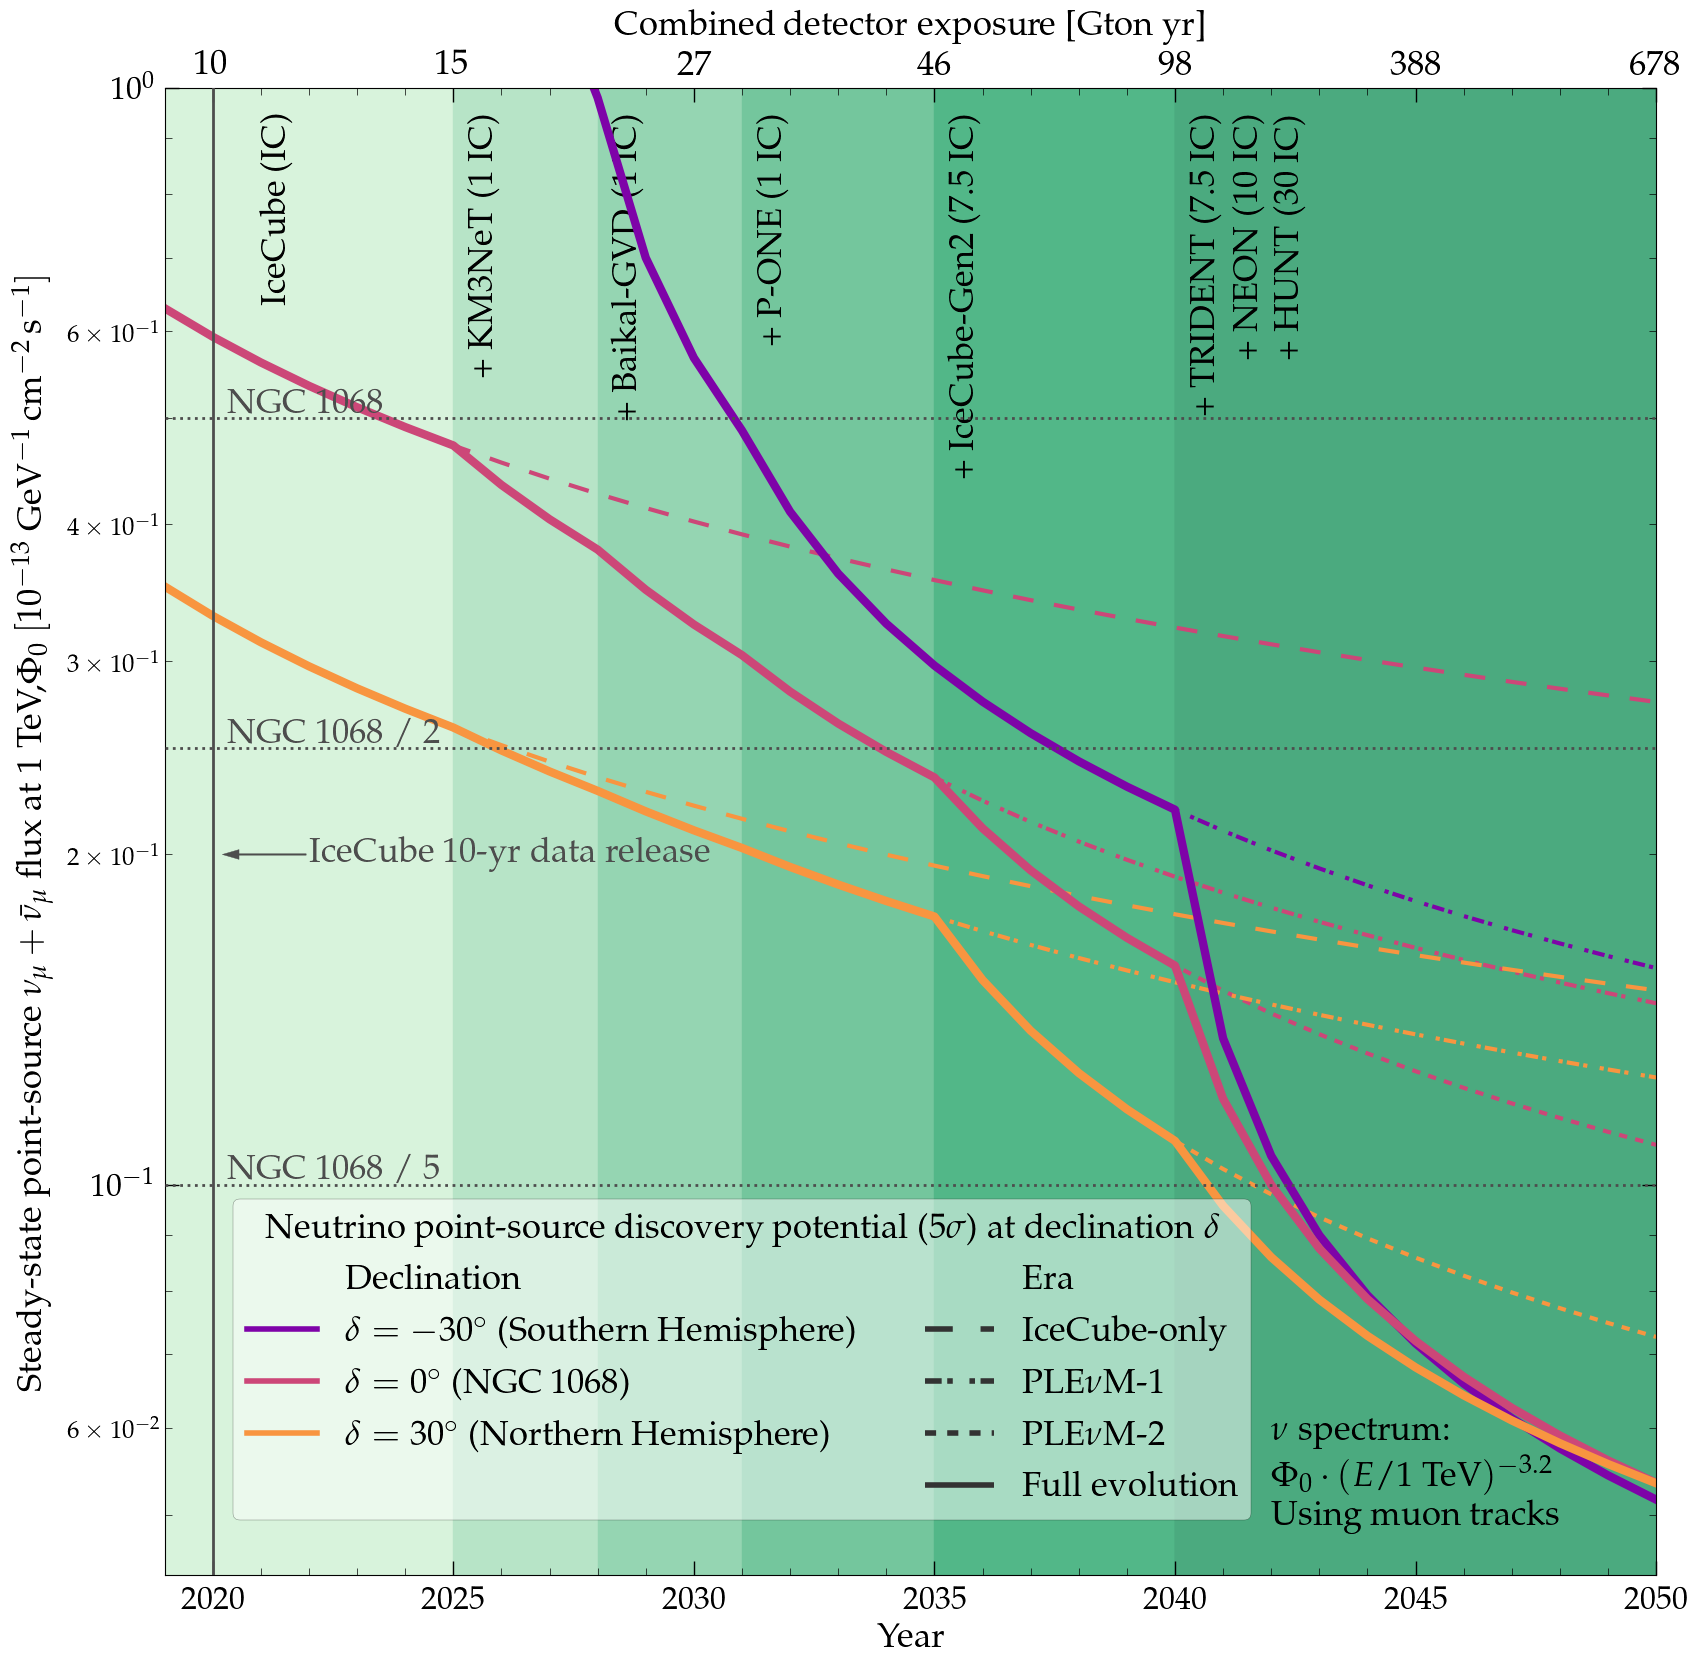

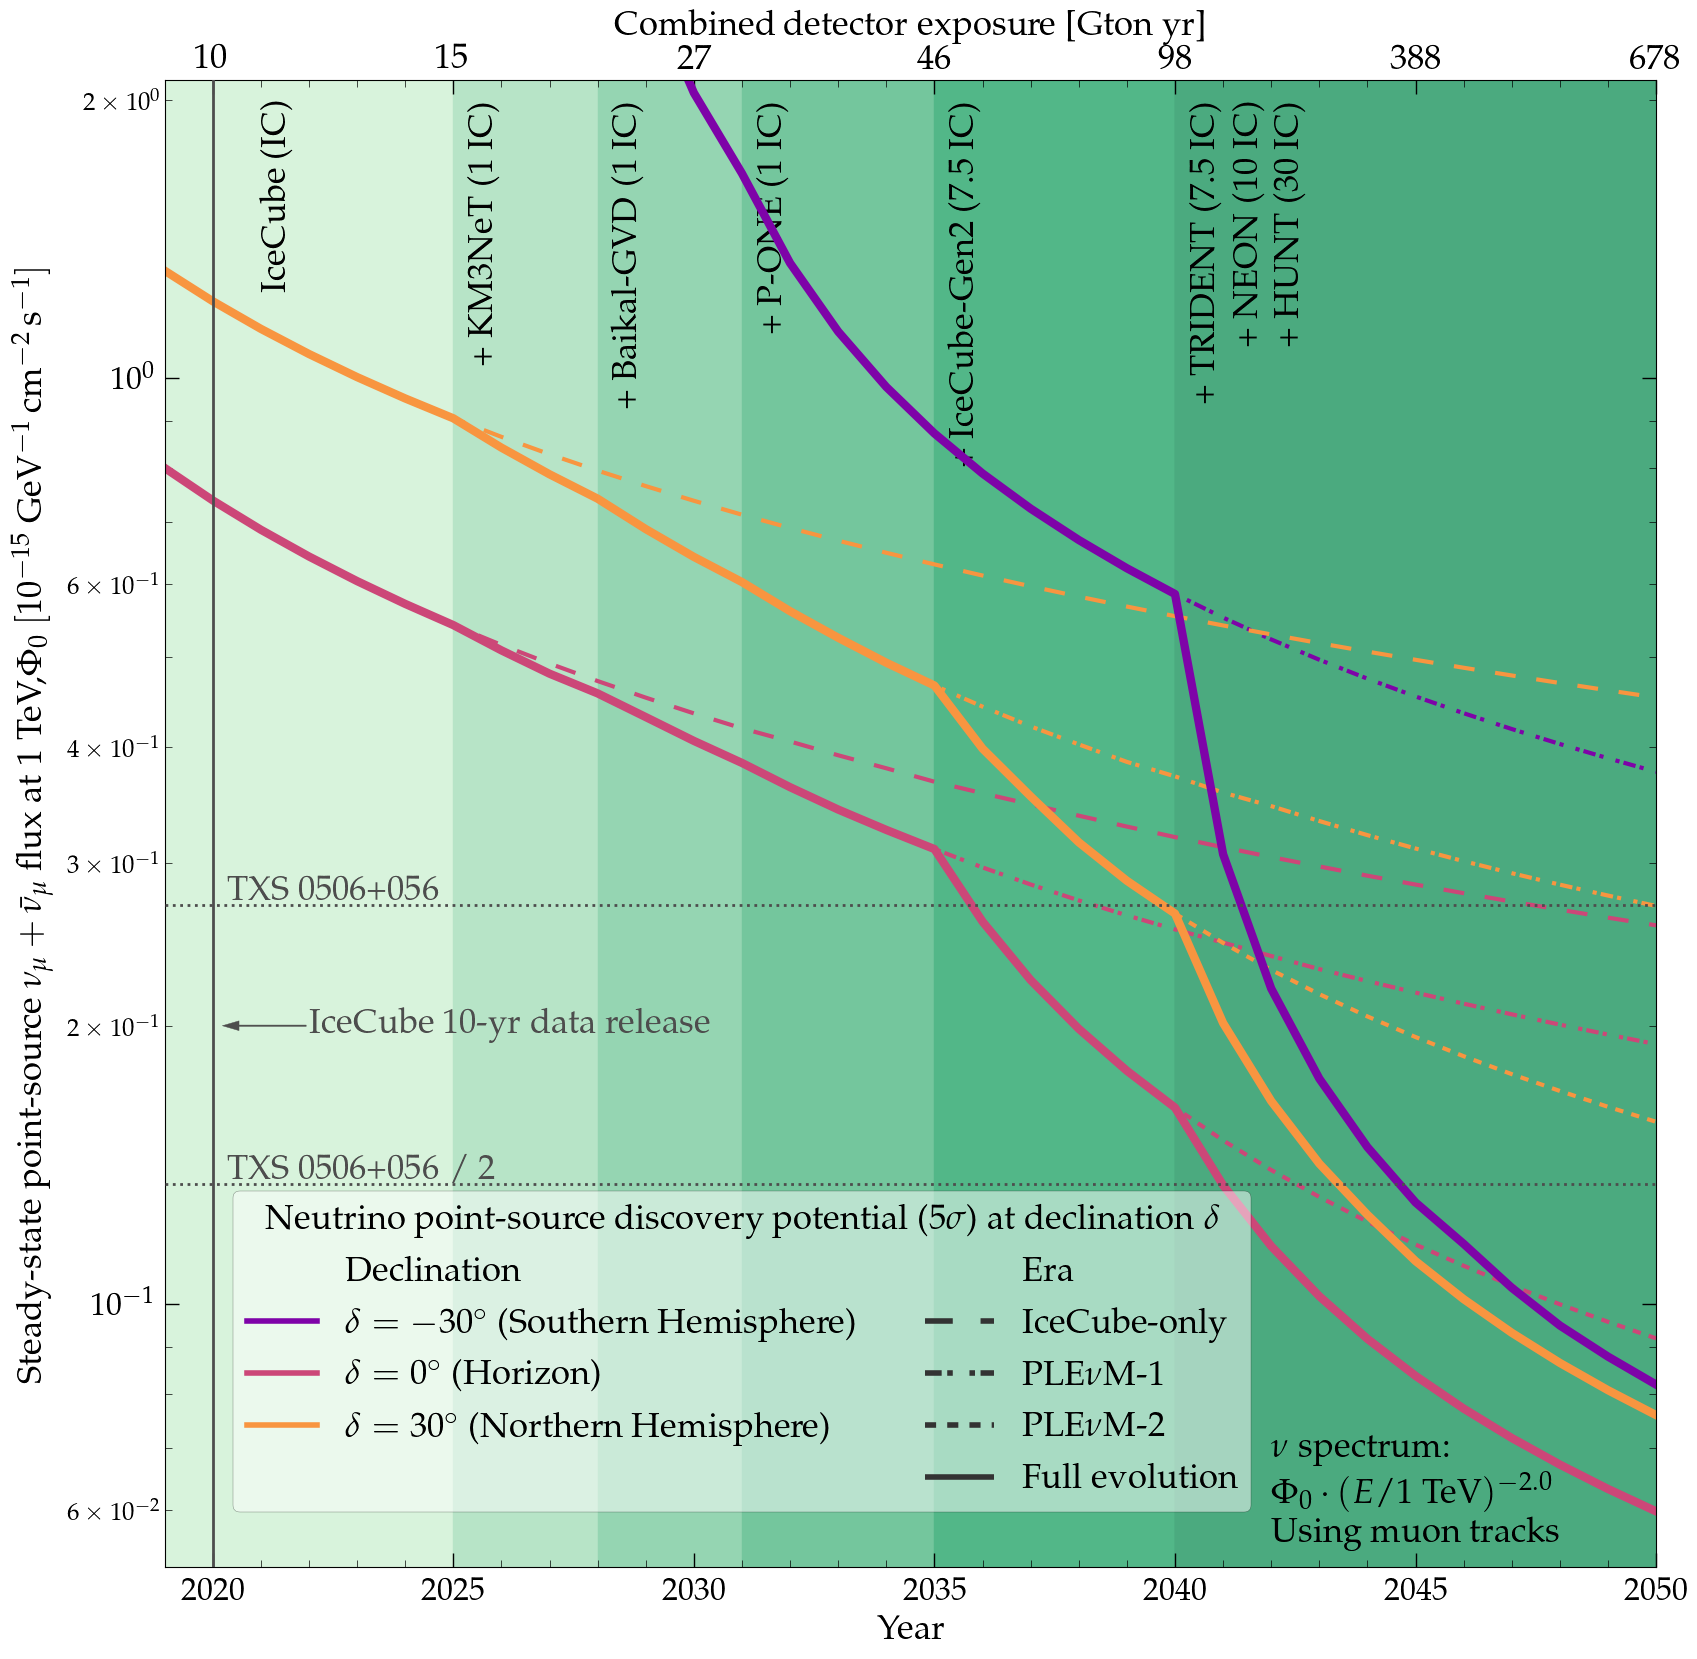

In [56]:
for _src in ["ngc", "txs"]:
    f, ax = plt.subplots(figsize=(19, 18))
    if _src == "ngc":
        _flux_psd = ngc_flux_psd
        _flux_psd_min = ngc_flux_psd_min
        _ymin = 0.044
        _ymax = 1
        _gamma = -3.2

        for ii in [1, 2, 5]:
            ax.axhline(
                st.PHI_NGC * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=10
            )
            ax.text(
                x=2020 + 0.3,
                y=1.01 * st.PHI_NGC * 1e13 / ii,
                s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
                color=font_color,
                fontsize=25,  # "large",
                zorder=10,
            )
    elif _src == "txs":
        _flux_psd = txs_flux_psd
        _flux_psd_min = txs_flux_psd_min
        _ymin = 0.052
        _ymax = 2.1
        _gamma = -2.0

        for ii in [1, 2]:
            _scaling = 1e19
            ax.axhline(
                txs_flux.norm * _scaling / ii,
                ls=":",
                lw=2,
                color=font_color,
                zorder=10,
            )
            ax.text(
                x=2020 + 0.3,
                y=1.01 * txs_flux.norm * _scaling / ii,
                s="TXS 0506+056" if ii == 1 else f"TXS 0506+056 / {ii}",
                color=font_color,
                fontsize=25,  # "large",
                zorder=10,
            )
    ax.annotate(
        r"$\nu$ spectrum:"
        + "\n"
        + rf"$\Phi_0 \cdot (E/{{\rm 1~TeV}})^{{{_gamma}}}$"
        + "\n Using muon tracks",
        xy=(2042, _ymin * 1.4),
        ha="left",
        va="top",
        zorder=10,
        color="k",
        fontsize=25,
    )

    width = 0.5e-1
    font_color = "0.3"
    sigma_ref = 5
    _dashes = [(5, 5), (3, 1, 1), (2, 2), (1, 0)]

    ax.axvline(2020, zorder=10, color=font_color)
    ax.annotate(
        "IceCube 10-yr data release",
        (2020.2, 0.2),
        (2022, 0.2),
        ha="left",
        va="center",
        zorder=10,
        arrowprops=dict(width=1, headwidth=7, color=font_color),
        color=font_color,
        fontsize=25,  # "large",
    )

    for yr_i, series in start_dates.iterrows():
        if "extrapolated" in yr_i:
            continue
        length = 50 if not yr_i == "IceCube" else series.end - series.Year
        ax.fill_between(
            x=[series.Year, yr_max],
            y1=[_ymax * 1.5, _ymax * 1.5],
            y2=0.0,
            color=series.colors,
            zorder=0.3,
        )
        if yr_i == "IceCube":
            x = 2021
        elif yr_i == "NEON":
            x = series.Year + 1.2
        elif yr_i == "HUNT":
            x = series.Year + 2.05
        else:
            x = series.Year + 0.3
        ax.text(
            x=x,
            y=_ymax * 0.95,
            s=series.label,
            ha="left",
            va="top",
            fontsize=25,
            zorder=2,
            rotation=90,
        )

    # evolution
    ax = sns.lineplot(
        data=_flux_psd.loc[(_flux_psd.sigma == sigma_ref)],
        x="Year",
        y="scaled_flux",
        hue="Declination",
        hue_order=["-30°", "0°", "30°"],
        style="Era",
        style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
        lw=3,
        legend=False,
        palette="plasma",
        dashes=_dashes,
    )

    # minimum
    sns.lineplot(
        data=_flux_psd_min,
        x="Year",
        y="scaled_flux",
        hue="Declination",
        hue_order=["-30°", "0°", "30°"],
        lw=6,
        legend=False,
        palette="plasma",
    )

    # extra plotting for legend
    ax.plot(np.NaN, np.NaN, "-", color="none", label=" ")
    selection = _flux_psd.loc[(_flux_psd.sigma == sigma_ref) & (_flux_psd.Year == 2045)]
    if _src == "ngc":
        _hue_order = [
            r"$\delta = -30^\circ$~(Southern Hemisphere)",
            r"$\delta = 0^\circ$~(NGC 1068)",
            r"$\delta = 30^\circ$~(Northern Hemisphere)",
        ]
    elif _src == "txs":
        _hue_order = [
            r"$\delta = -30^\circ$~(Southern Hemisphere)",
            r"$\delta = 0^\circ$~(Horizon)",
            r"$\delta = 30^\circ$~(Northern Hemisphere)",
        ]
    ax = sns.lineplot(
        data=selection,
        x="Year",
        y="scaled_flux",
        hue="Declination",
        hue_order=_hue_order,
        style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
        style="Era",
        dashes=_dashes,
        lw=4,
        palette="plasma",
    )
    # re-ordering the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0, 5, 6, 7, 8, 9]
    labels = [labels[idx] for idx in order]
    labels[-1] = "Full evolution"
    legend = ax.legend(
        [handles[idx] for idx in order],
        labels,
        bbox_to_anchor=(0.74, 0.265),
        framealpha=0.5,
        loc=1,
        title=r"Neutrino point-source discovery potential ($5\sigma$) at declination $\delta$",
        # title=r"\hspace*{-0.5em}Neutrino point-source discovery\\[0.3em] potential ($5\sigma$) at declination $\delta$",
        ncol=2,
        fontsize=25,
        edgecolor="k",
        title_fontsize=25,
    )
    for ii, line in enumerate(legend.get_lines()):
        if ii==0 or ii==5:
            continue
        line.set_linewidth(4)
    

    # Top x-axis (artificial, for simplicity)
    for _, row in config_selection.iterrows():
        ax.text(
            x=row.Year, # if row.Year < yr_max else yr_max - 1,
            y=_ymax * 1.03,
            s="{:0.0f}".format(row.exposure),
            fontsize=25,
            ha="center",
        )
    ax.text(
        x=2034.5,
        y=_ymax * 1.12,
        s="Combined detector exposure [Gton~yr]",
        fontsize=25,
        ha="center",
    )
    ax.set_xlim(2019, yr_max)# - 1)
    ax.set_xlabel(r"Year", fontsize=25)
    _yscaling = -13 if _src == "ngc" else -15
    ax.set_ylabel(
        r"Steady-state point-source $\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV,"
        + r"$\Phi_{0} ~ ["
        + rf"10^{{{_yscaling}}}"
        + r"~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
        fontsize=25,
        labelpad=10,
    )
    plt.yticks(fontsize=23)
    plt.xticks(fontsize=23)
    ax.set_ylim(_ymin, _ymax)
    ax.set_yscale("log")

    ax.grid(alpha=0)
    if _src == "ngc":
        _yticks = np.concatenate(
            [np.arange(0.05, 0.1, step=0.01), np.arange(0.1, 1, step=0.1)]
        )
    else:
        _yticks = np.concatenate(
            [np.arange(0.06, 0.1, step=0.01), np.arange(0.1, 1, step=0.1), [1, 2]]
        )
    ax.yaxis.set_minor_locator(
        matplotlib.ticker.LogLocator(
            base=10.0, subs=np.arange(0.1, 1, step=0.1), numticks=12
        )
    )
    ax.yaxis.set_minor_formatter(
        matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(5, 1))
        # matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(3,4)) # shows all minor ticks
    )
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    f.savefig(
        join(
            st.BASEPATH,
            plot_path,
            f"{_src}_time_evolution_significance_ps_breakdown.pdf",
        ),
        dpi=300,
        bbox_inches="tight",
    )

## source spectrum discrimination

In [57]:
flux_sd = pd.read_csv(join(st.BASEPATH, "resources/source_spectrum_time-evolution.csv"))
sigma_ref = 3

flux_sd.scaled_flux = 1e13 * flux_sd.dp_flux
flux_sd.rename(columns={"dec_label": "Declination"}, inplace=True)
flux_sd["Era"] = ""
flux_sd.loc[flux_sd.era == "IceCube", "Era"] = r"IceCube-only"
flux_sd.loc[flux_sd.era == "Plenum-1", "Era"] = r"PLE$\nu$M-1"
flux_sd.loc[flux_sd.era == "Plenum-2", "Era"] = r"PLE$\nu$M-2"
flux_sd.loc[flux_sd.era == "Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
flux_sd_min = (
    flux_sd.loc[flux_sd.sigma == sigma_ref]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
flux_sd.loc[
    (flux_sd.era == "Plenum-2")
    & (flux_sd.dec == -30)
    & (flux_sd.sigma == sigma_ref),
    ["dp_flux", "scaled_flux"],
] = 0

colors_detectors = {
    "IceCube": "#D8F3DC",
    "IceCube-Gen2": "#52B788",
    "KM3NeT": "#B7E4C7",
    "Baikal-FVD": "#95D5B2",
    "P-ONE": "#74C69D",
    "NEON": "#4BAA7F",
    "TRIDENT": "#4BAA7F",
    "HUNT": "#4BAA7F",
}
icecube_ref_time = (
    st.LIVETIME_DAYS / 365
)  # approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {
        "label": r"IceCube (IC)",
        "detector": "IceCube",
        "Year": 2020 - icecube_ref_time,
        "colors": colors_detectors["IceCube"],
        "end": 2035,
    },
    {
        "label": r"IceCube",
        "detector": "IceCube extrapolated",
        "Year": 2020 - icecube_ref_time,
        "colors": "0.8",
        "end": 2060,
    },  ## WIP
    {
        "label": r"+ KM3NeT (1 IC)",
        "detector": "KM3NeT",
        "Year": 2025,
        "colors": colors_detectors["KM3NeT"],
        "end": 2060,
    },
    {
        "label": r"+ Baikal-GVD (1 IC)",
        "detector": "Baikal-GVD",
        "Year": 2028,
        "colors": colors_detectors["Baikal-FVD"],
        "end": 2060,
    },
    {
        "label": r"+ P-ONE (1 IC)",
        "detector": "P-ONE",
        "Year": 2031,
        "colors": colors_detectors["P-ONE"],
        "end": 2060,
    },
    {
        "label": r"+ IceCube-Gen2 (7.5~IC)",
        "detector": "Gen-2",
        "Year": 2035,
        "colors": colors_detectors["IceCube-Gen2"],
        "end": 2060,
    },
    {
        "label": r"+ TRIDENT (7.5 IC)",
        "detector": "TRIDENT",
        "Year": 2040,
        "colors": colors_detectors["TRIDENT"],
        "end": 2060,
    },
    {
        "label": r"+ NEON (10 IC)",
        "detector": "NEON",
        "Year": 2040,
        "colors": colors_detectors["NEON"],
        "end": 2060,
    },
    {
        "label": r"+ HUNT (30 IC)",
        "detector": "HUNT",
        "Year": 2040,
        "colors": colors_detectors["HUNT"],
        "end": 2060,
    },
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2050
Years = np.arange(2020, yr_max)

## config
exposure_config = pd.read_pickle(join(st.LOCALPATH, f"timeline_configs.pickle"))
config_selection = pd.DataFrame(
    [
        {"Year": 2020, "era": "IceCube"},
        {"Year": 2025, "era": "IceCube"},
        # {"Year": 2028, "era": "Plenum-1"},
        {"Year": 2030, "era": "Plenum-1"},
        # {"Year": 2031, "era": "Plenum-1"},
        {"Year": 2035, "era": "Plenum-1"},
        {"Year": 2040, "era": "Plenum-2"},
        {"Year": 2045, "era": "Plenum-3"},
        {"Year": 2050, "era": "Plenum-3"},
    ]
)
config_selection["exposure"] = 0
for _, cs in config_selection.iterrows():
    selection = exposure_config.loc[
        (exposure_config.Year == cs["Year"]) & (exposure_config.era == cs["era"])
    ]
    _sum = 0
    for ii, _det in enumerate(selection.detectors.iloc[0]):
        if _det=="TRIDENT":
            _sum += selection.timefactors.iloc[0][ii] * st.TRIDENT_FACTOR
        elif _det=="HUNT":
            _sum += selection.timefactors.iloc[0][ii] * st.HUNT_FACTOR
        elif _det=="NEON":
            _sum += selection.timefactors.iloc[0][ii] * st.NEON_FACTOR
        else:
            _sum += selection.timefactors.iloc[0][ii]
    config_selection.loc[_, "exposure"] = _sum * 10


## v1

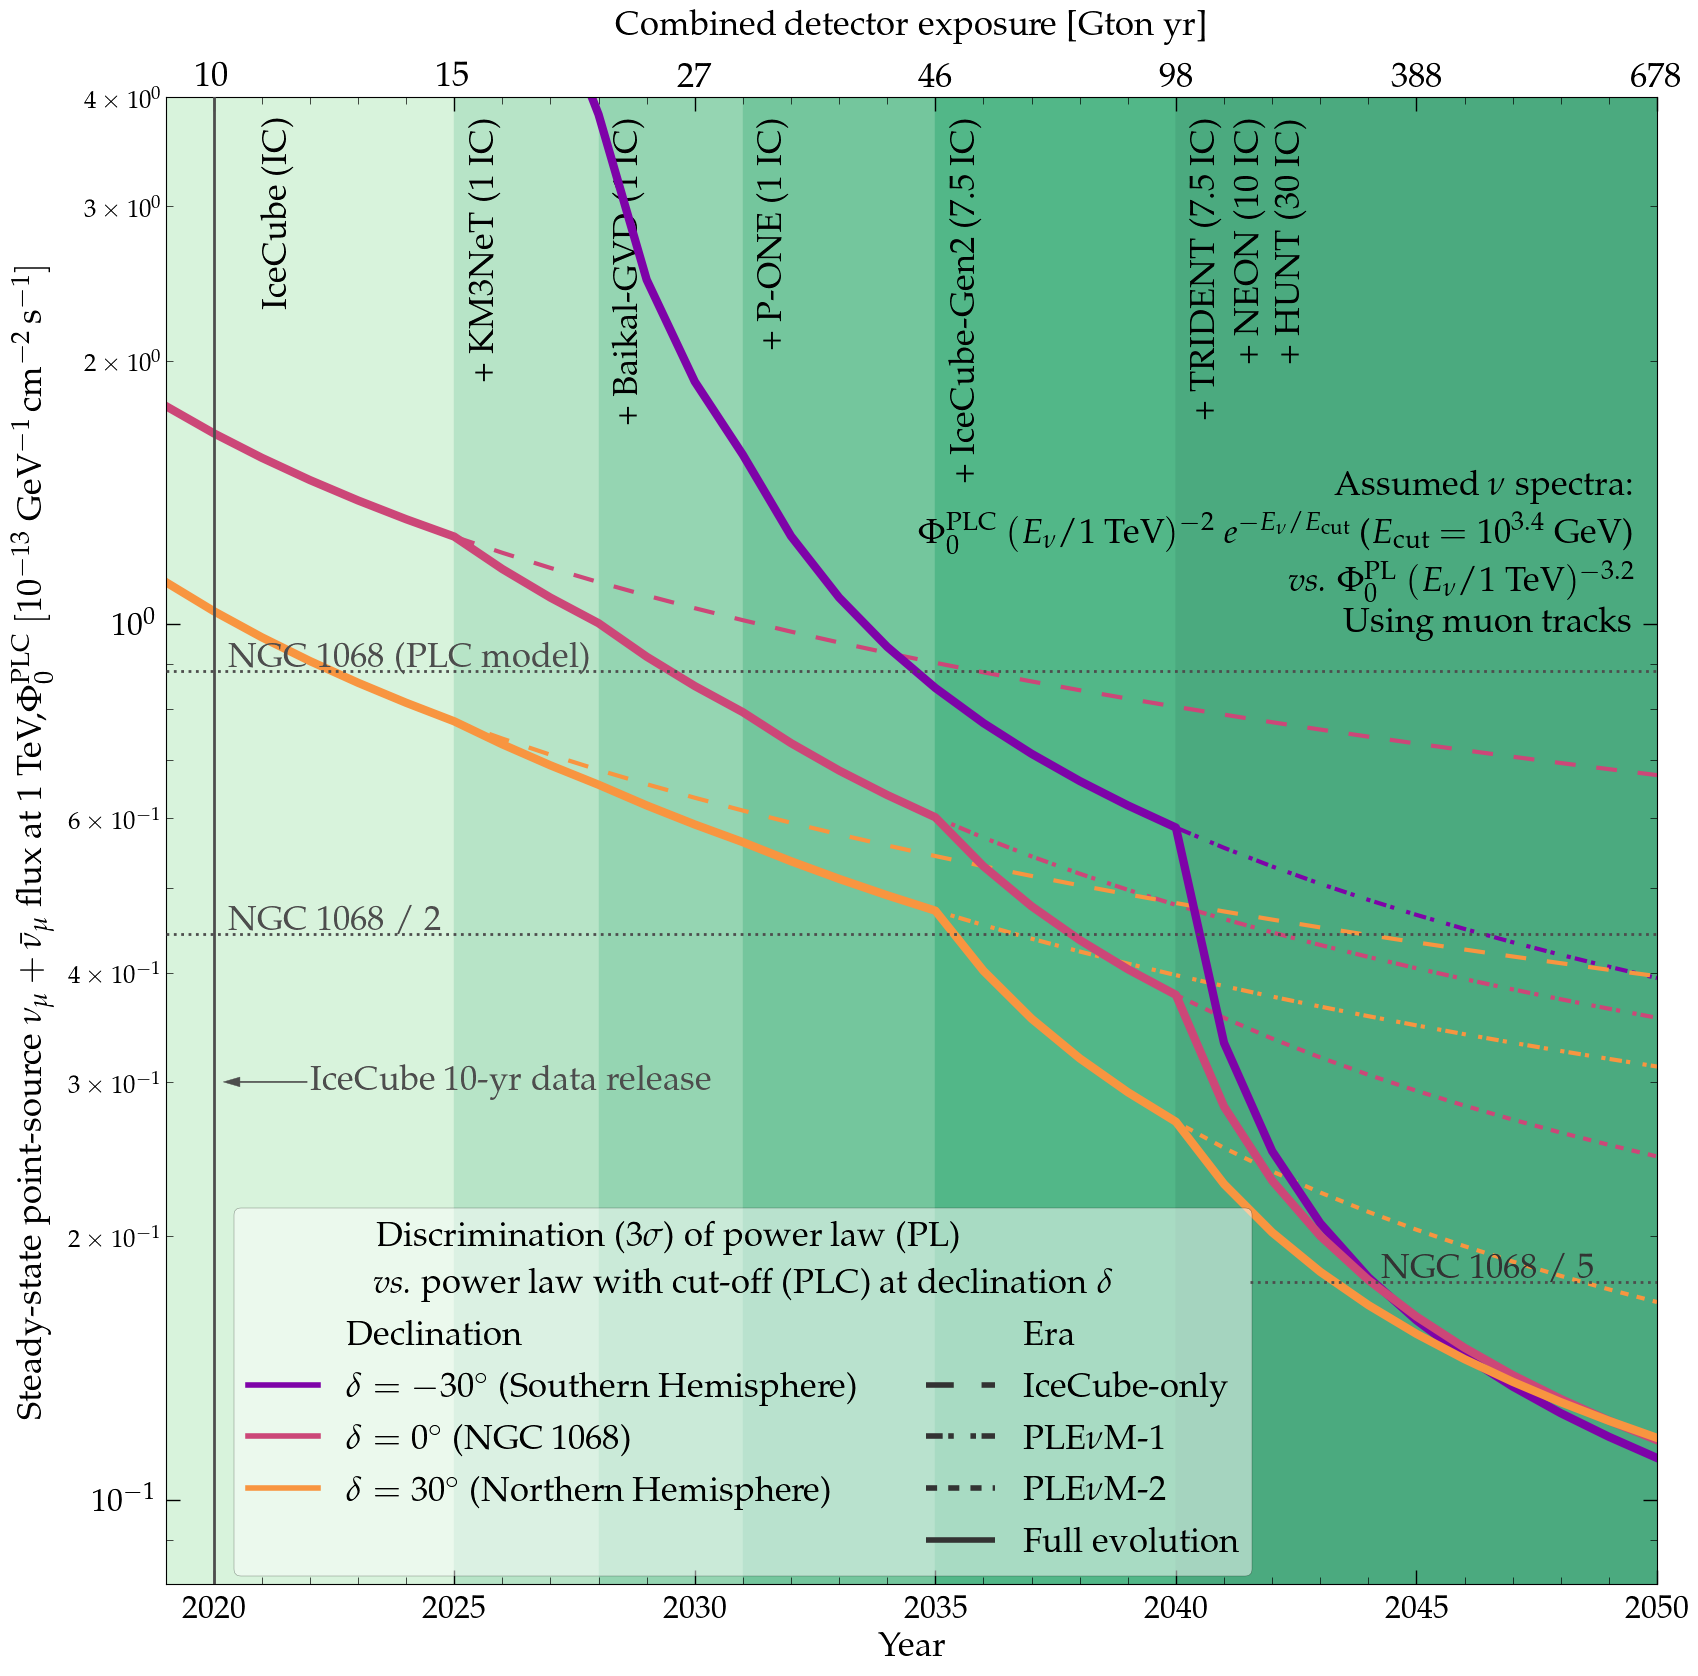

In [58]:
font_color = "0.3"

f, ax = plt.subplots(figsize=(19, 18))
_flux_sd = flux_sd
_flux_sd_min = flux_sd_min
_ymin = 0.08
_ymax = 4
_gamma = -3.2

for ii in [1, 2]:  # , 5]:
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=10)
    ax.text(
        x=2020 + 0.3,
        y=1.01 * ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068 (PLC model)" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=25,  # "large",
        zorder=10,
    )
ii = 5
ax.plot(
    [2041.55, 2050],
    ngc_cut_flux.norm * 1e13 / ii * np.ones(2),
    ls=":",
    lw=2,
    color=font_color,
    zorder=10,
)
ax.text(
    x=2048.7,
    y=1.01 * ngc_cut_flux.norm * 1e13 / ii,
    s=f"NGC 1068 / {ii}",
    ha="right",
    color="0.2",
    fontsize=25,
    zorder=10,
)

ax.annotate(
    r"Assumed $\nu$ spectra:"
    + "\n"
    + r"$\Phi_0^{\rm PLC}~(E_\nu/{\rm 1~TeV})^{-2}~e^{-E_\nu/E_{\rm cut}}~$($E_{\rm cut} = 10^{3.4}~{\rm GeV}$)"
    + "\n"
    + r"~{\it vs.}~$\Phi_0^{\rm PL}~(E_\nu/{\rm 1~TeV})^{-3.2}$"
    + "\n Using muon tracks",
    xy=(2049.5, 1.5),
    ha="right",
    va="top",
    zorder=10,
    color="k",
    fontsize=25,
)

width = 0.5e-1
_dashes = [(5, 5), (3, 1, 1), (2, 2), (1, 0)]

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.3),
    (2022, 0.3),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=25,  # "large",
)

for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.fill_between(
        x=[series.Year, yr_max],
        y1=[_ymax * 1.5, _ymax * 1.5],
        y2=0.0,
        color=series.colors,
        zorder=0.3,
    )
    if yr_i == "IceCube":
        x = 2021
    elif yr_i == "NEON":
        x = series.Year + 1.2
    elif yr_i == "HUNT":
        x = series.Year + 2.05
    else:
        x = series.Year + 0.3
    ax.text(
        x=x,
        y=_ymax * 0.95,
        s=series.label,
        ha="left",
        va="top",
        fontsize=25,
        zorder=2,
        rotation=90,
    )

# evolution
ax = sns.lineplot(
    data=_flux_sd.loc[(_flux_sd.sigma == sigma_ref)],
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=["-30°", "0°", "30°"],
    style="Era",
    style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
    lw=3,
    legend=False,
    palette="plasma",
    dashes=_dashes,
)

# minimum
sns.lineplot(
    data=_flux_sd_min,
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=["-30°", "0°", "30°"],
    lw=6,
    legend=False,
    palette="plasma",
)

# extra plotting for legend
ax.plot(np.NaN, np.NaN, "-", color="none", label=" ")
selection = _flux_sd.loc[(_flux_sd.sigma == sigma_ref) & (_flux_sd.Year == 2045)]
_hue_order = [
    r"$\delta = -30^\circ$~(Southern Hemisphere)",
    r"$\delta = 0^\circ$~(NGC 1068)",
    r"$\delta = 30^\circ$~(Northern Hemisphere)",
]

ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=_hue_order,
    style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
    style="Era",
    dashes=_dashes,
    lw=4,
    palette="plasma",
)
# re-ordering the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0, 5, 6, 7, 8, 9]
labels = [labels[idx] for idx in order]
labels[-1] = "Full evolution"
legend = ax.legend(
    [handles[idx] for idx in order],
    labels,
    bbox_to_anchor=(0.74, 0.265),
    framealpha=0.5,
    loc=1,
    title=r"\hspace*{-0.5em}Discrimination ($3\sigma$) of power law (PL)"
    + r"\\[0.3em]{\it vs.}~power law with cut-off (PLC) at declination $\delta$",
    ncol=2,
    fontsize=25,
    edgecolor="k",
    title_fontsize=25,
)
for ii, line in enumerate(legend.get_lines()):
    if ii == 0 or ii == 5:
        continue
    line.set_linewidth(4)

# Top x-axis (artificial, for simplicity)
for _, row in config_selection.iterrows():
    ax.text(
        x=row.Year,  # if row.Year < yr_max else yr_max - 1,
        y=_ymax * 1.03,
        s="{:0.0f}".format(row.exposure),
        fontsize=25,
        ha="center",
    )
ax.text(
    x=2034.5,
    y=_ymax * 1.18,
    s="Combined detector exposure [Gton~yr]",
    fontsize=25,
    ha="center",
)
ax.set_xlim(2019, yr_max)
ax.set_xlabel(r"Year", fontsize=25)
_yscaling = -13
ax.set_ylabel(
    r"Steady-state point-source $\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV,"
    + r"$\Phi_{0}^{\rm PLC} ~ ["
    + rf"10^{{{_yscaling}}}"
    + r"~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=25,
    labelpad=10,
)
plt.yticks(fontsize=23)
plt.xticks(fontsize=23)
ax.set_ylim(_ymin, _ymax)
ax.set_yscale("log")

ax.grid(alpha=0)
ax.yaxis.set_minor_locator(
    matplotlib.ticker.LogLocator(
        base=10.0, subs=np.arange(0.1, 1, step=0.1), numticks=12
    )
)
ax.yaxis.set_minor_formatter(
    matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(5, 1))
    # matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(3,4)) # shows all minor ticks
)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))


f.savefig(
    join(
        st.BASEPATH,
        plot_path,
        "time_evolution_significance_spectral_breakdown.pdf",
    ),
    dpi=300,
    bbox_inches="tight",
)

# 2D ngc contour

In [59]:
contour_formats = {
    "IceCube": {"colors": [det_plotting["IceCube"]["color"]], "linestyles": "--"},
    "IceCube - data release": {"colors": ["gray"], "linestyles": "--"},
    IC_North_det: {"colors": [det_plotting[IC_North_det]["color"]], "linestyles": ":", "linewidths": 4},
    "Plenum-1": {
        "colors": [det_plotting["Plenum-1"]["color"]],
        "linestyles": det_plotting["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [det_plotting["Plenum-2"]["color"]],
        "linestyles": det_plotting["Plenum-2"]["ls"],
    },
    "Plenum-3": {
        "colors": [det_plotting["Plenum-3"]["color"]],
        "linestyles": det_plotting["Plenum-3"]["ls"],
    },
}
detector_keys = ["IceCube", IC_North_det, "Plenum-1", "Plenum-2", "Plenum-3"]
energy_reso = ["baseline", "improved"]

In [60]:
SPL_df = pd.read_csv("../../resources/ngc_contour_spl.csv")
SPL_df


Unnamed: 0     LLH energy_res                   ident            ts  \
0               0  global   baseline  IceCube - data release -3.010994e+05   
1               1   local   baseline  IceCube - data release -3.010963e+05   
2               2   local   baseline  IceCube - data release -3.010966e+05   
3               3   local   baseline  IceCube - data release -3.010967e+05   
4               4   local   baseline  IceCube - data release -3.010968e+05   
...           ...     ...        ...                     ...           ...   
17175       17175   local   improved                Plenum-3 -1.353751e+06   
17176       17176   local   improved                Plenum-3 -1.353749e+06   
17177       17177   local   improved                Plenum-3 -1.353748e+06   
17178       17178   local   improved                Plenum-3 -1.353746e+06   
17179       17179   local   improved                Plenum-3 -1.353744e+06   

           conv  phi_astro  gamma   delta_ts  
0      1.000000        1.0  3.200        NaN  
1      1.022345        0.5  2.800   3.121174  
2      1.023111        0.5  2.825   2.881073  
3      1.023825        0.5  2.850   2.728744  
4      1.024497        0.5  2.875   2.650662  
...         ...        ...    ...        ...  
17175  0.990050        1.1  3.275  16.448789  
17176  0.989950        1.1  3.280  17.834704  
17177  0.989848        1.1  3.285  19.337413  
17178  0.989743        1.1  3.290  20.956037  
17179  0.989637        1.1  3.295  22.689740  

[17180 rows x 9 columns]

## simulation

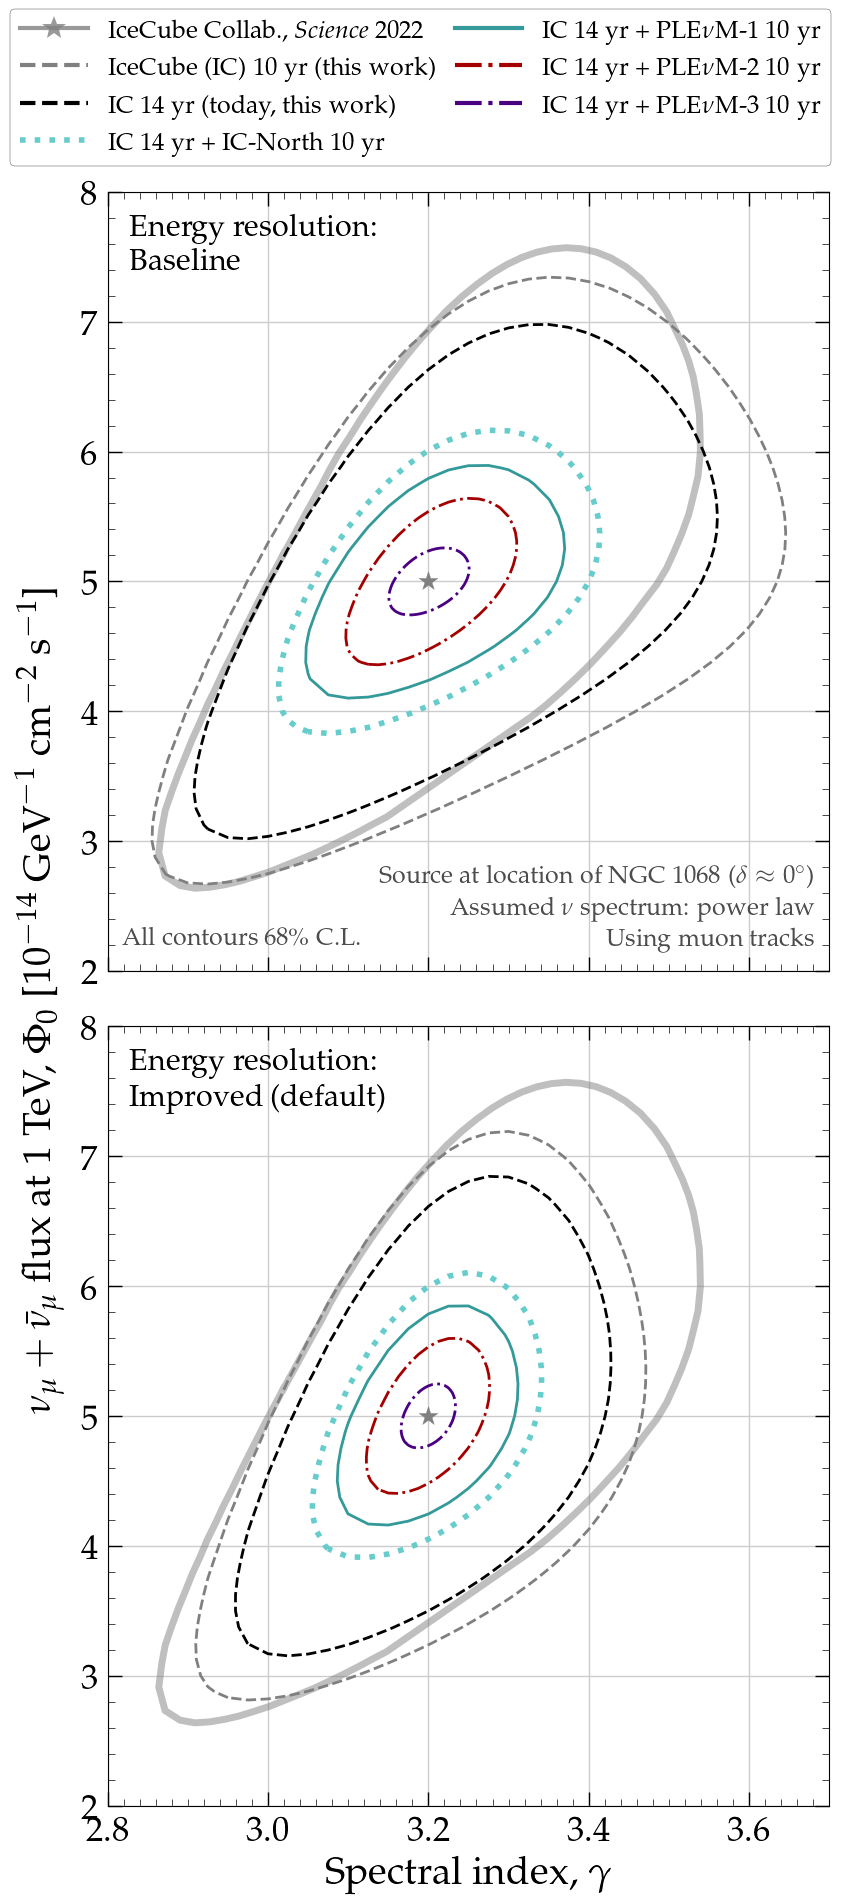

In [61]:
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(9, 18), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
#         fmt = {l: s for l, s in zip(sc.levels, lbs)}
#         ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="0.5",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.8, 3.7)
#     ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
#     ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index, $\gamma$", fontsize=28)
axes[0].annotate(r'Energy resolution:'+'\n'r'Baseline', 
                 xy = (0.03, 0.90), 
                 xycoords='axes fraction', 
                 ha='left', 
                 fontsize=22)
axes[1].annotate(r'Energy resolution:'+'\n'r'Improved (default)', 
                 xy = (0.03, 0.90), 
                 xycoords='axes fraction', 
                 ha='left', 
                 fontsize=22)

font_color='0.3'
axes[0].annotate(r"Source at location of NGC 1068 ($\delta \approx 0^\circ$)",
                 xy=(0.98, 0.12),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"Assumed $\nu$ spectrum: power law",
                 xy=(0.98, 0.08),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"Using muon tracks",
                 xy=(0.98, 0.04),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"All contours 68\%~C.L.",
                 xy=(0.02, 0.04),
                 xycoords='axes fraction', 
                 ha="left",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="0.5",
        mec=ref_color,
        label=r"IceCube Collab., {\it Science} 2022",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube - data release"]["colors"][0],
        ls=contour_formats["IceCube - data release"]["linestyles"],
        lw=3,
        label="IceCube (IC) 10 yr (this work)",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC 14 yr (today, this work)",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats[IC_North_det]["colors"][0],
        ls=contour_formats[IC_North_det]["linestyles"],
        lw=4,
        label="IC 14~yr + IC-North 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-1 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-2 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-3"]["colors"][0],
        ls=contour_formats["Plenum-3"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-3 10~yr",
    ),
]
f.legend(
    handles=lines,
    loc="upper center",
    ncol=2,
    # fontsize="large",
    frameon=True,
    edgecolor='k',
    handlelength=2.7,
    bbox_to_anchor=(0.505,1.085),
    columnspacing=0.8,
)

for ax in axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax.tick_params(axis='both', labelsize=25)


# Common y-axis label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel(r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1 TeV, $\Phi_0$~[$10^{-14}~{\rm GeV}^{-1}~{\rm cm}^{-2}~{\rm s}^{-1}$]",
           fontsize=28, labelpad=2)
plt.grid(alpha=0)


# flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
# flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
# ax.text(
#     2.65,
#     7.0,
#     flux_str,
#     fontsize=20,
#     bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
# )
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
# ax.grid(alpha=0.5)
# f.subplots_adjust(top=0.82)

f.savefig(join(st.BASEPATH, plot_path, "2D_scan_ngc1068.pdf"), dpi=300, bbox_inches='tight')

## Experimental data & comparison

### v1

In [62]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    join(st.BASEPATH, "resources/ngc_paper_68_contour.txt")
)
phi_c_68 /= 1e11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(st.BASEPATH, "resources/tenyr_paper_68_contour.txt")
)
phi_c_68_prev *= 1e-3

In [63]:
collect_times = {
    "IceCube NGC 1068 (2020)": {
        "data": [2008.2633309090984, 2018.517733159589],
        "plotting_kw": {"marker": "o", "ls": ":", "color": "k", "ms": 10},
    },
    "PLEnuM data": {
        "data": [2012.318105689836, 2018.517733159589],
        "plotting_kw": {"marker": "*", "ls": "-", "color": "tomato", "ms": 15},
    },
    "IceCube NGC 1068 (2022)": {
        "data": [2011.3616438356164, 2020.4071038251366],
        "plotting_kw": {"marker": "s", "ls": "--", "color": "k", "ms": 10},
    },
}

In [64]:
# best-fit on exp data
with open(join(st.BASEPATH, "resources/exp_result.pckl"), "rb") as f:
    out_global_pl = load(f)
out_global_pl

(array([0.93189545, 1.0826587 , 3.2733312 ]), 4837.453799730767)

In [65]:
with open(join(st.BASEPATH, "resources/param_errors.pckl"), "rb") as f:
    n_avg_err, gamma_avg_err = load(f)

In [66]:
sig_ts = pd.read_csv(join(st.BASEPATH, "resources/ngc_2D_LLH_scan_exp_dataBG.csv"))


In [67]:
cur_cmap = sns.cubehelix_palette(
    start=-0.6, rot=0, light=1, dark=0.2, as_cmap=True, reverse=True
) 

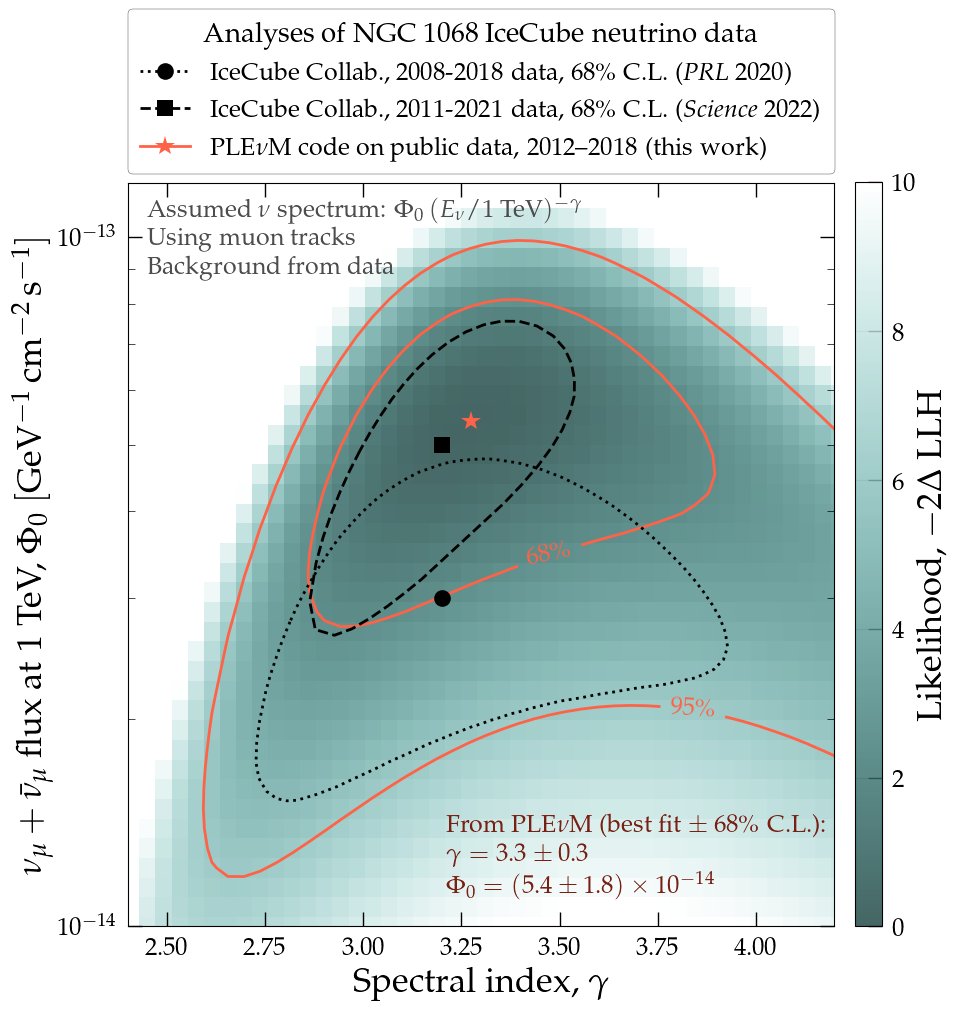

In [68]:
bg_from_data = True
savestr = "MCEq" if bg_from_data == False else "dataBG"
sig_ts = pd.read_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"))
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68\%", "95\%"]
levels = chi2.isf(cvals, 2)

fig, ax = plt.subplots(
    figsize=(9, 9), nrows=1, 
    # gridspec_kw={"height_ratios": [1, 8], "hspace": 0.28}
)

# ax = axes[0]
# # timeline
# for ii, key in enumerate(collect_times):
#     if key == "all":
#         continue
#     ax.plot(
#         collect_times[key]["data"],
#         np.repeat(ii, len(collect_times[key]["data"])),
#         **collect_times[key]["plotting_kw"],
#     )
# ax.tick_params(direction="out", which="both", top=False, right=False)
# ax.set_yticks([])
# ax.grid(False)
# ax.set_ylim(-0.5, 2.6)
# ax.set_xlabel("Dataset Timeline")

# ax = axes[1]

im = ax.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    alpha=0.8,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
cbax = fig.add_axes([0.98, 0.137, 0.03, 0.827])
cb = plt.colorbar(im, cax=cbax)
cb.set_label(r"Likelihood, $-2 \Delta$ LLH", fontsize=25, labelpad=0)
cbax.tick_params(axis='both', which='major', zorder=3)

ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
ax.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label=r"IceCube Collab., 2008-2018 data, 68\%~C.L. ({\it PRL} 2020)",
    ms=12,
    ls=":",
)

ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
ax.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label=r"IceCube Collab., 2011-2021 data, 68\%~C.L. ({\it Science} 2022)",
    ms=12,
    ls="--",
)


ax.plot(
    out_global_pl[0][2],
    out_global_pl[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label=r"PLE$\nu$M code on public data, 2012--2018 (this work)",
)
sc = ax.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "tomato"],
    zorder=1,
)
# fmt = {l: s for l, s in zip(sc.levels, lbs)}
fmt = {l: rf"{s}" for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=18)
# s = f"{x:.1f}"
#     if s.endswith("0"):
#         s = f"{x:.0f}"
#     return rf"{s} \%" if 


ax.set_xlabel(r"Spectral index, $\gamma$", fontsize=25)
ax.set_ylabel(r"$\nu_\mu+\bar{\nu}_\mu$ flux at 1~TeV,~$\Phi_0 ~ [{\rm GeV^{-1}\, cm^{-2}\, s^{-1}}]$", fontsize=25)
ax.legend(
    loc="upper center",
    frameon=True,
    bbox_to_anchor=(0.50, 1.25),
    edgecolor='k',
    title=r'Analyses of NGC 1068 IceCube neutrino data',
    title_fontsize=20,
    fontsize=18,
    borderpad=0.5
)
if bg_from_data:
    title_str = "Background from data"
    save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan.pdf")
else:
    title_str = "Background from MCEq"
    save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan_MCEq.pdf")

ax.annotate(
    r"Assumed $\nu$ spectrum: $\Phi_0 \, (E_\nu/{\rm 1~TeV})^{-\gamma}$"
    + "\n Using muon tracks \n"
    + title_str,
    xy=(2.45, 1.15e-13),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=18
)
ax.text(
    0.45,
    0.045,
    r"From PLE$\nu$M (best fit $\pm$ 68\%~C.L.):"+"\n"
    + rf"$\gamma={out_global_pl[0][2]:1.1f}\pm{gamma_avg_err:1.1f}$"
    + "\n"
    + rf"$\Phi_0=({out_global_pl[0][1] * ngc_flux.norm * 1E14:1.1f}\pm{n_avg_err * ngc_flux.norm * 1E14:1.1f})\times 10^{{-14}}$",
    fontsize=18,
    transform=ax.transAxes,
    ha="left",
    color="#772013", #"tomato", # now dark tomato
)


# ax.tick_params(direction="out", which="both", top=False, right=False)

ax.set_yscale("log")
# ax.set_ylim(6e-15, 1e-13)
ax.set_ylim(1.e-14, 1.2e-13)
ax.set_xlim(2.4, 4.2)
ax.grid(False)

# f.subplots_adjust(top=0.79)
fig.savefig(save_str, bbox_inches="tight") #, dpi=200)

### v0

In [69]:
# # # ngc flux error contour
# # gamma_c_68, phi_c_68 = np.loadtxt(
# #     join(st.BASEPATH, "resources/ngc_paper_68_contour.txt")
# # )
# # phi_c_68 /= 1e11

# # 10yr PS paper (data release)
# gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
#     join(st.BASEPATH, "resources/tenyr_paper_68_contour.txt")
# )
# phi_c_68_prev *= 1e-3
# collect_times = {
#     "IceCube NGC 1068 (2020)": {
#         "data": [2008.2633309090984, 2018.517733159589],
#         "plotting_kw": {"marker": "o", "ls": ":", "color": "k", "ms": 10},
#     },
#     "PLEnuM data": {
#         "data": [2012.318105689836, 2018.517733159589],
#         "plotting_kw": {"marker": "*", "ls": "-", "color": "tomato", "ms": 15},
#     },
#     "IceCube NGC 1068 (2022)": {
#         "data": [2011.3616438356164, 2020.4071038251366],
#         "plotting_kw": {"marker": "s", "ls": "--", "color": "k", "ms": 10},
#     },
# }
# # best-fit on exp data
# with open(join(st.BASEPATH, "resources/exp_result.pckl"), "rb") as f:
#     out_global_pl = load(f)
# out_global_pl
# with open(join(st.BASEPATH, "resources/param_errors.pckl"), "rb") as f:
#     n_avg_err, gamma_avg_err = load(f)
# sig_ts = pd.read_csv(join(st.BASEPATH, "resources/ngc_2D_LLH_scan_exp_dataBG.csv"))

# cur_cmap = sns.cubehelix_palette(
#     start=-0.6, rot=0, light=1, dark=0.2, as_cmap=True, reverse=True
# ) 
# bg_from_data = True
# savestr = "MCEq" if bg_from_data == False else "dataBG"
# sig_ts = pd.read_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"))
# sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
# sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
# cvals = [0.32, 0.05]
# lbs = ["68%", "95%"]
# levels = chi2.isf(cvals, 2)

# f, axes = plt.subplots(
#     figsize=(8, 10), nrows=2, gridspec_kw={"height_ratios": [1, 8], "hspace": 0.28}
# )

# ax = axes[0]
# # timeline
# for ii, key in enumerate(collect_times):
#     if key == "all":
#         continue
#     ax.plot(
#         collect_times[key]["data"],
#         np.repeat(ii, len(collect_times[key]["data"])),
#         **collect_times[key]["plotting_kw"],
#     )
# ax.tick_params(direction="out", which="both", top=False, right=False)
# ax.set_yticks([])
# ax.grid(False)
# ax.set_ylim(-0.5, 2.6)
# ax.set_xlabel("Dataset Timeline")

# ax = axes[1]

# im = ax.pcolormesh(
#     sig_ts_piv.columns,
#     sig_ts_piv.index,
#     sig_ts_piv,
#     vmin=0,
#     vmax=10,
#     cmap=cur_cmap,
#     alpha=0.8,
#     linewidth=0,
#     rasterized=True,
# )
# cb = plt.colorbar(im)
# cb.set_label(r"$-2 \Delta$ LLH")
# cb.ax.tick_params(direction="out")

# ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
# ax.plot(
#     3.2,
#     3e-14,
#     color="k",
#     marker="o",
#     label="IceCube NGC 1086 (PRL '20), 68% C.L.",
#     ms=12,
#     ls=":",
# )

# ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
# ax.plot(
#     3.2,
#     5e-14,
#     color="k",
#     marker="s",
#     label="IceCube NGC 1086 (Science '22), 68% C.L.",
#     ms=12,
#     ls="--",
# )


# ax.plot(
#     out_global_pl[0][2],
#     out_global_pl[0][1] * ngc_flux.norm,
#     color="tomato",
#     marker="*",
#     ms=15,
#     label="PLEnuM best-fit",
# )
# sc = ax.contour(
#     sig_ts_piv.columns,
#     sig_ts_piv.index,
#     sig_ts_piv,
#     levels=levels,
#     lw=3,
#     colors=["tomato", "darkred"],
#     zorder=1,
# )

# fmt = {l: s for l, s in zip(sc.levels, lbs)}
# plt.clabel(sc, levels, fmt=fmt, fontsize=12)


# ax.set_xlabel(r"$\gamma$")
# ax.set_ylabel(r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$\Phi_0 ~ [{\rm GeV^{-1}\, cm^{-2}\, s^{-1}}]$")
# f.legend(
#     loc="upper center",
#     frameon=False,
#     bbox_to_anchor=(0.42, 0.93),
# )
# if bg_from_data:
#     title_str = "background from data"
#     save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan.pdf")
# else:
#     title_str = "background from MCEq"
#     save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan_MCEq.pdf")

# ax.annotate(
#     r"Assumed $\nu$ spectrum: "
#     + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-\gamma}$"
#     + "\n Using muon tracks and "
#     + title_str,
#     xy=(2.45, 1.8e-13),
#     ha="left",
#     va="top",
#     zorder=10,
#     color=font_color,
#     fontsize=16,  # "large",
# )
# ax.text(
#     0.42,
#     0.06,
#     "Best-fit parameters:\n"
#     + rf"$\gamma={out_global_pl[0][2]:1.1f}\pm{gamma_avg_err:1.1f}$"
#     + "\n"
#     + rf"$\Phi_0=({out_global_pl[0][1] * ngc_flux.norm * 1E14:1.1f}\pm{n_avg_err * ngc_flux.norm * 1E14:1.1f})\times 10^{{-14}}$",
#     fontsize=18,
#     transform=ax.transAxes,
#     ha="left",
#     color="darkred",
# )


# ax.tick_params(direction="out", which="both", top=False, right=False)

# ax.set_yscale("log")
# # ax.set_ylim(6e-15, 1e-13)
# ax.set_ylim(8e-15, 2e-13)
# ax.set_xlim(2.4, 4.2)
# plt.grid(False)

# f.subplots_adjust(top=0.79)
# f.savefig(save_str, bbox_inches="tight") #, dpi=200)

In [70]:
ngc_cut_flux

PLcut_flux(norm=8.85186849442685e-14, gamma=2.0, e_cut=3.4, E0=1000.0, shape='powerlaw with cutoff')

# Flux models and analysis histogram slices

In [71]:
local_background_flux = np.genfromtxt(join(st.BASEPATH, "resources/local_background_ngc.txt"))


Number source $\nu_\mu$ : 98.2
Number atmo. $\nu_\mu$ : 1488.3 (within 28 deg²)
Number source $\nu_\mu$ : 98.2
Number atmo. $\nu_\mu$ : 1488.3 (within 28 deg²)


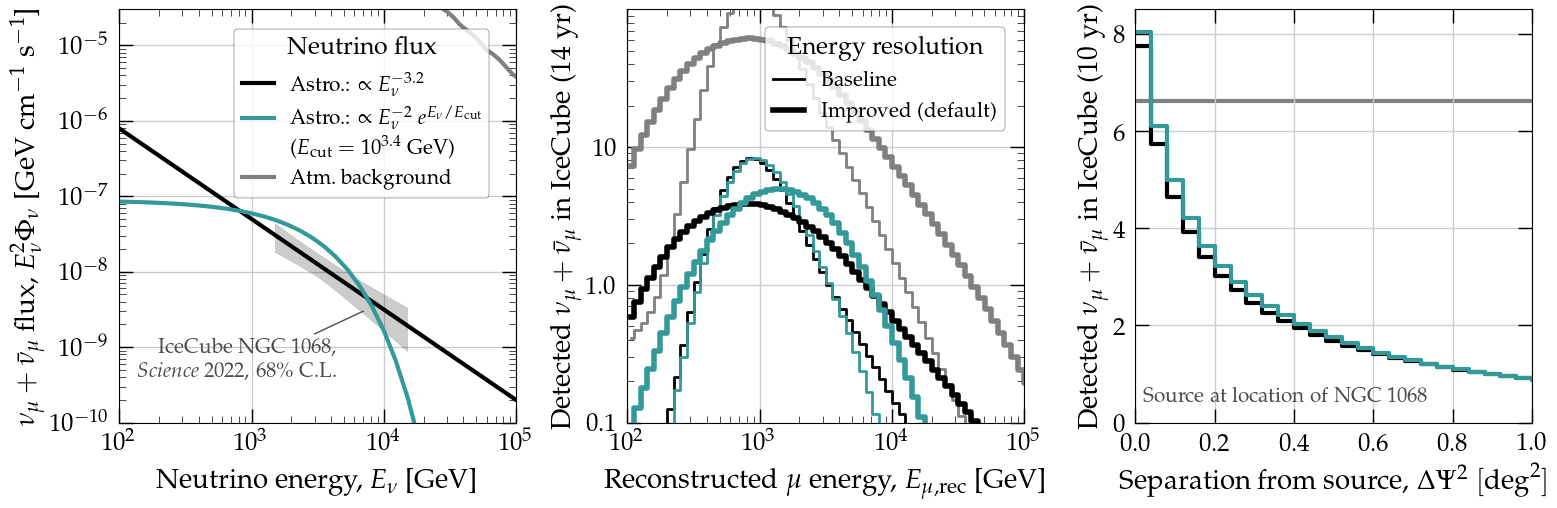

In [72]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2 # E**y_scaling on y axis

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax = axes[0]
fontsize = 20
# ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
#     label=rf"Astro.: power law (PL) $\gamma=${st.GAMMA_NGC}",
    label=r"Astro.: $\propto E_\nu^{-3.2}$",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
#     label=rf"Astro.: PL $\gamma=${{{st.Gamma_cut:1.1f}}}"+"\n"
#     + rf"$\times$~cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    label=r"\hspace*{-1.5em}Astro.: $\propto E_\nu^{-2}~e^{E_\nu/E_{\rm cut}}$"+r"\\[0.2em]"
    + rf"\hspace*{{-0.5em}}($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** st.logE_mids,
    local_background_flux * sq_deg * ((10 ** st.logE_mids) ** y_scaling),
#     label=r"Atmospheric background",
    label=r"Atm.~background",
    color="gray",
    lw=3,
)
# print(local_background_flux * sq_deg * ((10 ** st.logE_mids) ** y_scaling))

ax.set_yscale("log")
ax.set_ylabel(r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$E_\nu^2 \Phi_\nu$ [GeV~cm$^{-1}$~s$^{-1}$]", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_\nu$ [GeV]", fontsize=fontsize, labelpad=8)
ax.set_ylim(1e-10, 3e-5)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc=3,
    frameon=True,
    bbox_to_anchor=(0.23, 0.565),
    title='Neutrino flux',
    title_fontsize=18,
    fontsize=15,
    edgecolor='k',
    handlelength=1.5
)
ax.annotate(r"IceCube NGC 1068,"+'\n'+r"{\it Science} 2022, 68\%~C.L.",
            xy=(0.55, 0.15),
            xycoords='axes fraction', 
            ha="right",
            va="center",
            zorder=10,
            color=font_color,
            fontsize=15)
ax.plot([3.e3, 7.e3], [1.5e-9, 3.e-9], c=font_color, lw=1, ls='-')


### plot Event numbers in E_reco
ii = 0
ax = axes[1]
ident = "IceCube"

for e_name in ["baseline", "improved"]:
    k_b = np.genfromtxt(join(st.BASEPATH, f"resources/background_events_{e_name}.txt"))
    k_s_pl = np.genfromtxt(join(st.BASEPATH, f"resources/PL_events_{e_name}.txt"))
    k_s_cut = np.genfromtxt(join(st.BASEPATH, f"resources/PLC_events_{e_name}.txt"))

    ax = axes[1]
    _label = e_name.capitalize()
    if e_name == "improved":
        _label += " (default)"
    ax.plot(
        10.**st.logE_reco_mids,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=_label,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )

    ax.plot(
        10.**st.logE_reco_mids,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )

    ax.plot(
        10.**st.logE_reco_mids,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )
    print(rf"Number source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"Number atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
# ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1.e2, 1.e5)
ax.set_ylim(1.e-1, 10.e1)
ax.set_xlabel(r"Reconstructed~$\mu$ energy, $E_{\mu, {\rm rec}}$ [GeV]", fontsize=fontsize, labelpad=8)
ax.set_ylabel(r"Detected $\nu_\mu + \bar{\nu}_\mu$ in IceCube (14 yr)", fontsize=fontsize)
ax.set_yticks([0.1, 1.0, 10.], ['0.1', '1.0', '10'])
ax.legend(loc=3, 
          bbox_to_anchor=(0.32, 0.68),
          edgecolor='k',
          fontsize=15,
          title_fontsize=18,
          title=r'Energy resolution',
          handlelength=1.5)

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"Detected $\nu_\mu + \bar{\nu}_\mu$ in IceCube (10 yr)", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8.5)
ax.set_xlabel(r"Separation from source, $\Delta \Psi ^2~[{\rm deg}^2]$", fontsize=fontsize)
# ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)

ax.annotate(r"Source at location of NGC 1068",
            xy=(0.02, 0.06),
            xycoords='axes fraction', 
            ha="left",
            va="center",
            zorder=10,
            color=font_color,
            fontsize=15)


f.subplots_adjust(wspace=0.28)
f.savefig(
    join(st.BASEPATH, plot_path, "ngc_spectral_improved_dpsi.pdf"),
    bbox_inches="tight",
)

# Spectral models

In [73]:
gamma_err = 0.2
norm_err = 0.2

In [74]:
pvals_ngc = pd.read_pickle(
    join(st.BASEPATH, f"local/energy_cut_wiggle.pckl")
)
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - st.GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

In [75]:
pivot_gamma_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="gamma_pl_diff",
    #aggfunc="min",
)
pivot_norm_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="norm_pl_diff",
    #aggfunc="min",
)

In [76]:
# parameter selection
baseline_selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == 2)
    & np.isclose(pvals_ngc.normalization_factor, 1)
    & (pvals_ngc.logE_cut == 3.4)
]
print(baseline_selection)
flux_cut_norm = baseline_selection["flux_cut_norm"].values[0]

ngc_cut_flux = PLcut_flux(
    flux_cut_norm, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
)

   e_smearing          pval     pval_atmo    pval_check  significance  \
49   improved  2.031825e-11  2.031825e-11  2.031825e-11      6.601738   

    significance_atmo  significance_check  gamma_cut  logE_cut  flux_scaling  \
49          15.892544            6.601738          2       3.4      1.783528   

    flux_cut_norm  normalization_factor  out_pl_gamma  out_pl_norm  \
49   8.917642e-14                   1.0      3.132453     1.004353   

    out_plc_cut  out_plc_gamma  out_plc_norm  gamma_pl_diff  norm_pl_diff  \
49     3.400039       2.000037      1.783373      -0.067547      0.004353   

    pcheck_ratio  
49           1.0  


### v1

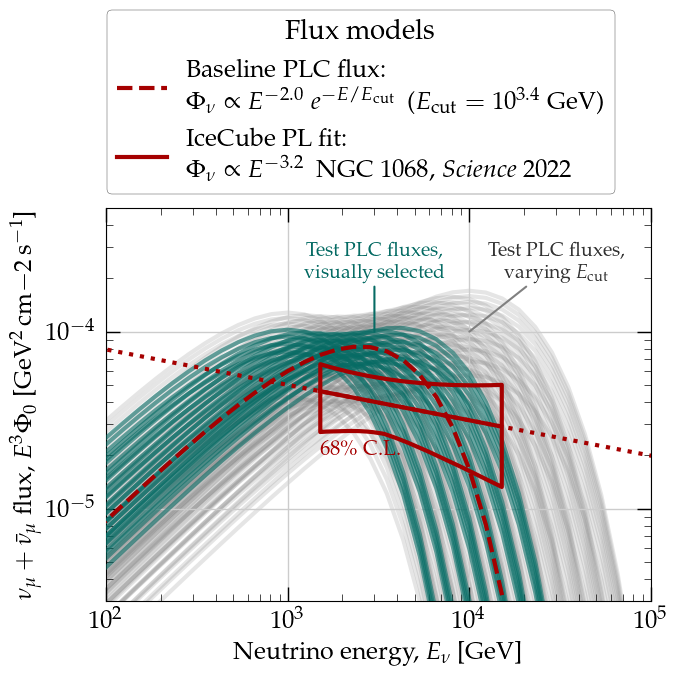

In [77]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(figsize=(7, 5))
# ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy cut off")

current_color = st.colors[2]

tmp_Gamma_cut = 2
for (tmp_nz, tmp_logE_cut), series in pvals_ngc.groupby(
    ["normalization_factor", "logE_cut"]
):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[tmp_logE_cut].loc[tmp_nz]:
        alpha_val = 0.6
        col = current_color
        zorder = 10
    else:
        alpha_val = 0.2
        col = "gray"
        zorder = -1

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        series.iloc[0]["flux_cut_norm"],  # st.PHI_NGC * series.iloc[0]["flux_scaling"],
        tmp_Gamma_cut,
        tmp_logE_cut,
        st.E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax.plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=zorder,
        lw=3,
    )

cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label="Baseline PLC flux:"
    + "\n"
    + rf"$\Phi_\nu \propto E^{{-{ngc_cut_flux.gamma}}} ~ e^{{-E/E_{{\rm cut}}}}$"
    + rf"~~($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$ GeV)",
)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    edgecolor=st.poles["Plenum-2"]["color"],
    facecolor=(0, 0, 0, 0),
    lw=3,
    zorder=15,
)
ax.plot(
    x_cont,
    power_law(x_cont, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm) * (x_cont**y_scaling),
    label=rf"IceCube PL fit:"
    + "\n"
    + rf"$\Phi_\nu \propto E^{{-{ngc_flux.gamma}}}$"
    + r"~~NGC 1068,"
    # + "\n"
    + r"~{\it Science} 2022",
    color=st.poles["Plenum-2"]["color"],
    alpha=1,
    zorder=10,
    lw=3,
)
ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    alpha=1,
    zorder=10,
    lw=3,
    ls=":",
)

ax.set_yscale("log")
ax.set_ylabel(
    r"$\nu_\mu+\bar{\nu}_\mu$ flux,~"
    + rf"$E^{{{y_scaling}}} \Phi_0$"  # / {{\rm d}}E$"
    + rf"~[$\rm GeV^{{{y_scaling-1}}}\, cm{{-2}} \, s^{{-1}}$]",
)
ax.set_xscale("log")
if y_scaling == 3:
    ax.set_ylim(3e-6, 5e-4)
    ax.set_xlim(1e2, 1e5)
elif y_scaling == 2:
    ax.set_ylim(1e-11, 1e-5)
    ax.set_xlim(1e2, 1e5)
ax.text(
    1.5e3,
    2e-5,
    "68\%~C.L.",
    fontsize=15,
    color=st.poles["Plenum-2"]["color"],
    zorder=100,
)
f.legend(
    loc=2,
    frameon=True,
    bbox_to_anchor=(0.15, 1.38, 0, 0),
    edgecolor="k",
    title="Flux models",
    title_fontsize=20,
)
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]")
plt.annotate(
    "Test PLC fluxes, \n" + r"varying $E_{\rm cut}$",
    (1e4, 1e-4),
    (3e4, 2e-4),
    ha="center",
    zorder=100,
    color="0.2",
    arrowprops=dict(
        arrowstyle="-",
        color="gray",
        lw=1.5,
        shrinkA=0,
        shrinkB=0,
    ),
)

plt.annotate(
    "Test PLC fluxes, \n visually selected",
    (0.3e4, 1e-4),
    (0.3e4, 2e-4),
    ha="center",
    zorder=100,
    color=current_color,
    arrowprops=dict(
        arrowstyle="-",
        color=current_color,
        lw=1.5,
        shrinkA=0,
        shrinkB=0,
    ),
)

f.tight_layout()
f.savefig(
    join(
        st.BASEPATH,
        plot_path,
        f"pl-cut_flux_model_matching_E{y_scaling}_noCM_onlyPLC.pdf",
    ),
    bbox_inches="tight",
)

### v0

In [78]:
# sq_deg = np.pi * st.delta_psi_max**2
# x_evals = np.logspace(0, 9, 100)
# y_scaling = 3

# f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
# ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy cut off")
# ax[1].set_title("Power law")

# current_color = st.colors[2]

# tmp_Gamma_cut = 2
# for (tmp_nz, tmp_logE_cut), series in pvals_ngc.groupby(
#     ["normalization_factor", "logE_cut"]
# ):
#     ## selecting results that are close to the original fit values
#     mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
#     if mask[tmp_logE_cut].loc[tmp_nz]:
#         alpha_val = 0.6
#         col = current_color
#     else:
#         alpha_val = 0.2
#         col = "gray"

#     # define the correctly normalized PL+cut flux for NGC 1068
#     ngc_cut_flux_tmp = PLcut_flux(
#         series.iloc[0]["flux_cut_norm"],  # st.PHI_NGC * series.iloc[0]["flux_scaling"],
#         tmp_Gamma_cut,
#         tmp_logE_cut,
#         st.E0_NGC,
#         "powerlaw with cutoff",
#     )
#     cut = power_law(
#         x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
#     ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

#     ax[0].plot(
#         x_evals,
#         cut * (x_evals**y_scaling),
#         color=col,
#         alpha=alpha_val,
#         zorder=10,
#         lw=3,
#     )

#     # define the correctly normalized PL flux for NGC 1068
#     # using the parameters obtained when fitting the PL+cut flux with PL
#     tmp_ngc_flux = PL_flux(
#         st.PHI_NGC * series.iloc[0]["out_pl_norm"],
#         series.iloc[0]["out_pl_gamma"],
#         st.E0_NGC,
#         "powerlaw",
#     )

#     pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

#     ax[1].plot(
#         x_evals,
#         pl * (x_evals**y_scaling),
#         color=col,
#         alpha=alpha_val,
#         zorder=1,
#         lw=3,
#     )
# cut = power_law(
#     x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
# ) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

# ax[0].plot(
#     x_evals,
#     cut * (x_evals**y_scaling),
#     color=st.poles["Plenum-2"]["color"],
#     ls="--",
#     lw=3,
#     zorder=20,
#     label=rf"$\Phi_\nu \propto E^{{-{ngc_cut_flux.gamma}}} ~ e^{{-E/E_{{\rm cut}}}}$"
#     + rf"~~($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
#     # label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
#     # + "\n"
#     # + rf"$\times$ "
#     # + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
# )

# # PL fit from chosen ecut/gamma parameters
# tmp_ngc_flux = PL_flux(
#     st.PHI_NGC * baseline_selection.iloc[0]["out_pl_norm"],
#     baseline_selection.iloc[0]["out_pl_gamma"],
#     st.E0_NGC,
#     "powerlaw",
# )

# pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

# ax[1].plot(
#     x_evals,
#     pl * (x_evals**y_scaling),
#     color=st.poles["Plenum-2"]["color"],
#     ls="--",
#     lw=3,
#     zorder=20,
#     label="Fit cut-off spectrum above \n"
#     + rf"with power law: $\Phi_\nu \propto E^{{-{tmp_ngc_flux.gamma:1.1f}}}$",
# )


# # error contour
# # with energy range interval
# x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# c_low = np.zeros_like(x_cont)
# c_high = np.zeros_like(x_cont)
# pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

# for ii, xe in enumerate(x_cont):
#     tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
#     c_low[ii] = np.min(tmp)
#     c_high[ii] = np.max(tmp)


# for axx in ax:
#     axx.fill_between(
#         x_cont,
#         c_low * (x_cont**y_scaling),
#         c_high * (x_cont**y_scaling),
#         edgecolor=st.poles["Plenum-2"]["color"],
#         facecolor=(0, 0, 0, 0),
#         lw=3,
#         zorder=15,
#     )
#     axx.plot(
#         x_evals,
#         pl * (x_evals**y_scaling),
#         label=rf"$\Phi_\nu \propto E^{{-{ngc_flux.gamma}}}$"
#         + "~~(NGC 1068, Science '22)",
#         color=st.poles["Plenum-2"]["color"],
#         alpha=1,
#         zorder=10,
#         lw=3,
#     )

#     axx.set_yscale("log")
#     axx.set_ylabel(
#         r"$\nu_\mu+\bar{\nu}_\mu$ flux,~"
#         + rf"$E^{{{y_scaling}}} {{\rm d}} \Phi_\nu$"  # / {{\rm d}}E$"
#         + rf"~[GeV$^{{{y_scaling-1}}}$ / cm² s]",
#     )
#     axx.set_xscale("log")
#     if y_scaling == 3:
#         axx.set_ylim(3e-6, 2e-3)
#         axx.set_xlim(1e2, 1e5)
#     elif y_scaling == 2:
#         axx.set_ylim(1e-11, 1e-5)
#         axx.set_xlim(1e2, 1e5)

#     axx.legend(loc=2, frameon=False)
# ax[1].set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]")

# f.tight_layout()
# f.savefig(
#     join(st.BASEPATH, plot_path, f"pl-cut_flux_model_matching_E{y_scaling}_noCM.pdf"),
#     bbox_inches="tight",
# )